<center><font size="6"><b>Drug Discovery: Prediction and Classification of Molecular (Drug) Properties</b></font></font></center>

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installs and Imports<a id='Imports'></a>

Install TDC dataset. Refer to this [webpage](https://tdcommons.ai/start/) for more details.

In [ ]:
!pip install PyTDC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Note that **RDKit**, which is the open source toolkit for cheminformatics, is already installed as a dependency with TDC dataset. This **RDKit** version is, however, old one. This was earlier called `rdkit-pypi`.

The latest version is 2023.03.1 and many significant changes have been made since the above old version. So, let's install the latest version. This will allow us to conveniently use the online documentation of **RDKit** here: https://www.rdkit.org/docs/index.html#.

In [ ]:
!pip install rdkit==2023.03.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 18.7 MB/s eta 0:00:00


Import the libraries.

In [ ]:
'''
TDC datasets: Curated for ML/AI tasks: https://tdcommons.ai/overview/
'''
# Loading ADME dataset: https://tdcommons.ai/single_pred_tasks/adme/
from tdc.single_pred import ADME
'''
Plotting libraries
'''
import pandas as pd
# import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

'''
What we'll need for analysis, PCA, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
'''
Spectral embedding
'''
# from sklearn.manifold import TSNE
# from sklearn.manifold import SpectralEmbedding, TSNE
# from sklearn.decomposition import KernelPCA

'''
RDKit imports
'''
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors, AllChem, Descriptors3D
'''
Modeling and Performance Evaluation
'''
# modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance

'''
Some utilities
'''
import progressbar
import os
import pickle # To save some data

Print RDKit version

In [ ]:
print(rdkit.__version__)

2023.03.1


Good! This one is the latest version.

# Load and Explore Data<a id='Load_and_Explore_Data'></a>

We are going to use the TDC dataset. TDC provides intuitive, high-level APIs to create ML models in Python. See [Data Loaders](https://tdcommons.ai/start/#:~:text=on%20external%20packages.-,Data%20Loaders,-TDC%20provides%20intuitive) section for more details.

In this project, we will use the `CYP P450 2C19 Inhibition` dataset from `ADME` task. More details about this dataset is [here](https://tdcommons.ai/single_pred_tasks/adme/#cyp-p450-2c19-inhibition-veith-et-al:~:text=a%20drug%27s%20action.-,CYP%20P450%202C19%20Inhibition%2C%20Veith%20et%20al.,-Dataset%20Description%3A).

In [ ]:
# Load ADME data
# data = ADME(name = 'Caco2_Wang') # dataset that we used initially -- suitable for regression task
data = ADME(name = 'CYP2C19_Veith') # datasett suitable for classification and clustering tasks

Downloading...
100%|██████████| 771k/771k [00:00<00:00, 8.38MiB/s]
Loading...
Done!


## About `CYP P450 2C19 Inhibition` dataset<a id='CYP_P450_2C19_Inhibition'></a>

**Description**: The name `CYP P450 2C19` is abbreviation of Cytochrome P450 2C19 which is an enzyme. Enzymes are proteins. In humans, it is the CYP2C19 gene that **encodes** the CYP2C19 protein. What is **encoding** here? Protein-encoding genes specify the sequences of amino acids, which are the building blocks of proteins. In turn, proteins are responsible for orchestrating nearly every function of the cell. Both protein-encoding genes and the enzymes (proteins) that are their gene products are absolutely essential to life as we know it. See [here](https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/15%3A_Genes_and_Proteins/15.01%3A_The_Genetic_Code_-_The_Relationship_Between_Genes_and_Proteins#:~:text=by%20peptide%20bonds-,Genes%20and%20Proteins,-Since%20the%20rediscovery). Specifically, the CYP2C19 gene provides instructions for making an enzyme called the endoplasmic reticulum, which is involved in protein processing and transport.

The CYP2C19 is a liver enzyme and is essential in the breakdown (metabolism) of various molecules and chemicals within cells, which is necessary for life. It acts on at least 10% of drugs in current clinical use, most notably the antiplatelet treatment clopidogrel (Plavix), drugs that treat pain associated with ulcers such as omeprazole, antiseizure drugs such as mephenytoin, the antimalarial proguanil, and the anxiolytic diazepam (ref: [Wikipedia](https://en.wikipedia.org/wiki/CYP2C19)).

An enzyme inhibitor is a molecule that binds to an enzyme and blocks its activity. If a drug acts as an enzyme inhibitor and stops (inhibits) an enzyme, this would mean poor metabolism to this drug and other drugs, which could lead to drug-drug interactions and adverse effects. 

The `CYP P450 2C19 Inhibition` dataset contains chemical nomenclatures (also known as SMILES strings which is explained later in this noteebook) of 12,665 drugs and whethere these drugs inhibit the activities of CYP2C19 genes and enzymes as binary (0/1) variable (target variable), `Y`. From the chemical nomenclatures or SMILES, we will extract a set of descriptors of these drugs by using RDKit toolkit. These descriptors will be used as **features** in our ML model building.

In [ ]:
type(data)

tdc.single_pred.adme.ADME

In [ ]:
df = data.get_data()

The variable `df` is a Pandas object holding the entire dataset.

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.head()

Drug_ID                                             Drug  Y
0  6602638.0           CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl  0
1   644675.0       CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1  1
2   644851.0                 Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1  1
3   644890.0  COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1  1
4   644968.0             COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1  1

In [ ]:
df.shape

(12665, 3)

As highlighted earlier, the dataset contains details about 12,665 drugs. In particular, it contains SMILES of each drug and whether it inhibits the activity of CYP2C19 gene and enzyme as binary (0/1) variable in `Y`.

In [ ]:
split = data.get_split()

By default, the variable `split` is a dictionary with keys `train`, `val`, and `test` whose values are all Pandas DataFrames with Drug IDs, SMILES strings (SMILES is discussed in the next section) and labels or target variable (`Y`). For further information, refer to [Datasets documentation](https://tdcommons.ai/overview/).

In particular, detail descriptions of different `ADME` datasets are available [here](https://tdcommons.ai/single_pred_tasks/adme/).

In [ ]:
split

{'train':          Drug_ID                                               Drug  Y
 0       644675.0         CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1  1
 1       644851.0                   Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1  1
 2       644968.0               COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1  1
 3       645063.0      CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1  0
 4       645164.0  CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...  0
 ...          ...                                                ... ..
 8861  16758808.0  O=C1C=C[C@@H](O)[C@@H]2[C@@H]1CC[C@H]1C(=O)N(C...  0
 8862  16758811.0  CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...  0
 8863  16758814.0  CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...  0
 8864  16758816.0  O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...  0
 8865  16758817.0  CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...  1
 
 [8866 rows x 3 columns],
 'valid':         Drug_ID                                               Drug  Y
 0     6604932.0   

In [ ]:
type(split['train']), type(split['test']), type(split['valid'])

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [ ]:
train_data = split['train']
test_data = split['test']
valid_data = split['valid']

In [ ]:
train_data.shape, test_data.shape, valid_data.shape

((8866, 3), (2533, 3), (1266, 3))

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8866 entries, 0 to 8865
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  8866 non-null   float64
 1   Drug     8866 non-null   object 
 2   Y        8866 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 207.9+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533 entries, 0 to 2532
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  2533 non-null   float64
 1   Drug     2533 non-null   object 
 2   Y        2533 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 59.5+ KB


In [ ]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  1266 non-null   float64
 1   Drug     1266 non-null   object 
 2   Y        1266 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.8+ KB


**There are no missing values.** It's expected because the TDC dataset is already curated for AI/ML-ready. We can check them more explicitly below.

In [ ]:
train_data.isnull().sum()

Drug_ID    0
Drug       0
Y          0
dtype: int64

In [ ]:
test_data.isnull().sum()

Drug_ID    0
Drug       0
Y          0
dtype: int64

In [ ]:
valid_data.isnull().sum()

Drug_ID    0
Drug       0
Y          0
dtype: int64

We can also check if there are any duplicate values or not. We should not have because the TDC dataset is already cleaned.

In [ ]:
train_data.duplicated().sum(), test_data.duplicated().sum(), valid_data.duplicated().sum()

(0, 0, 0)

Good! **We do not have any duplicated values.**

Let's next verify if distributions of 0/1 labels of `Y` in the `train_data`, `test_data`, and `valid_data` are same as the entire data set, `df` (are the 3 splits stratified?). 

In [ ]:
round(df.Y.value_counts(normalize = True),2)

0    0.54
1    0.46
Name: Y, dtype: float64

In [ ]:
round(train_data.Y.value_counts(normalize = True),2)

0    0.54
1    0.46
Name: Y, dtype: float64

In [ ]:
round(test_data.Y.value_counts(normalize = True),2)

0    0.54
1    0.46
Name: Y, dtype: float64

In [ ]:
round(valid_data.Y.value_counts(normalize = True),2)

0    0.53
1    0.47
Name: Y, dtype: float64

Great! The distributions of 0/1 classes are same for all the datasets (i.e., **stratified**).

## Some Basics about RDKit and descriptors (features) of drugs (or molecules)<a id='Some_Basics'></a>

Let's next convert `Drug` variable to `rdkit.Chem.rdchem.Mol` object. The `Drug` variable is also known as **simplified molecular input line entry system** (SMILES). SMILES is a simple yet comprehensive chemical nomenclature. This is a form of line notation for describing the structure of chemical species using text strings. More details can be found [here](https://www.daylight.com/meetings/summerschool98/course/dave/smiles-intro.html#TOC).

Write functions to achive this task.

**Standardize molecules** (to deal with physically unstable molecules that might be present in the dataset) -- [details](https://pgg1610.github.io/data_blog/posts/2021-10-10-Rdkit.html#:~:text=Standardize%20molecules).

In [ ]:
def standardize(mol):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

In [ ]:
# Function to call the function above to convert SMILES to molecule after
# standardizing.
def smiles_to_mol(smiles, standardize_mol = 0):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    
    if standardize_mol == 1:
      mol = standardize(mol)

    return mol

In the above function, the output `mol` is a special type of `RDKit` object, i.e.,`rdkit.Chem.rdchem.Mol` object.

In [ ]:
# Add a column `Molecule` to each data set to represent each molecule as this
# `RDKit` object. 
train_data['Molecule'] = train_data['Drug'].apply(smiles_to_mol)
test_data['Molecule'] = test_data['Drug'].apply(smiles_to_mol)
valid_data['Molecule'] = valid_data['Drug'].apply(smiles_to_mol)

In [ ]:
train_data.head(n=2)

Drug_ID                                        Drug  Y  \
0  644675.0  CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1  1   
1  644851.0            Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1  1   

                                           Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x7f35785ed0e0>  
1  <rdkit.Chem.rdchem.Mol object at 0x7f35785ed1c0>

In [ ]:
test_data.head(n=2)

Drug_ID                                     Drug  Y  \
0  3232975.0  Cc1cnc(CNc2cc(-c3ccc(N(C)C)cc3)ncn2)cn1  0   
1   290548.0         Oc1ccc(CCNCc2cc3c(cc2Br)OCO3)cc1  1   

                                           Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x7f357903db60>  
1  <rdkit.Chem.rdchem.Mol object at 0x7f357903dbd0>

In [ ]:
valid_data.head(n=2)

Drug_ID                                               Drug  Y  \
0  6604932.0     N[C@H](Cn1ccc(=O)n(Cc2ccccc2C(=O)O)c1=O)C(=O)O  0   
1  3232722.0  O=C(c1cc(C(F)(F)F)cc(C(F)(F)F)c1)N1CCC[C@@]2(C...  1   

                                           Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x7f3579083920>  
1  <rdkit.Chem.rdchem.Mol object at 0x7f3579083990>

Ok, everything looks good so far.

In [ ]:
type(train_data.Molecule[1])

rdkit.Chem.rdchem.Mol

To display the molecule:

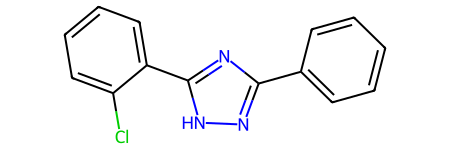

In [ ]:
# Just consider one molecule
mol = train_data.Molecule[1]
mol

Display a couple of more molecules.

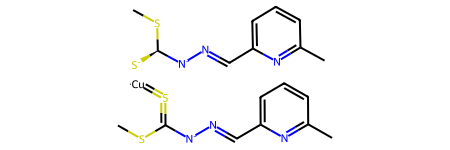

In [ ]:
# Just consider one molecule
# mol = train_data.Molecule[1963] # When extracting 3D descriptor: UFFTYPER: Unrecognized charge state for atom: 1
mol = valid_data.Molecule[268] # When extracting 3D descriptor: UFFTYPER: Unrecognized atom type: Cu5+1 (14)
mol

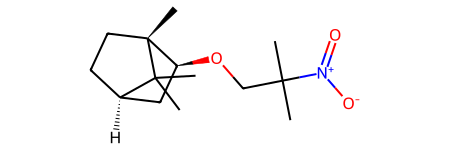

In [ ]:
# mol = train_data.Molecule[2592] # When extracting descriptor: Embedding fails
mol = valid_data.Molecule[524] # When extracting descriptor: Embedding fails
mol

## Descriptors for molecules<a id='Descriptors_for_molecules'></a>

We can find more information about the molecule using `rdkit.Chem.Descriptors` (ref: [rdkit.Chem.Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html#:~:text=rdkit.Chem.Descriptors%20module%C2%B6) module).

In [ ]:
# To get average molecular weight
MolWt = Descriptors.MolWt(mol)
print(f"Average molecullar weight: {MolWt}")

Average molecullar weight: 255.35799999999995


In [ ]:
# To get exact molecular weight
MolWt = Descriptors.ExactMolWt(mol)
print(f"Exact molecullar weight: {MolWt}")

Exact molecullar weight: 255.18344366


In [ ]:
# table_file = '/content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature3DCYP_table_valid.pkl'
# with open(table_file, 'wb') as f:
#   pickle.dump([MolWt], f)

The `rdkit.Chem.Descriptors.CalcMolDescriptors` (ref: [rdkit.Chem.Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html#:~:text=rdkit.Chem.Descriptors.CalcMolDescriptors) module) can be used to calculate the full set of descriptors for a molecule.





In [ ]:
all_descriptors = Descriptors.CalcMolDescriptors(mol)
print(all_descriptors)

{'MaxAbsEStateIndex': 10.918444074389015, 'MaxEStateIndex': 10.918444074389015, 'MinAbsEStateIndex': 0.18486630763416456, 'MinEStateIndex': -0.9837929894179891, 'qed': 0.5719562630497347, 'MolWt': 255.35799999999995, 'HeavyAtomMolWt': 230.15799999999996, 'ExactMolWt': 255.18344366, 'NumValenceElectrons': 104, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.23917117831026913, 'MinPartialCharge': -0.37018572331424804, 'MaxAbsPartialCharge': 0.37018572331424804, 'MinAbsPartialCharge': 0.23917117831026913, 'FpDensityMorgan1': 1.3888888888888888, 'FpDensityMorgan2': 2.0, 'FpDensityMorgan3': 2.388888888888889, 'BCUT2D_MWHI': 16.637228433363088, 'BCUT2D_MWLOW': 9.697139484258159, 'BCUT2D_CHGHI': 2.6169996581905344, 'BCUT2D_CHGLO': -2.3888784483656833, 'BCUT2D_LOGPHI': 2.657600355113388, 'BCUT2D_LOGPLOW': -2.423337213633388, 'BCUT2D_MRHI': 5.1070016646876635, 'BCUT2D_MRLOW': -0.5652154228784713, 'AvgIpc': 2.579407700874497, 'BalabanJ': 2.0355354702964004, 'BertzCT': 364.05060480113934, 'Chi0':

In [ ]:
print(f"There are {len(all_descriptors.keys())} descriptors that we can calculate using RDKit.")

There are 209 descriptors that we can calculate using RDKit.


There are additional descriptors that can also be derived from a molecule's 3D structure. We can compute them using `rdkit.Chem.Descriptors3D` module (ref: [https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html]).

In [ ]:
# Reference: https://github.com/rdkit/rdkit/issues/2924

molh = rdkit.Chem.AddHs(mol)   
EmbeddingFlag = AllChem.EmbedMolecule(molh)
if EmbeddingFlag == -1:
  print(f"Embeedding fails")
  Asphericity_H = float("nan")
else:
  Asphericity_H = Descriptors3D.Asphericity(molh)
  print(f"Asphericity with H's: {Asphericity_H}")

if EmbeddingFlag == -1:
  Asphericity = float("nan")
else:  
  mol = rdkit.Chem.RemoveHs(molh)
  Asphericity = Descriptors3D.Asphericity(mol)
  print(f"Asphericity after removing H's: {Asphericity}")

Embeedding fails


In [ ]:
pd.isna(Asphericity), pd.isna(Asphericity_H)

(True, True)

Let us include all of the descriptors that `RDKit` can compute (2D and 3D) in our train, test, and validation datasets. The following cell demonstrates that `RDKit` provides a large number of descriptors (2D and 3D). However, all of these descriptors may not be required for our analysis. But, let us include all of them for now.

In [ ]:
def extract_3D_descriptors(table, i, mol):

  # Add hydrogens to a molecule before doing the embedding
  molh = rdkit.Chem.AddHs(mol)
  EmbeddingFlag = AllChem.EmbedMolecule(molh)

  if EmbeddingFlag == -1:
    print(f" Embeedding fails: {i}")

    # Assign the nan as 3D features
    table.loc[i,'Asphericity_H'] = float("nan")
    table.loc[i,'Eccentricity_H'] = float("nan")
    table.loc[i,'InertialShapeFactor_H'] = float("nan")
    table.loc[i,'NPR1_H'] = float("nan")
    table.loc[i,'NPR2_H'] = float("nan")
    table.loc[i,'PMI1_H'] = float("nan")
    table.loc[i,'PMI2_H'] = float("nan")
    table.loc[i,'PMI3_H'] = float("nan")
    table.loc[i,'RadiusOfGyration_H'] = float("nan")

    
    table.loc[i,'Asphericity'] = float("nan")
    table.loc[i,'Eccentricity'] = float("nan")
    table.loc[i,'InertialShapeFactor'] = float("nan")
    table.loc[i,'NPR1'] = float("nan")
    table.loc[i,'NPR2'] = float("nan")
    table.loc[i,'PMI1'] = float("nan")
    table.loc[i,'PMI2'] = float("nan")
    table.loc[i,'PMI3'] = float("nan")
    table.loc[i,'RadiusOfGyration'] = float("nan")

  else:
    # Calculate the 3D features with H's
    table.loc[i,'Asphericity_H'] = Descriptors3D.Asphericity(molh)
    table.loc[i,'Eccentricity_H'] = Descriptors3D.Eccentricity(molh)
    table.loc[i,'InertialShapeFactor_H'] = Descriptors3D.InertialShapeFactor(molh)
    table.loc[i,'NPR1_H'] = Descriptors3D.NPR1(molh)
    table.loc[i,'NPR2_H'] = Descriptors3D.NPR2(molh)
    table.loc[i,'PMI1_H'] = Descriptors3D.PMI1(molh)
    table.loc[i,'PMI2_H'] = Descriptors3D.PMI2(molh)
    table.loc[i,'PMI3_H'] = Descriptors3D.PMI3(molh)
    table.loc[i,'RadiusOfGyration_H'] = Descriptors3D.RadiusOfGyration(molh)

    # Calculate the 3D features without H's
    mol = rdkit.Chem.RemoveHs(molh)
    table.loc[i,'Asphericity'] = Descriptors3D.Asphericity(mol)
    table.loc[i,'Eccentricity'] = Descriptors3D.Eccentricity(mol)
    table.loc[i,'InertialShapeFactor'] = Descriptors3D.InertialShapeFactor(mol)
    table.loc[i,'NPR1'] = Descriptors3D.NPR1(mol)
    table.loc[i,'NPR2'] = Descriptors3D.NPR2(mol)
    table.loc[i,'PMI1'] = Descriptors3D.PMI1(mol)
    table.loc[i,'PMI2'] = Descriptors3D.PMI2(mol)
    table.loc[i,'PMI3'] = Descriptors3D.PMI3(mol)
    table.loc[i,'RadiusOfGyration'] = Descriptors3D.RadiusOfGyration(mol)

  return table

def extract_descriptors(data, descriptor3D):
  bar=progressbar.ProgressBar(max_value=len(data.Molecule))
  
  for i, mol in enumerate(data.Molecule):
    rdkit.Chem.SanitizeMol(mol)
    data.loc[i,'smiles']=rdkit.Chem.MolToSmiles(mol)

    # All 2D descriptors from rdkit.Chem.Descriptors.CalcMolDescriptors
    all_descriptors = Descriptors.CalcMolDescriptors(mol)

    for descriptor in all_descriptors.keys():
      data.loc[i,descriptor] = all_descriptors[descriptor]

    # Extract 3D descriptors
    if descriptor3D == 1:
      data = extract_3D_descriptors(data, i, mol)

    bar.update(i+1)

  return data

In [ ]:
# Write a function to save computationally expensive results or load the results
def saveload_file(file_with_path, data, descriptor3D):

  file_exists = os.path.exists(file_with_path)

  if file_exists:

    print(f"The file for {file_with_path} exists. Loading it...")
    # Getting back the objects:
    with open(file_with_path, 'rb') as f:
      data = pickle.load(f)
      data = data[0]
  
  else:
    data = extract_descriptors(data, descriptor3D)
    
    with open(file_with_path, 'wb') as f:
      pickle.dump([data], f)

  return data

In [ ]:
data_descriptor_file = '/content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature3DCYP_data_valid.pkl'

valid_data3D = saveload_file(data_descriptor_file, valid_data, descriptor3D = 1)

The file for /content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature3DCYP_data_valid.pkl exists. Loading it...


In [ ]:
# # Running first time.
# valid_data3D = extract_descriptors(valid_data, descriptor3D = 1)

Following is the output of running the `extract_descriptors(valid_data)` first time:

![Output message](https://drive.google.com/uc?export=view&id=1-HZ6WrlHx_zNlwwRQznVkv9VEa1QDSN-)


We see above a couple of different types of `UFFTYPER` warnings and `Embeedding fails` messages for **several** drugs (molecules). They essentially imply that these drugs are possibly not physically reasonable molecules (see [here](https://github.com/rdkit/rdkit/issues/2996#:~:text=physically%20reasonable%20structures)). It is likely that a 3D structure could not be found for these drugs, and 3D descriptors cannot be derived for these molecules. In pharmaceutical industry, it is also typical to consider only 2D descriptors. More importantly, **3D descriptors calculated in vaccum (as done in RDKit) often do not add value in situ**, in the presence of solvent and proteins as encountered in cell environment.

There are other **paid** toolkits (e.g., OpenEye's OMEGA used for Conformational ensembles, or Corina for 3D structures) which are often used instead of RDKit in pharmaceutical industry to extract the 3D descriptors.

Also see this GitHub page on `Auto3D` Python [package](https://github.com/isayevlab/Auto3D_pkg) for relevant information.

In the remainder of this wrok, we would, therefore, only work with 2D descriptors. 

In [ ]:
# train_data = extract_descriptors(train_data, descriptor3D = 0)

data_descriptor_file = '/content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_train.pkl'

train_data = saveload_file(data_descriptor_file, train_data, descriptor3D = 0)

The file for /content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_train.pkl exists. Loading it...


In [ ]:
print(f"Updated train_data.shape: {train_data.shape}\n")
train_data.head()

Updated train_data.shape: (8866, 214)



Drug_ID                                               Drug  Y  \
0  644675.0         CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1  1   
1  644851.0                   Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1  1   
2  644968.0               COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1  1   
3  645063.0      CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1  0   
4  645164.0  CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...  0   

                                           Molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f3578bc09a0>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f3578eb8ae0>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f3578eb8b80>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f3578eb8c20>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f3578eb8d10>   

                                              smiles  MaxAbsEStateIndex  \
0         CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1          12.610408   
1                   Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1           6.126257   
2               COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1          12.040635   
3      CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1          12.762343   
4  CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...          13.082813   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed  ...  \
0       12.610408           0.072387       -3.973681  0.720977  ...   
1        6.126257           0.660427        0.660427  0.756902  ...   
2       12.040635           0.006714       -0.208718  0.728361  ...   
3       12.762343           0.182110       -0.533851  0.757037  ...   
4       13.082813           0.018472       -0.044883  0.457249  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0         0.0           1.0         0.0                0.0           0.0   
1         0.0           0.0         0.0                0.0           0.0   
2         0.0           0.0         0.0                0.0           1.0   
3         0.0           0.0         0.0                0.0           0.0   
4         0.0           0.0         0.0                0.0           1.0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0          0.0          0.0           1.0               0.0      0.0  
1          0.0          0.0           0.0               0.0      0.0  
2          0.0          0.0           0.0               0.0      0.0  
3          0.0          0.0           0.0               0.0      1.0  
4          0.0          0.0           0.0               0.0      0.0  

[5 rows x 214 columns]

<Axes: >

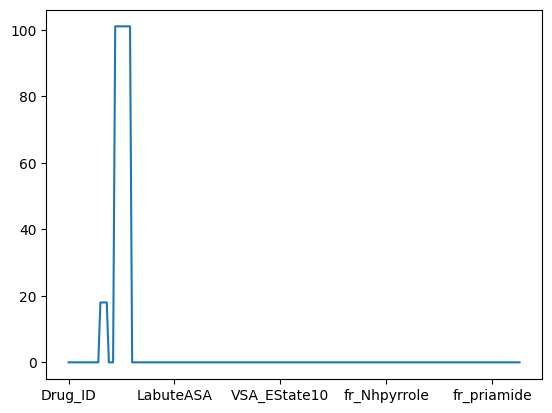

In [ ]:
train_data.isnull().sum().plot()

In [ ]:
nan_columns_train = train_data.columns[train_data.isna().any()].tolist()
nan_columns_train

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [ ]:
train_data[nan_columns_train].isnull().sum()

MaxPartialCharge        18
MinPartialCharge        18
MaxAbsPartialCharge     18
MinAbsPartialCharge     18
BCUT2D_MWHI            101
BCUT2D_MWLOW           101
BCUT2D_CHGHI           101
BCUT2D_CHGLO           101
BCUT2D_LOGPHI          101
BCUT2D_LOGPLOW         101
BCUT2D_MRHI            101
BCUT2D_MRLOW           101
dtype: int64

In [ ]:
train_data.dropna().shape

(8765, 214)

In [ ]:
# test_data = extract_descriptors(test_data, descriptor3D = 0)

data_descriptor_file = '/content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_test.pkl'

test_data = saveload_file(data_descriptor_file, test_data, descriptor3D = 0)

The file for /content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_test.pkl exists. Loading it...


In [ ]:
print(f"Updated test_data.shape: {test_data.shape}\n")

Updated test_data.shape: (2533, 214)



In [ ]:
nan_columns_test = test_data.columns[test_data.isna().any()].tolist()
nan_columns_test

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [ ]:
test_data[nan_columns_test].isnull().sum()

MaxPartialCharge       11
MinPartialCharge       11
MaxAbsPartialCharge    11
MinAbsPartialCharge    11
BCUT2D_MWHI            34
BCUT2D_MWLOW           34
BCUT2D_CHGHI           34
BCUT2D_CHGLO           34
BCUT2D_LOGPHI          34
BCUT2D_LOGPLOW         34
BCUT2D_MRHI            34
BCUT2D_MRLOW           34
dtype: int64

In [ ]:
test_data.dropna().shape

(2499, 214)

In [ ]:
# valid_data = extract_descriptors(valid_data, descriptor3D = 0)

data_descriptor_file = '/content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_valid.pkl'

valid_data = saveload_file(data_descriptor_file, valid_data, descriptor3D = 0)

The file for /content/drive/MyDrive/ColabNotebooks/DrugDiscovery/feature2DCYP_data_valid.pkl exists. Loading it...


In [ ]:
print(f"Updated valid_data.shape: {valid_data.shape}\n")

Updated valid_data.shape: (1266, 214)



In [ ]:
nan_columns_valid = valid_data.columns[valid_data.isna().any()].tolist()
nan_columns_valid

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [ ]:
valid_data[nan_columns_valid].isnull().sum()

MaxPartialCharge        3
MinPartialCharge        3
MaxAbsPartialCharge     3
MinAbsPartialCharge     3
BCUT2D_MWHI            17
BCUT2D_MWLOW           17
BCUT2D_CHGHI           17
BCUT2D_CHGLO           17
BCUT2D_LOGPHI          17
BCUT2D_LOGPLOW         17
BCUT2D_MRHI            17
BCUT2D_MRLOW           17
dtype: int64

In [ ]:
valid_data.dropna().shape

(1249, 214)

In [ ]:
set(nan_columns_train) - set(nan_columns_valid)


set()

In [ ]:
set(nan_columns_train) - set(nan_columns_test)

set()

Same set of descriptors is consistently having `NaN` values which were calculated by RDKit.

We have two options now. Either we can remove the rows (i.e., drugs/molecules) with missing values, or, we can remove these descriptors with `NaN` and keep all the drugs/molecules in our dataset. We chose the second options. We will drop the above set of columns with `NaN` values.

In [ ]:
train_data.drop(columns=nan_columns_train, inplace=True)

In [ ]:
train_data.isna().any().sum()

0

In [ ]:
train_data.shape

(8866, 202)

In [ ]:
test_data.drop(columns=nan_columns_train, inplace=True)

In [ ]:
test_data.isna().any().sum()

0

In [ ]:
test_data.shape

(2533, 202)

In [ ]:
valid_data.drop(columns=nan_columns_train, inplace=True)

In [ ]:
valid_data.isna().any().sum()

0

In [ ]:
valid_data.shape

(1266, 202)

# Exploratory Data Analysis<a id='EDA'></a>

## Identify Key Features<a id='Key_Features'></a>

Use a for loop to produce histograms for each of the features to check which features may be useful for classification.

In [ ]:
X_train = train_data.drop(columns=['Drug_ID', 'Drug', 'Y', 'Molecule', 'smiles'])
y_train = train_data.Y

In [ ]:
X_valid = valid_data.drop(columns=['Drug_ID', 'Drug', 'Y', 'Molecule', 'smiles'])
y_valid = valid_data.Y

In [ ]:
X_test = test_data.drop(columns=['Drug_ID', 'Drug', 'Y', 'Molecule', 'smiles'])
y_test = test_data.Y

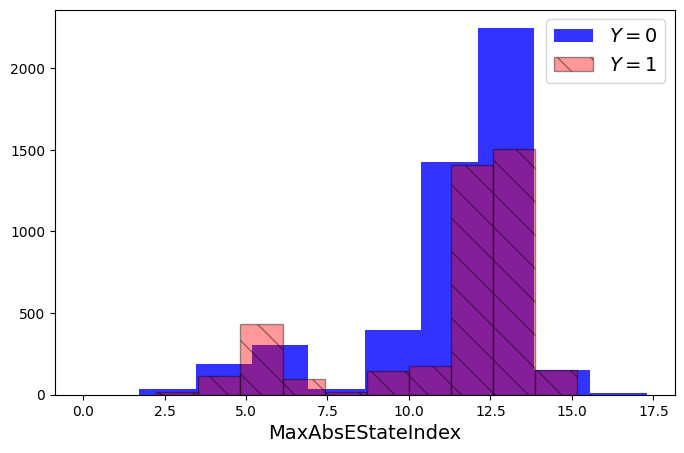

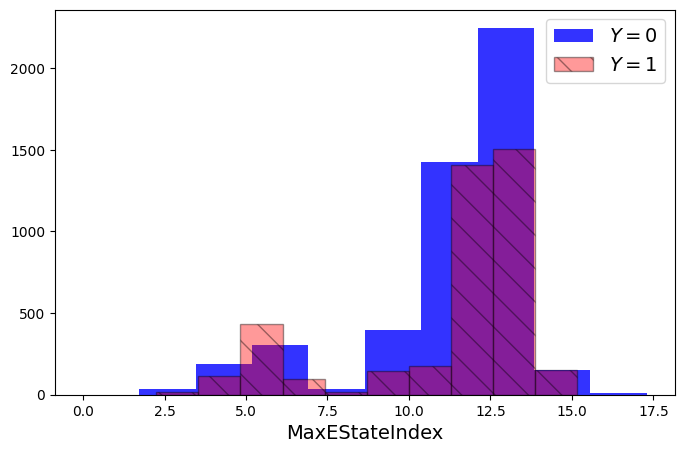

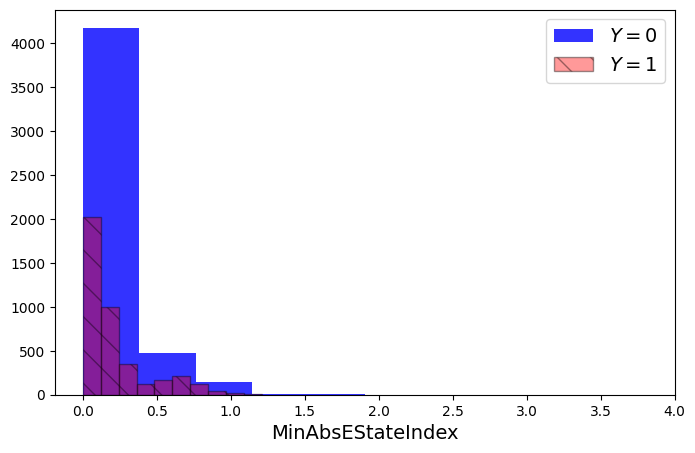

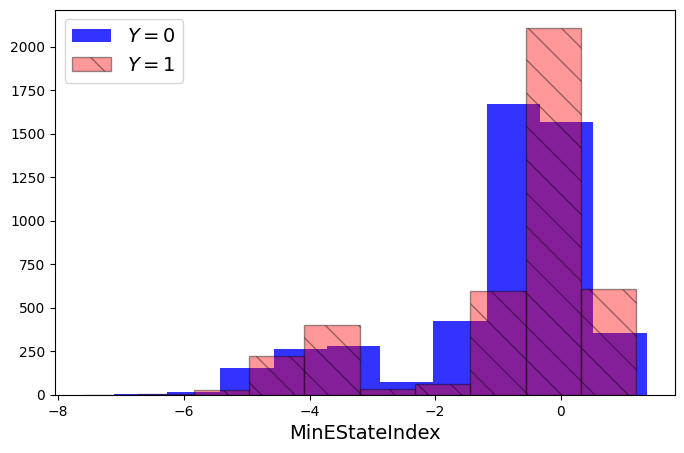

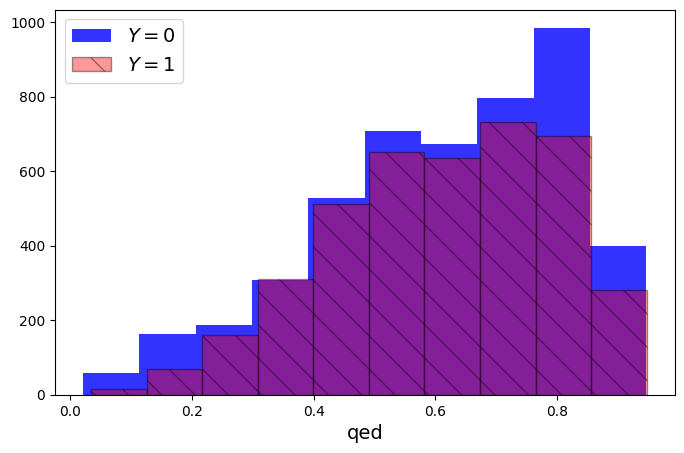

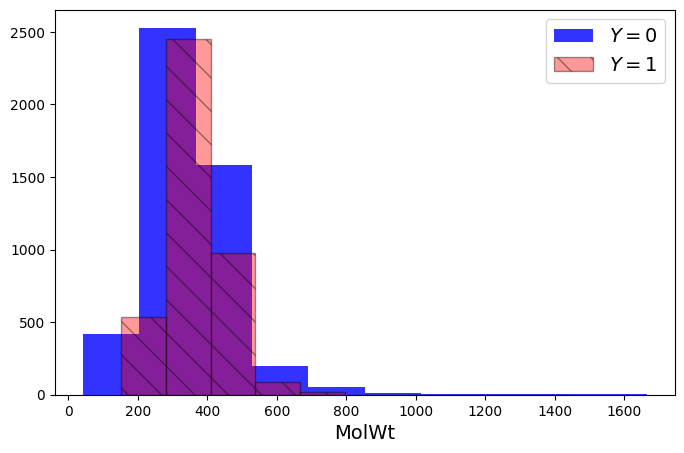

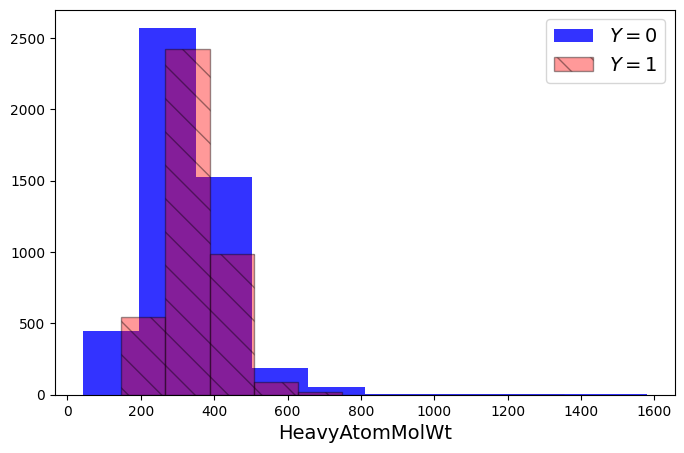

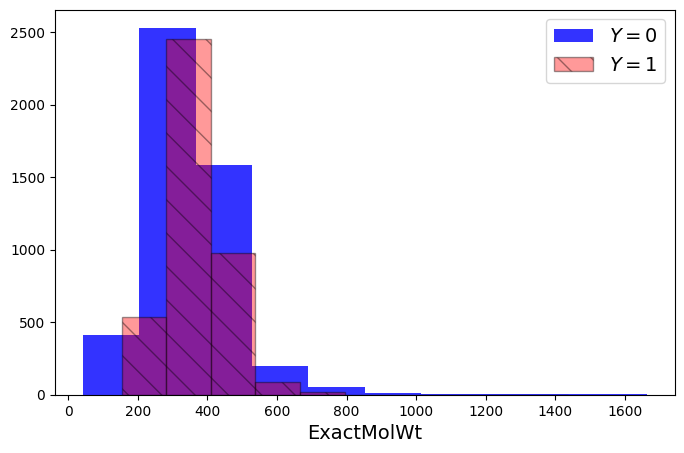

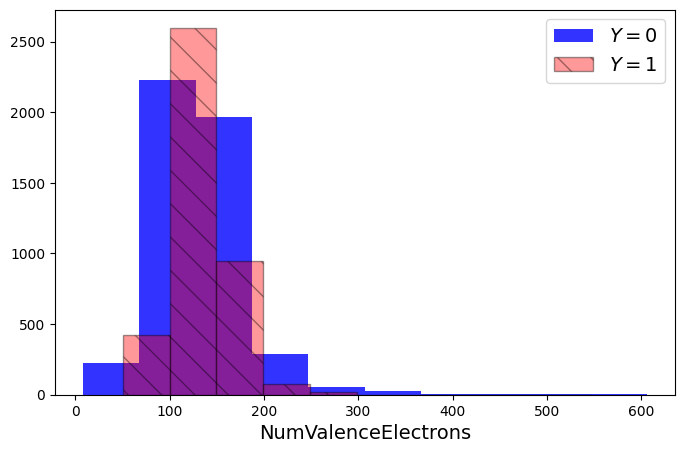

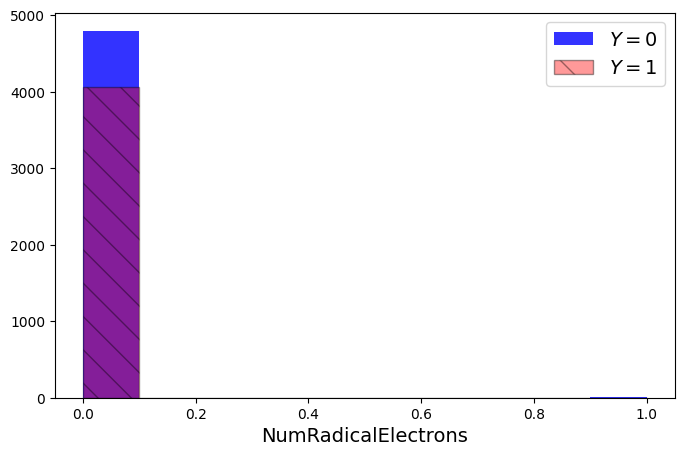

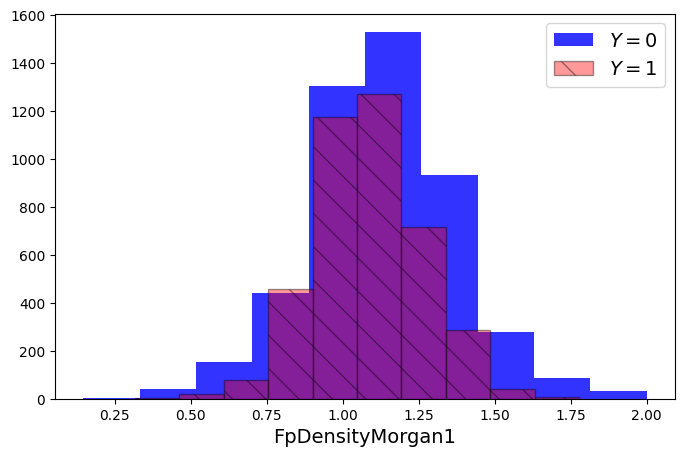

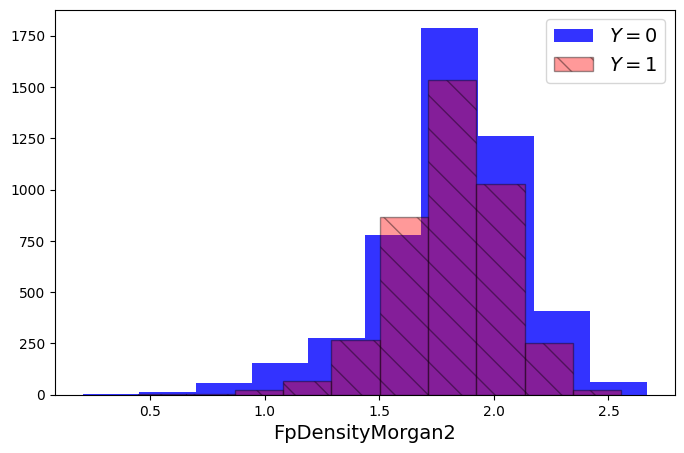

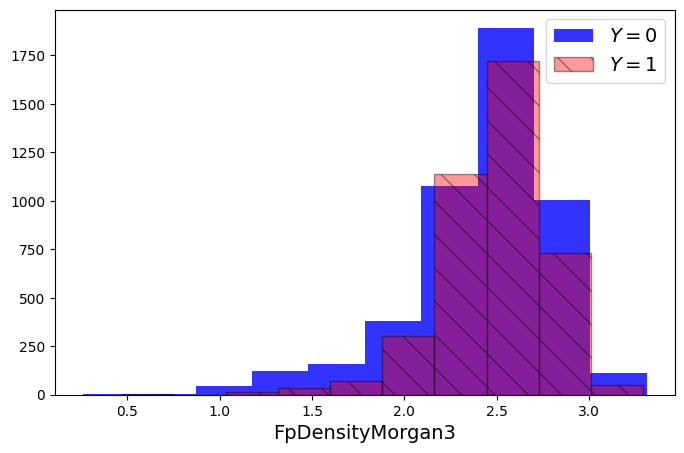

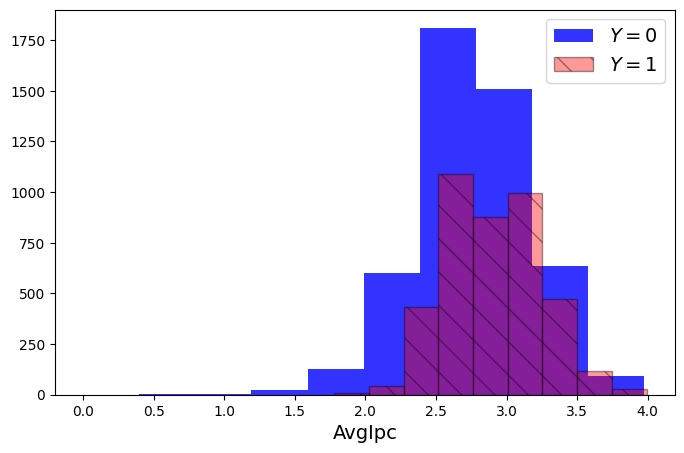

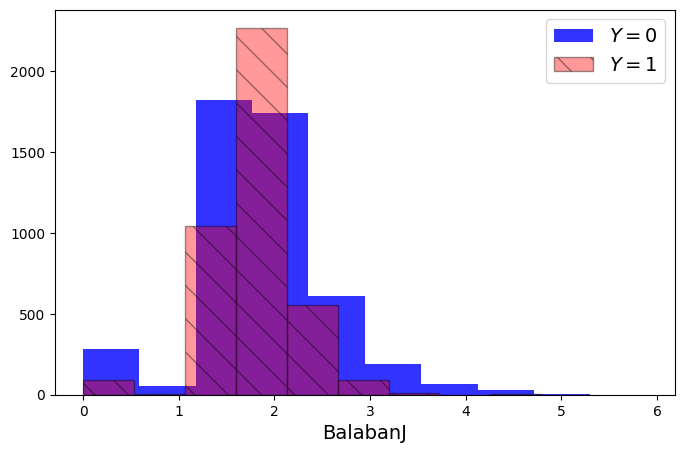

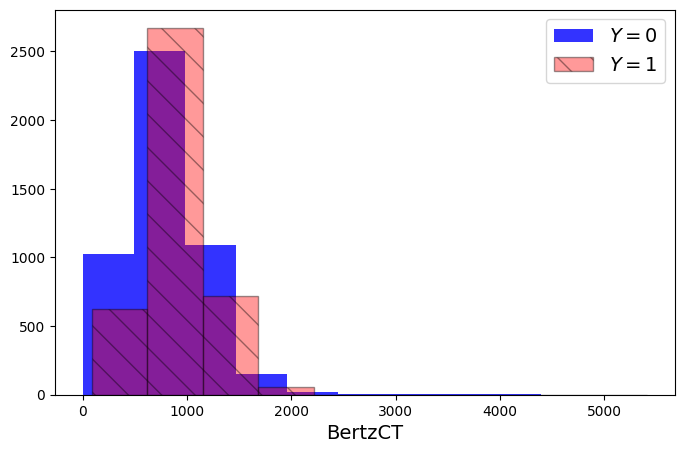

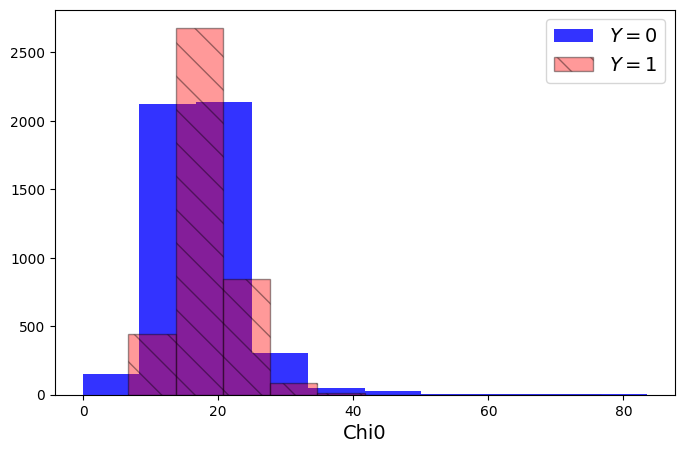

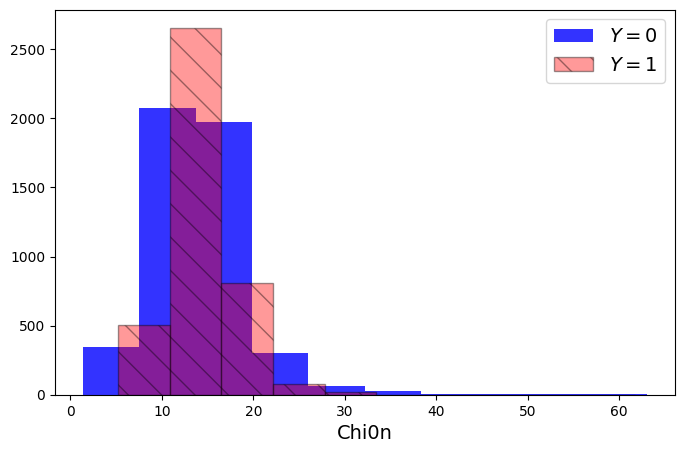

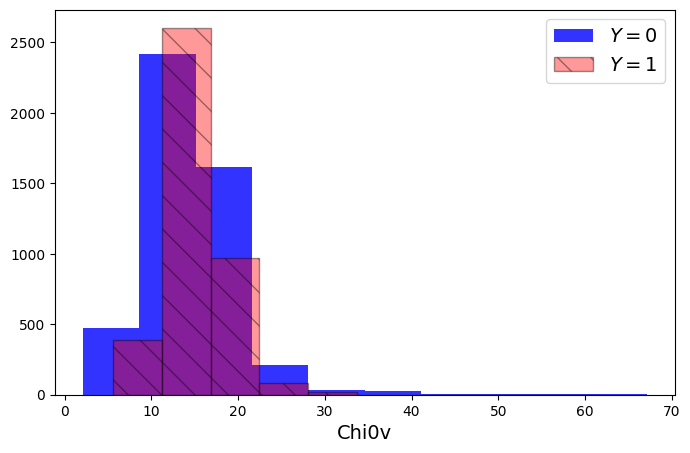

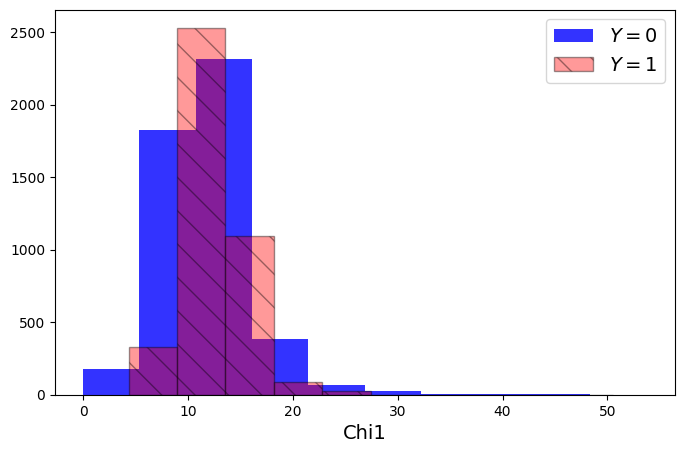

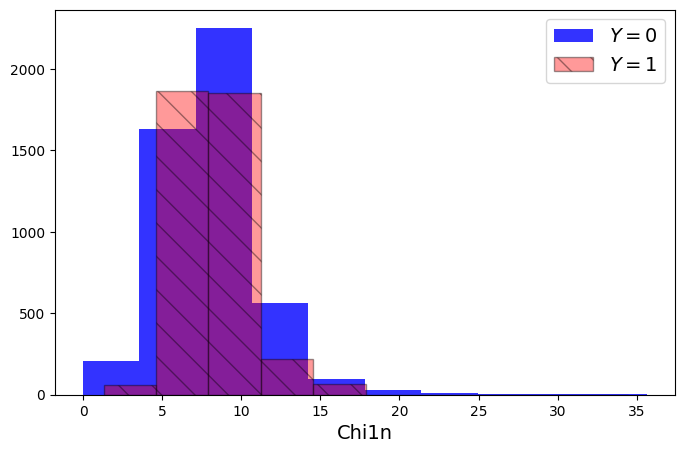

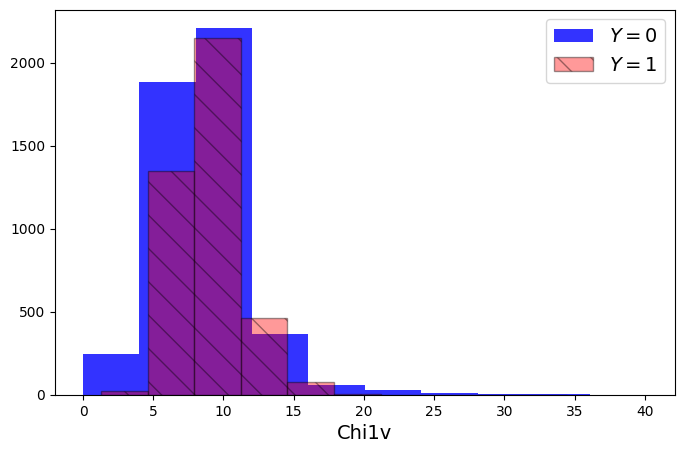

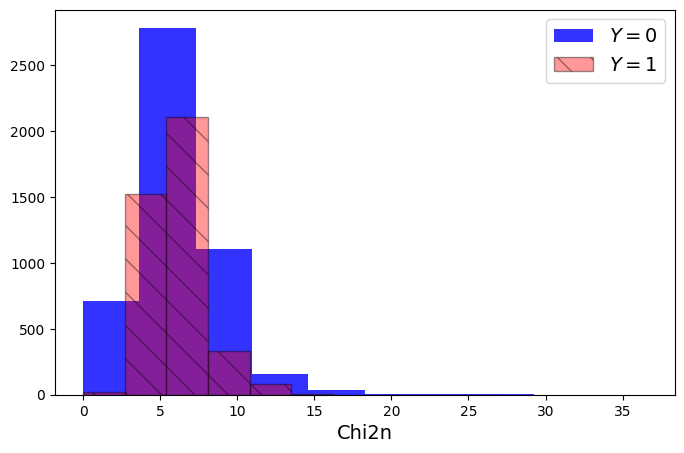

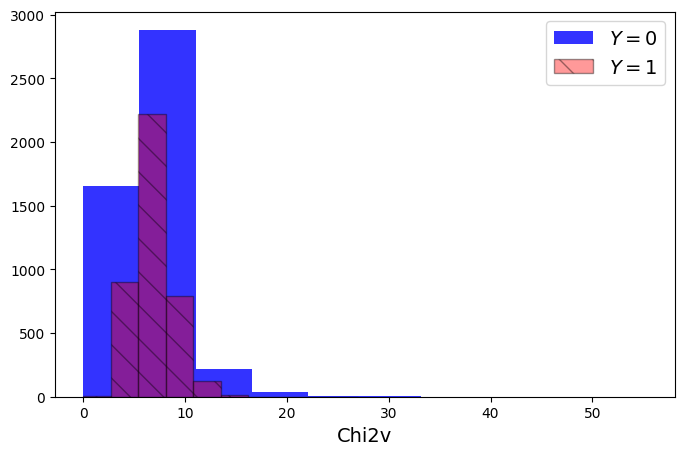

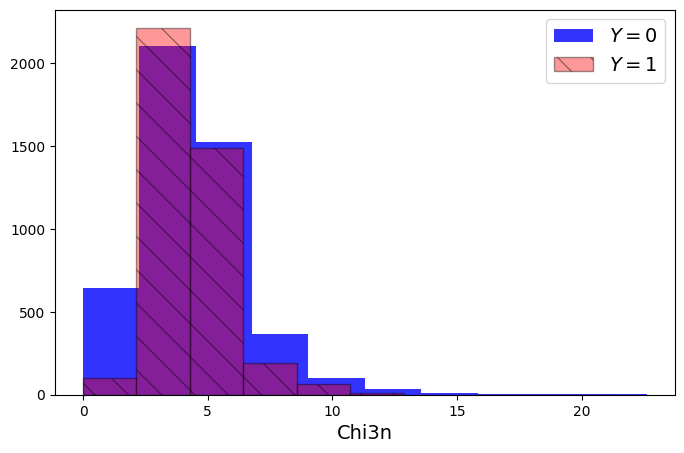

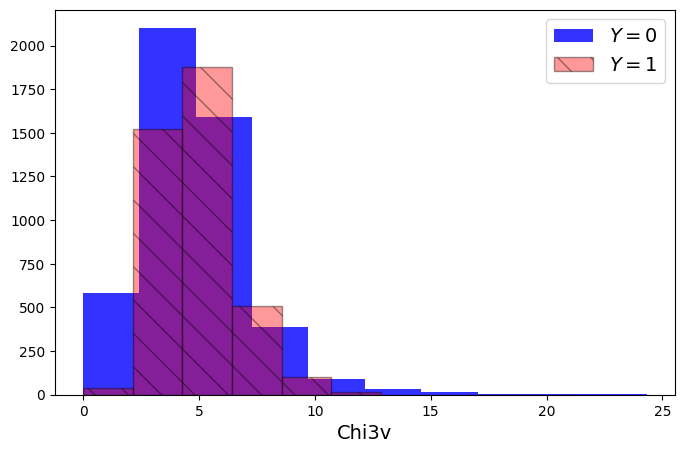

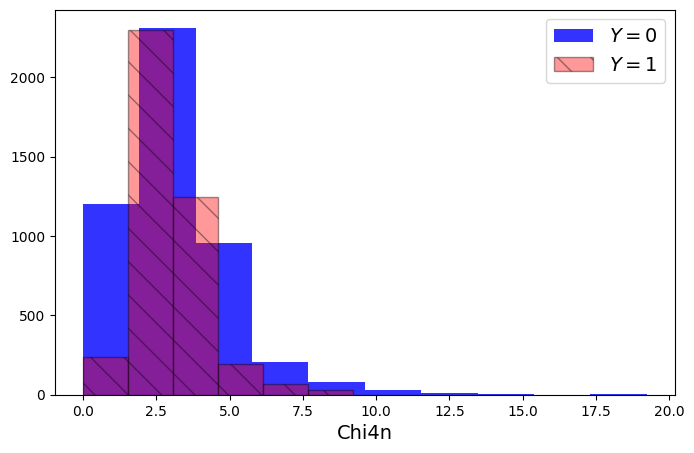

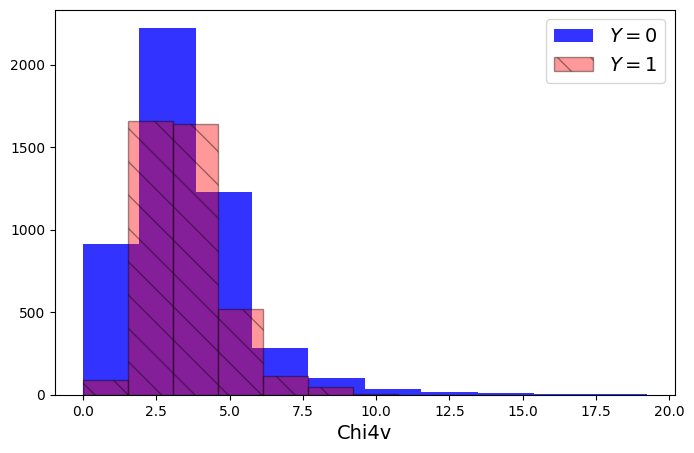

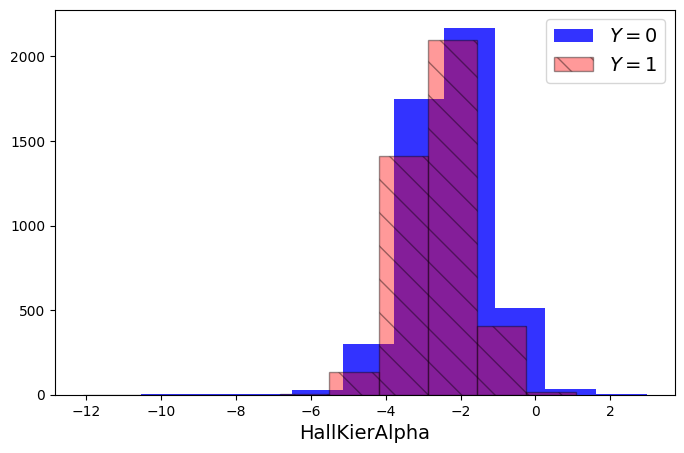

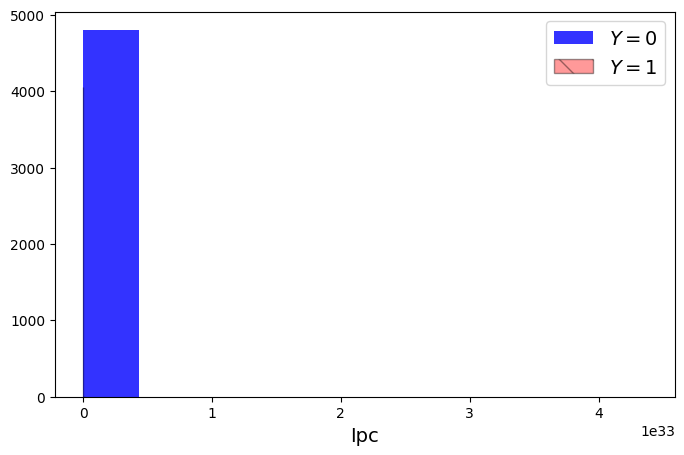

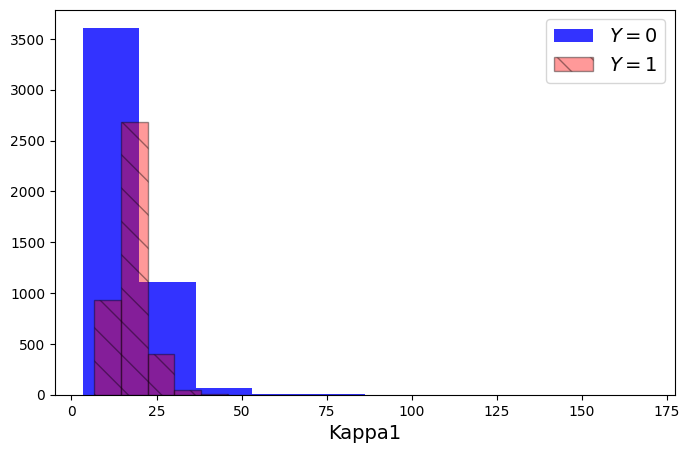

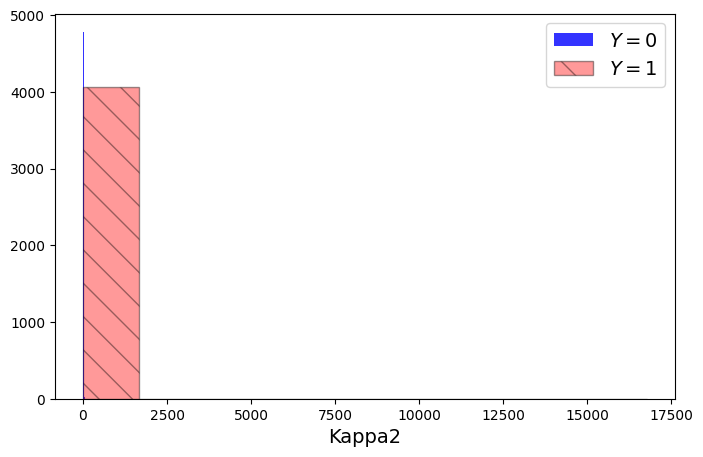

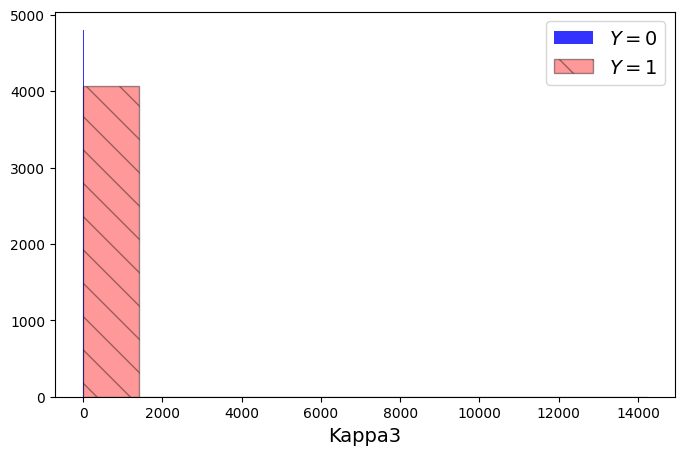

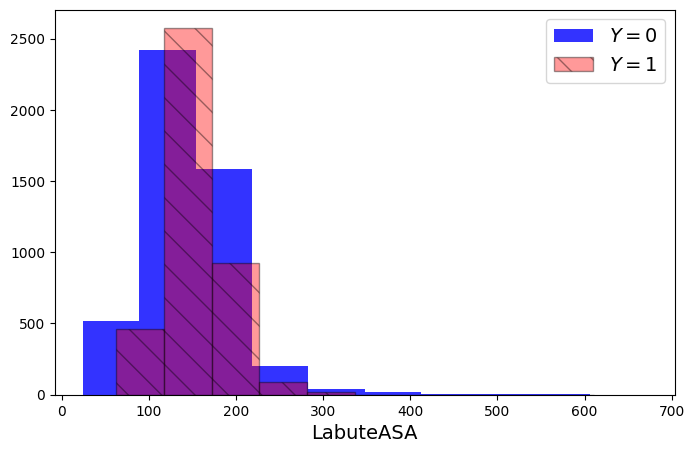

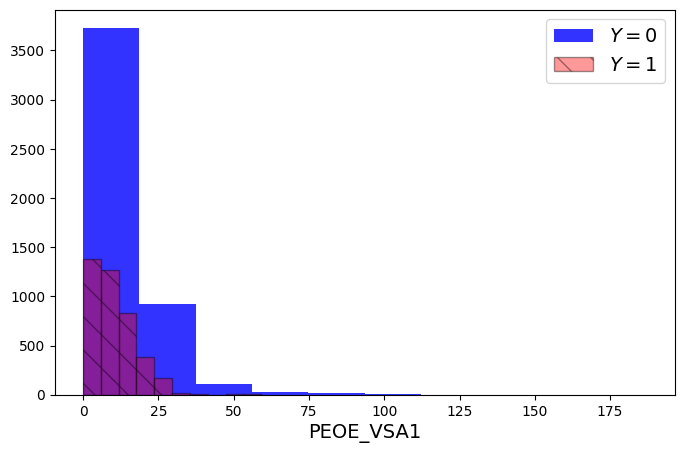

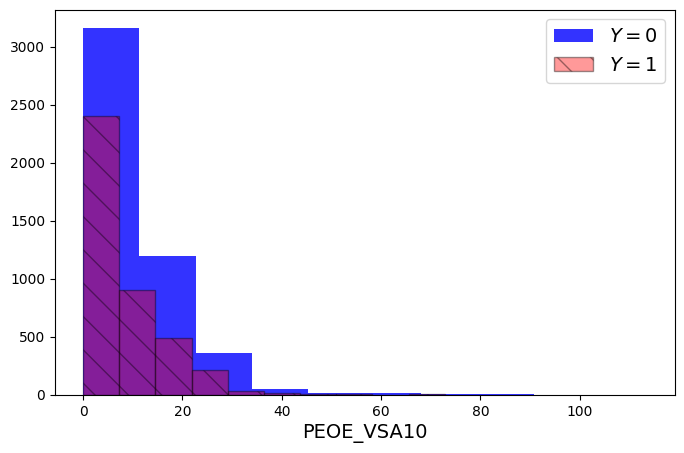

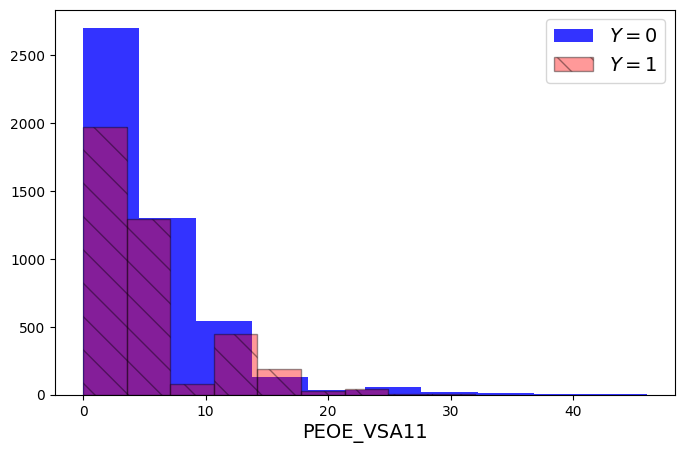

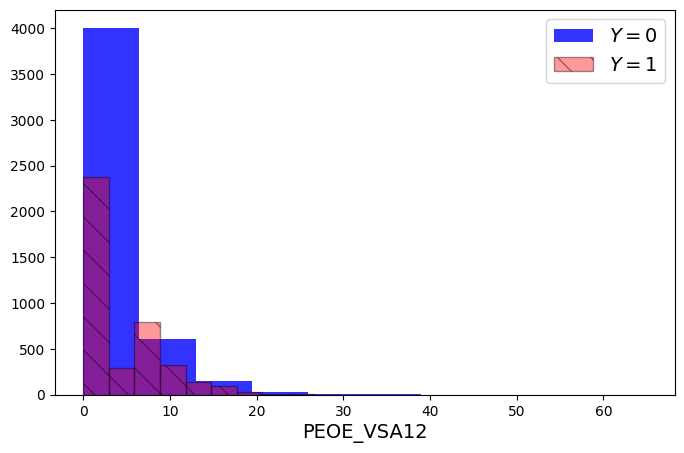

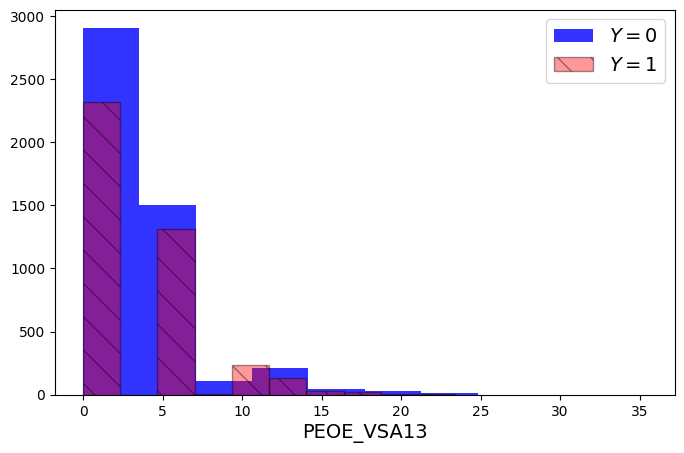

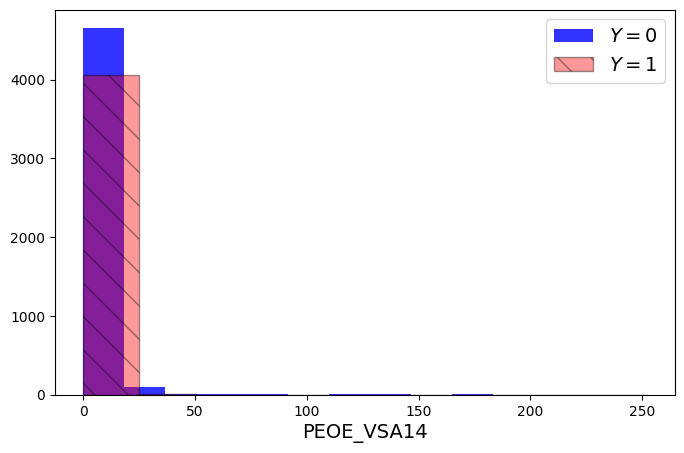

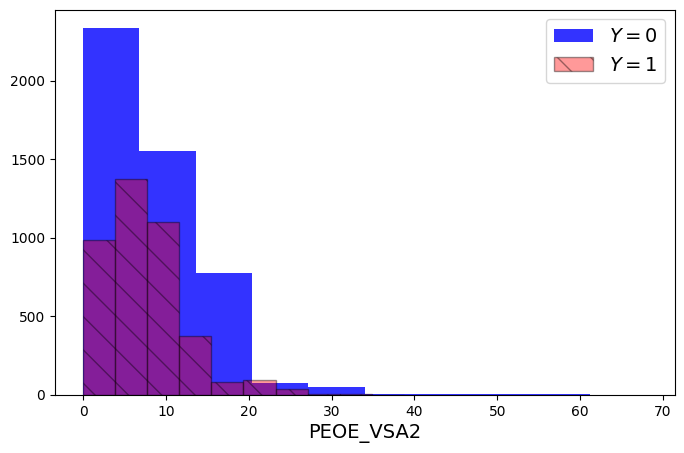

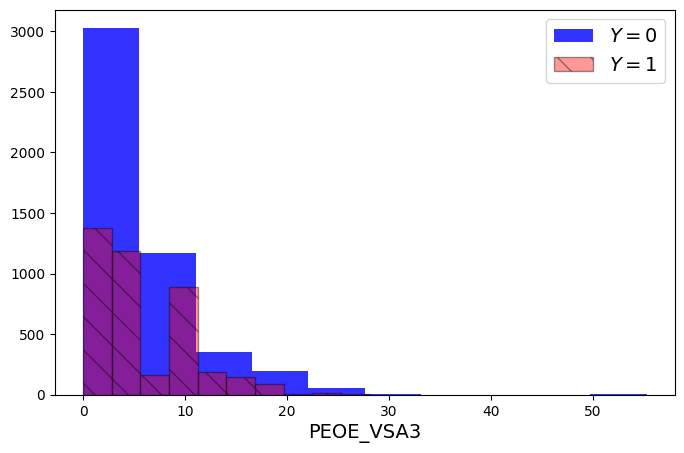

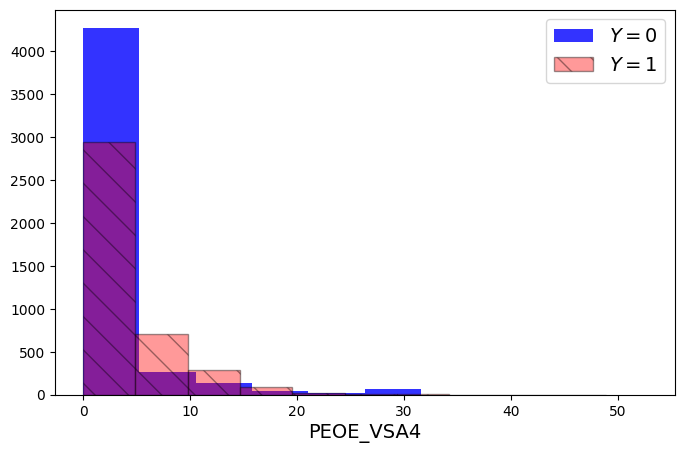

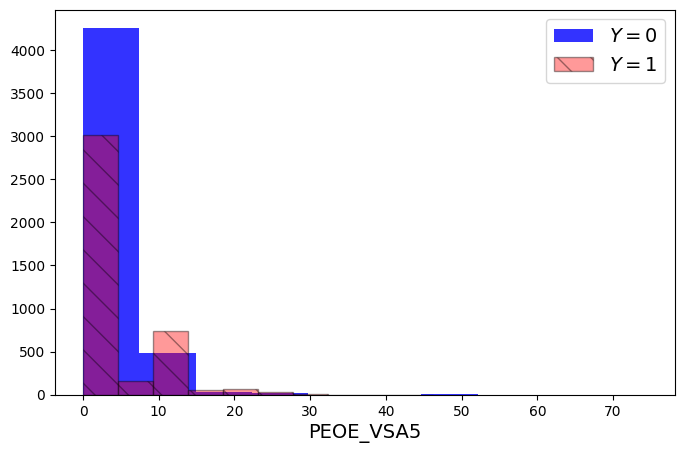

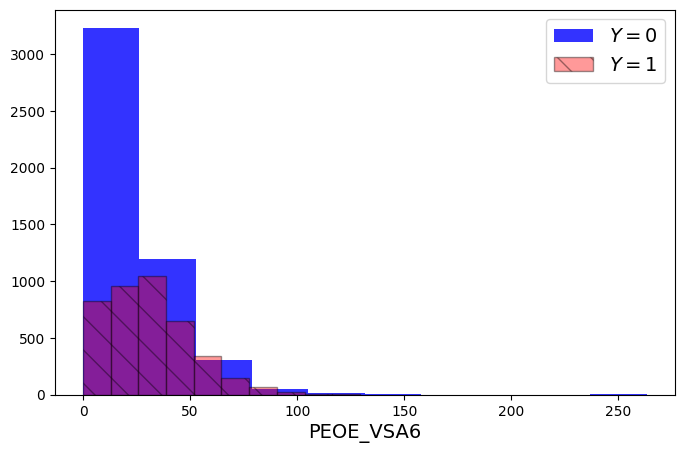

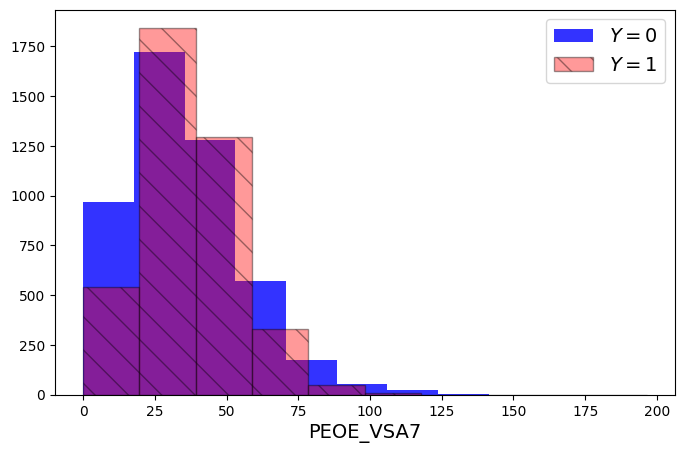

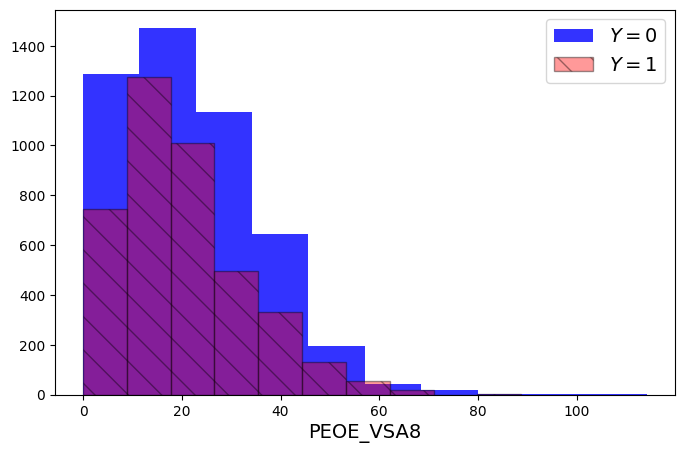

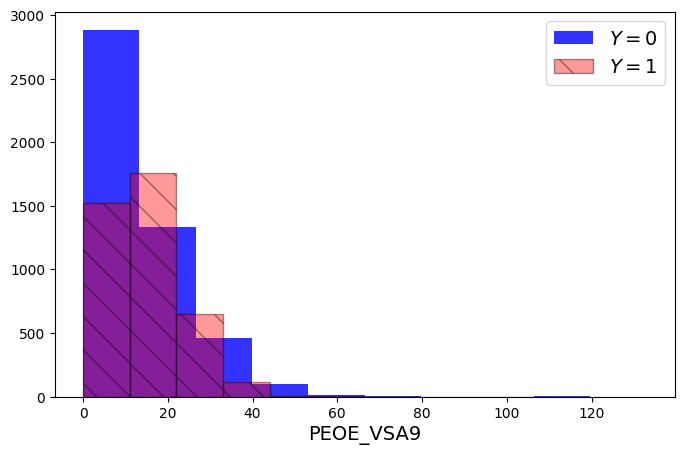

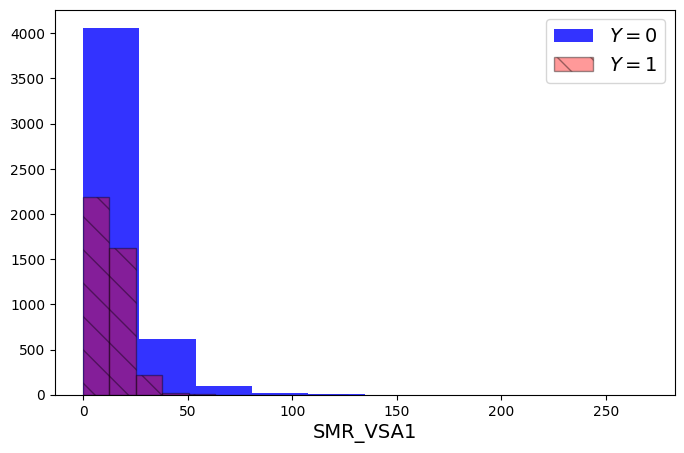

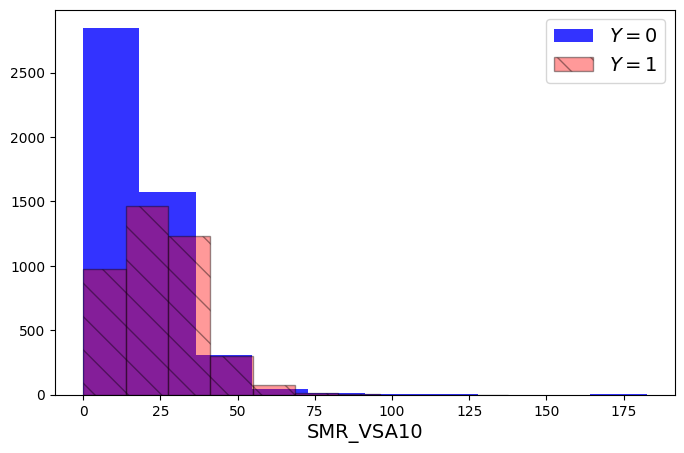

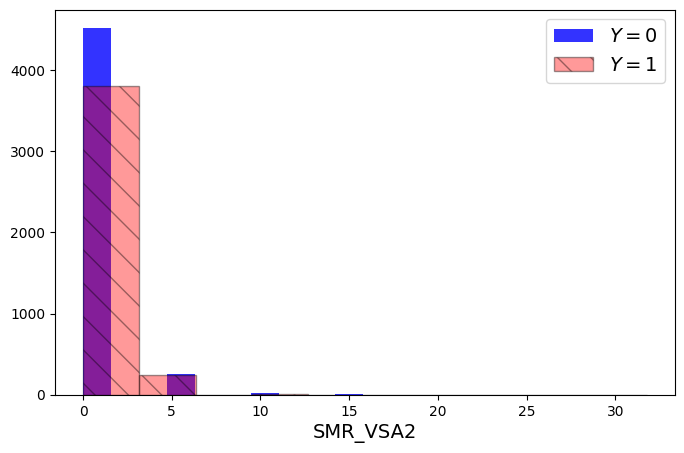

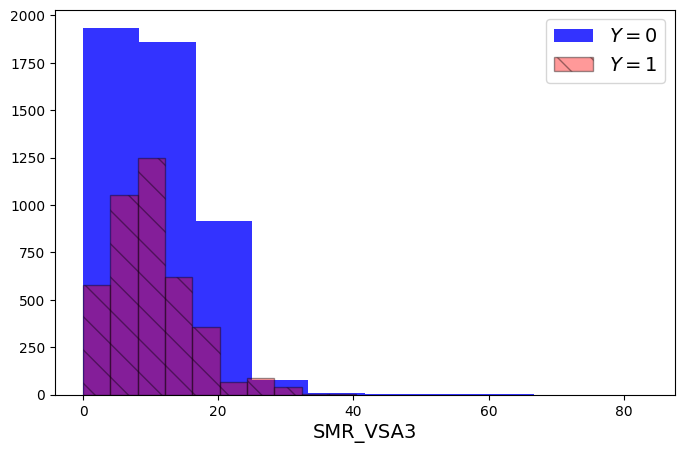

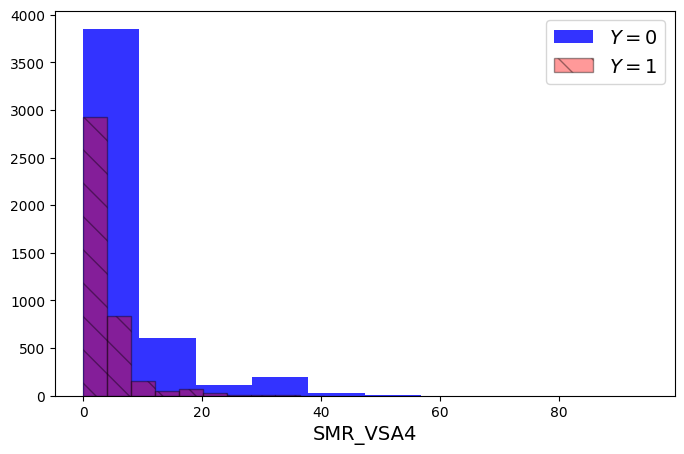

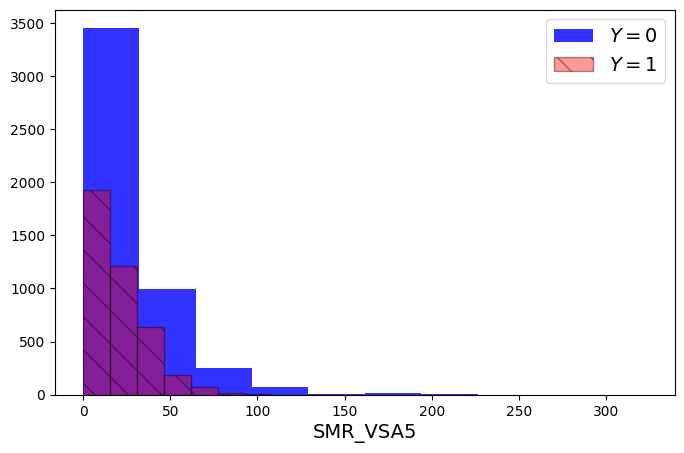

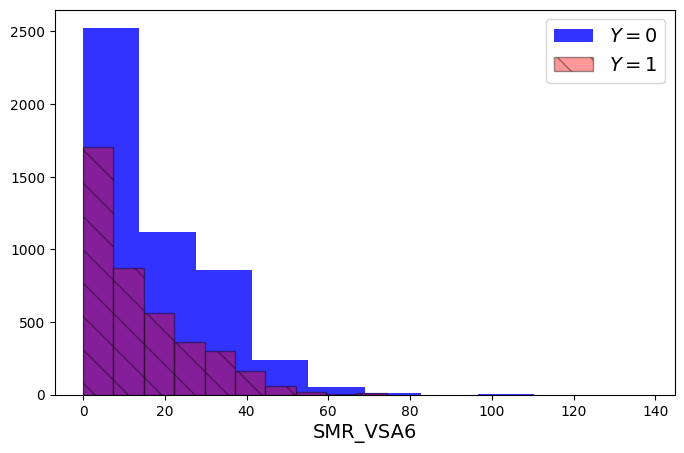

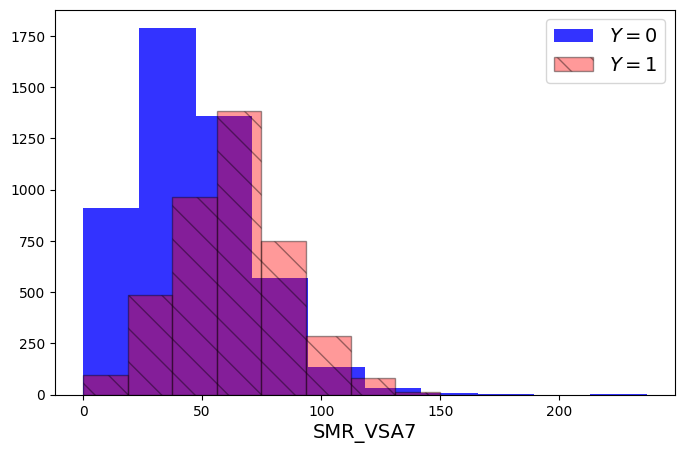

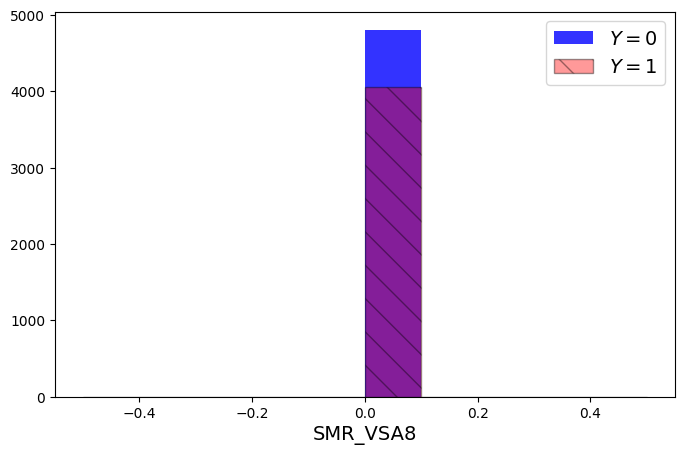

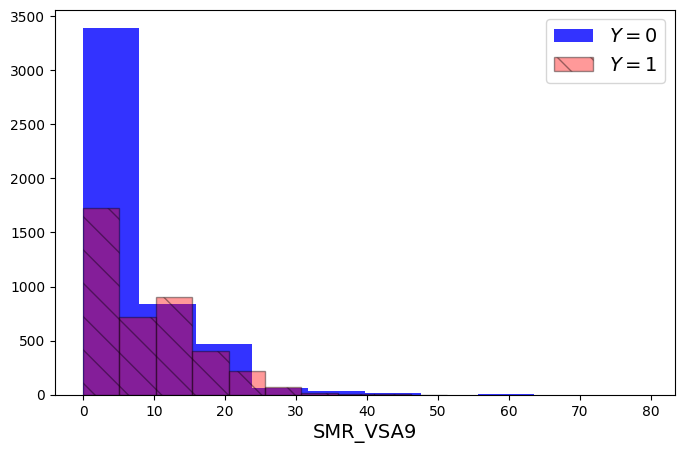

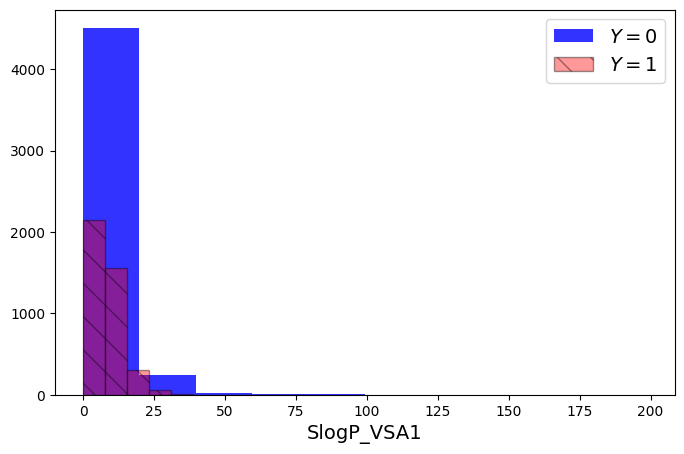

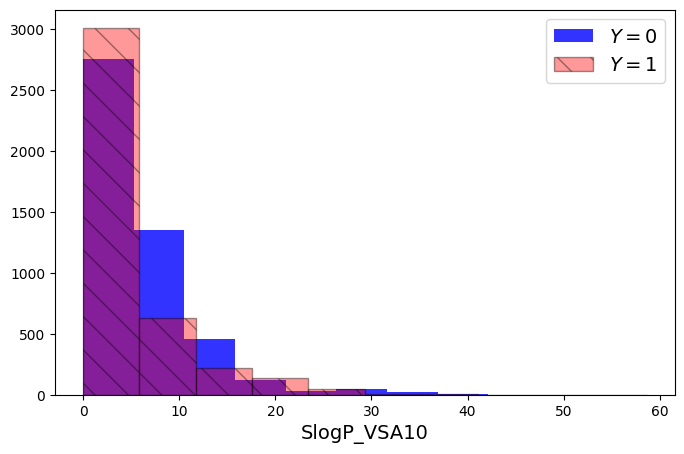

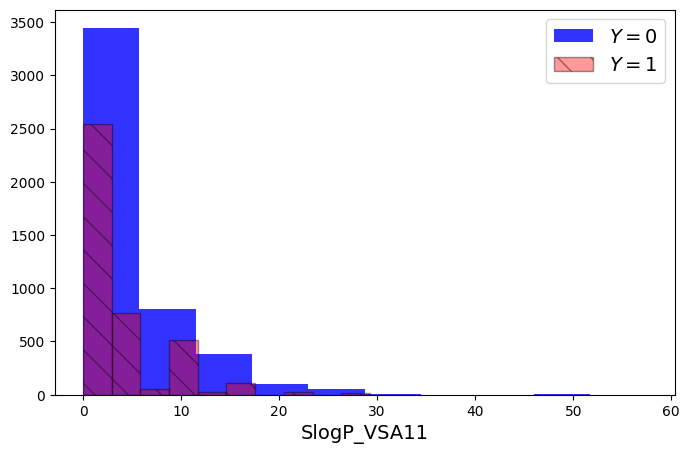

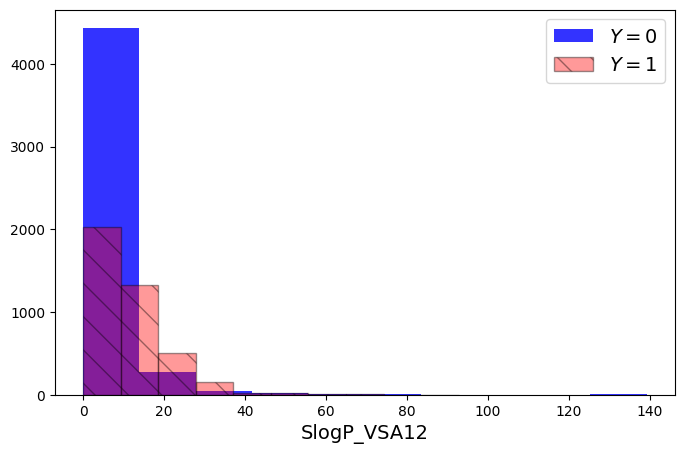

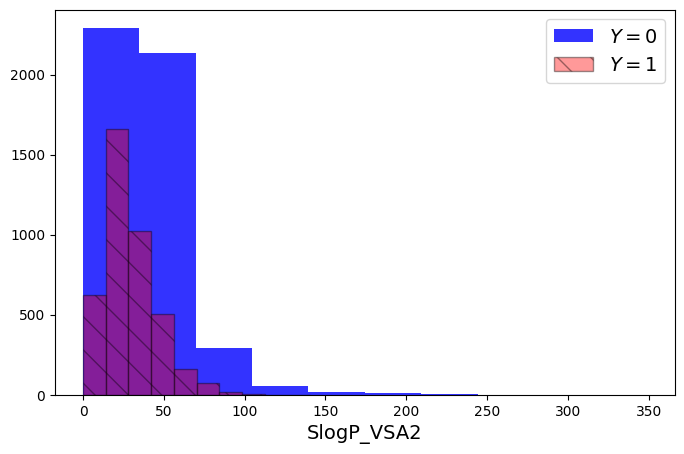

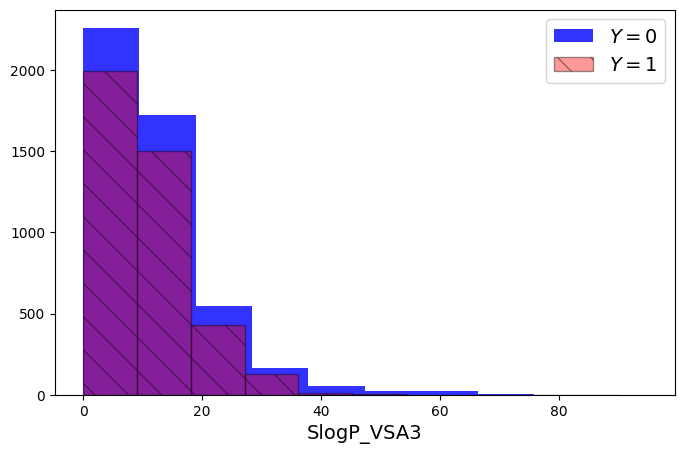

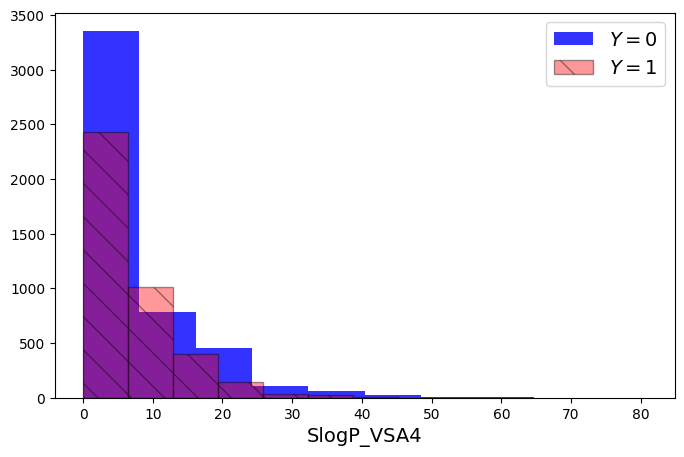

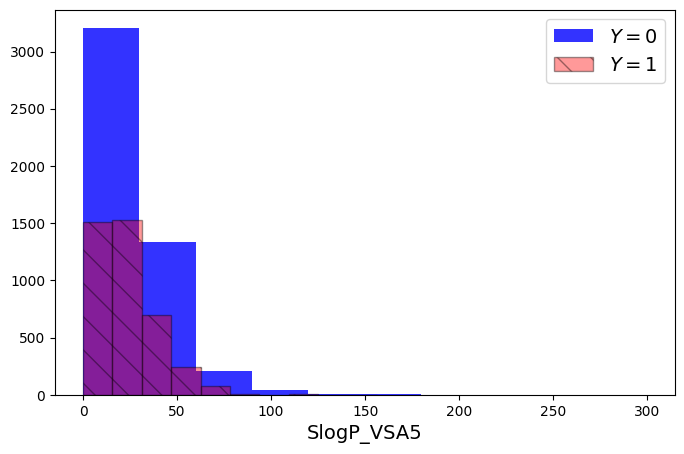

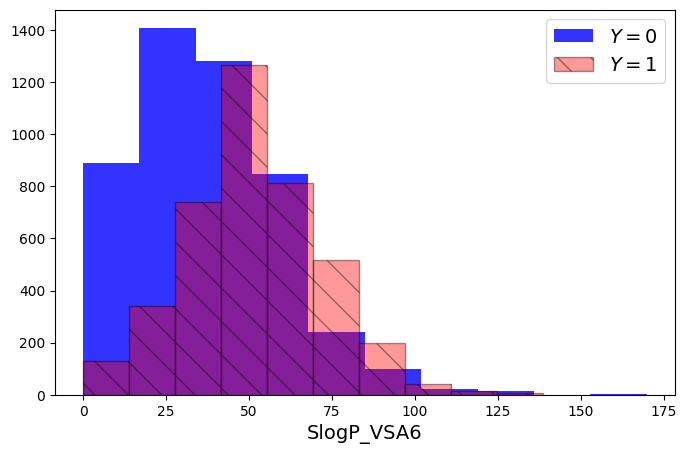

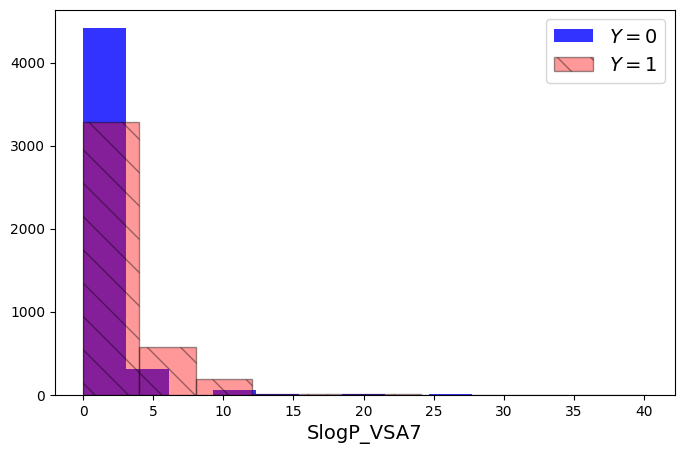

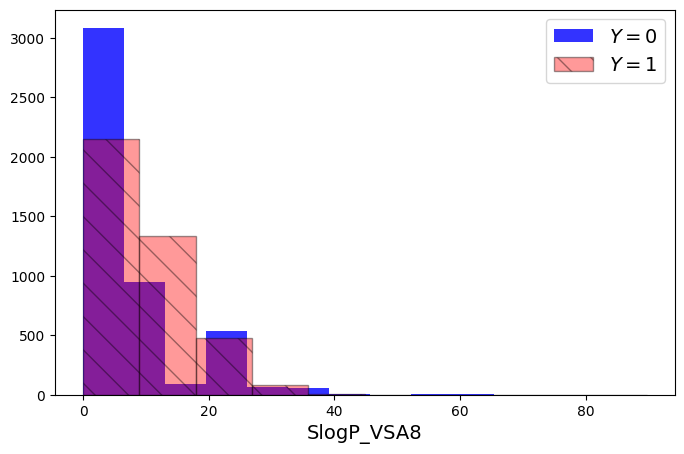

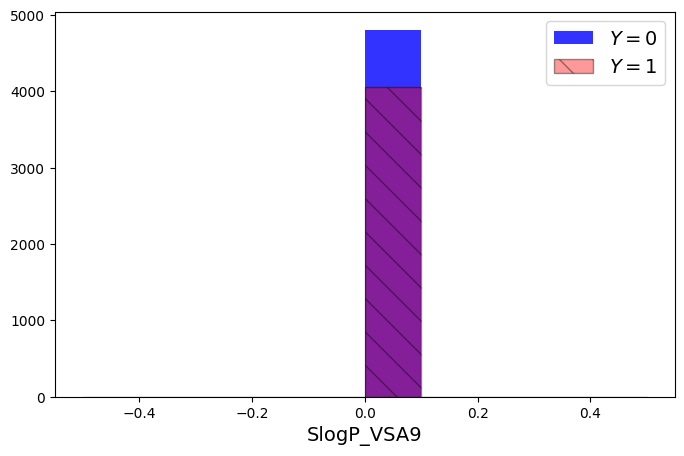

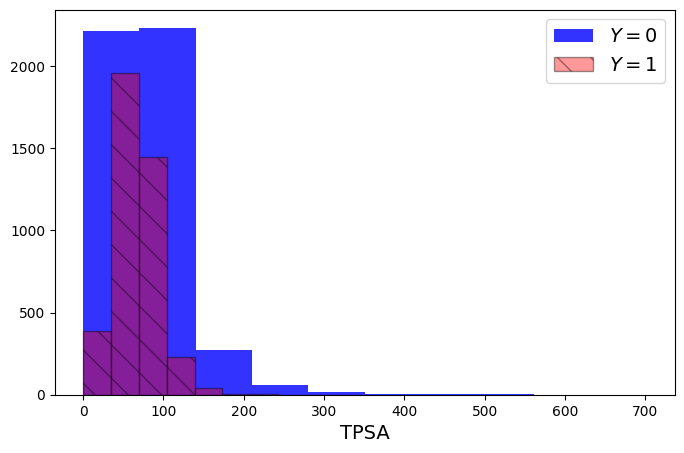

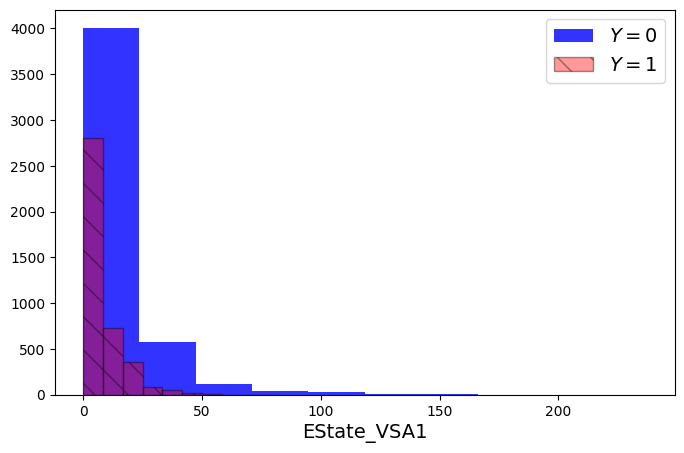

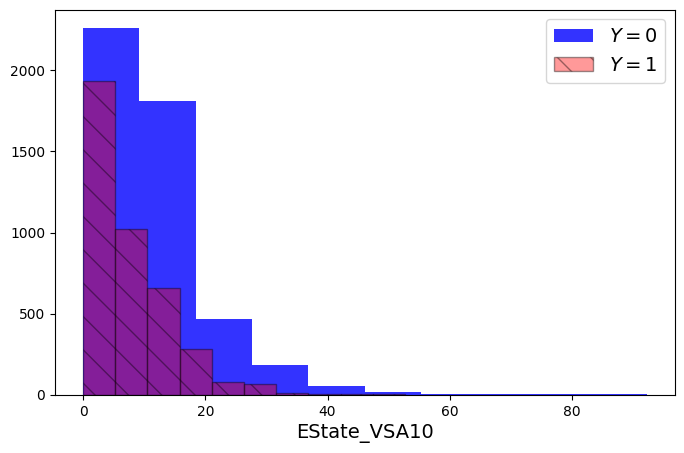

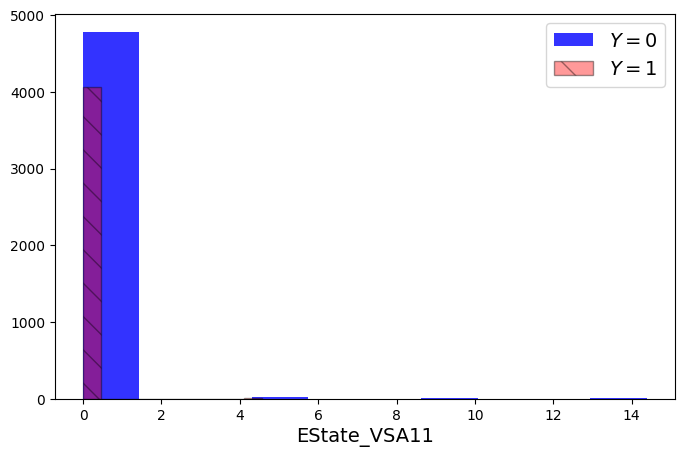

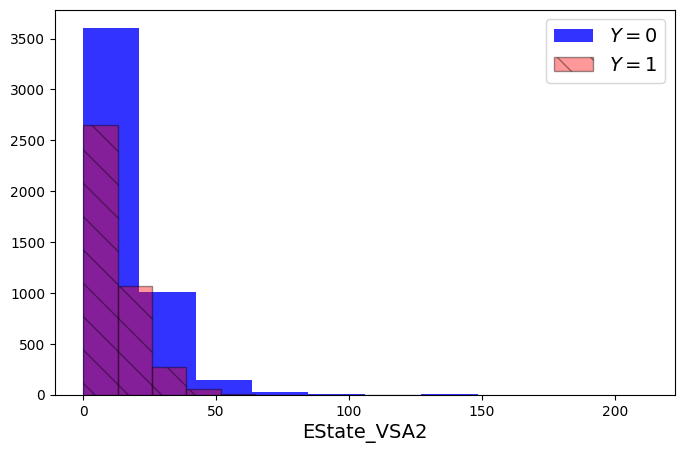

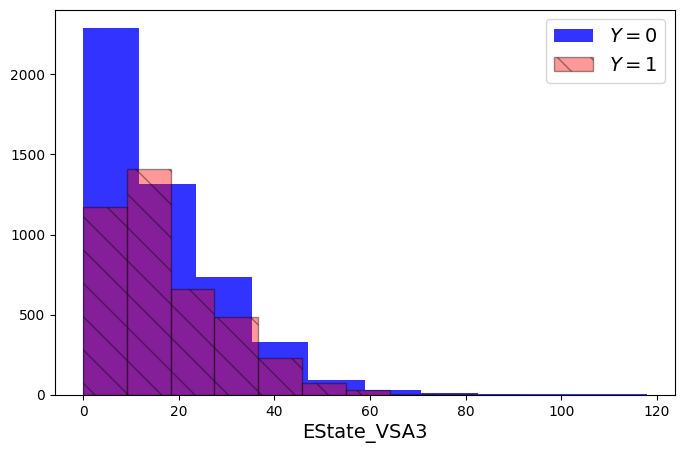

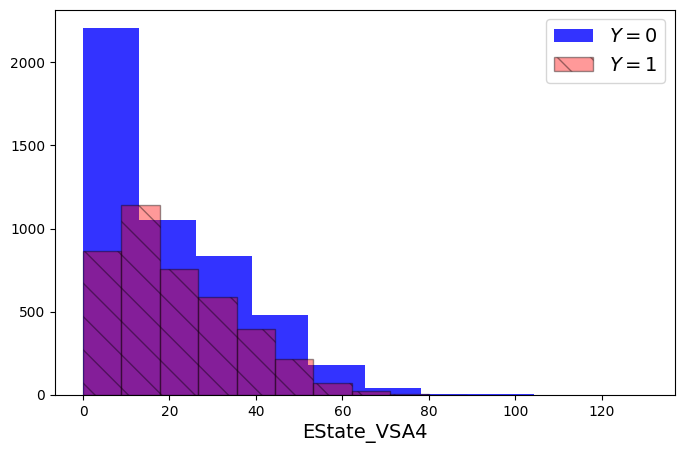

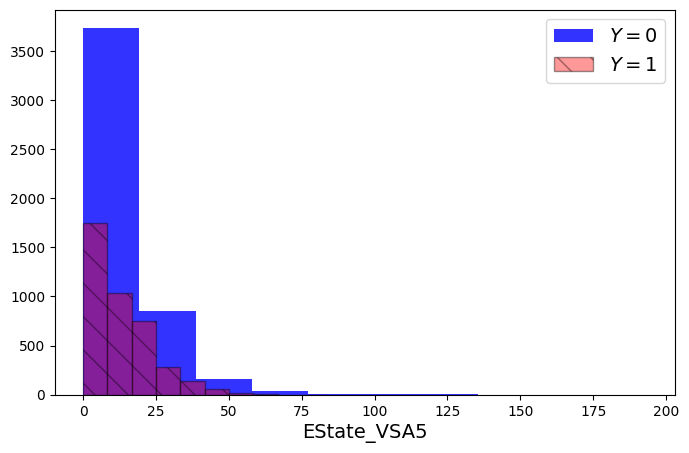

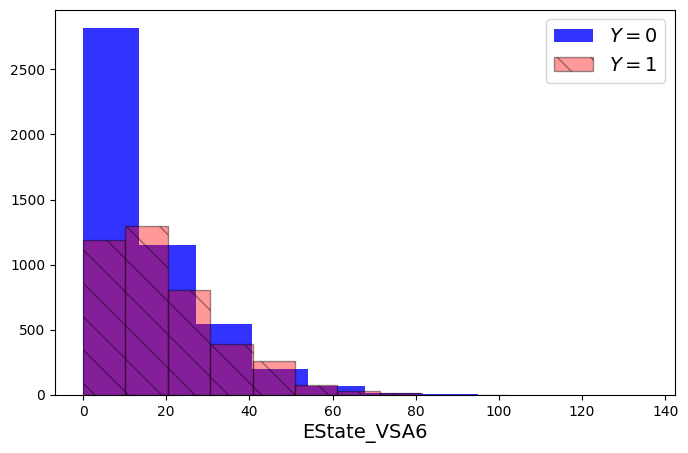

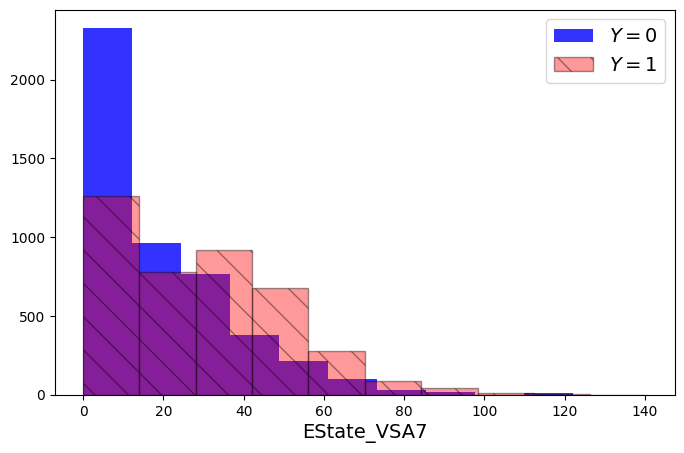

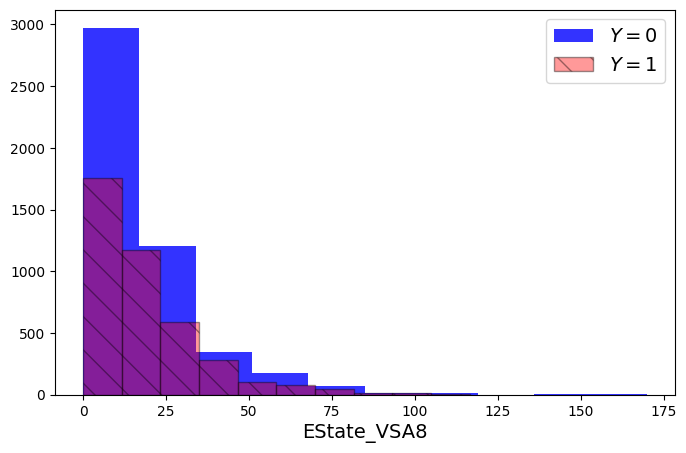

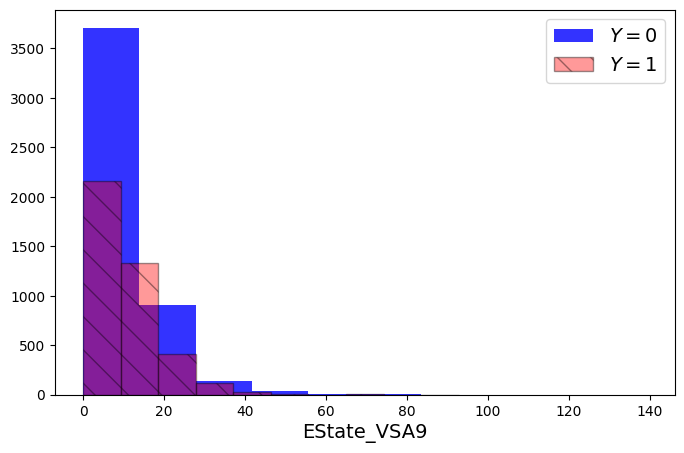

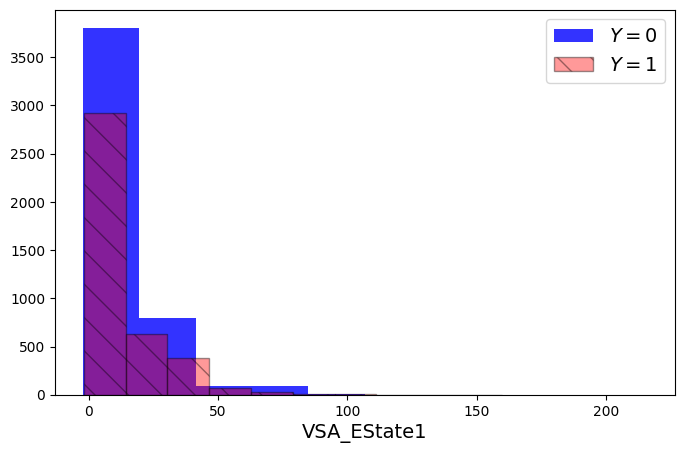

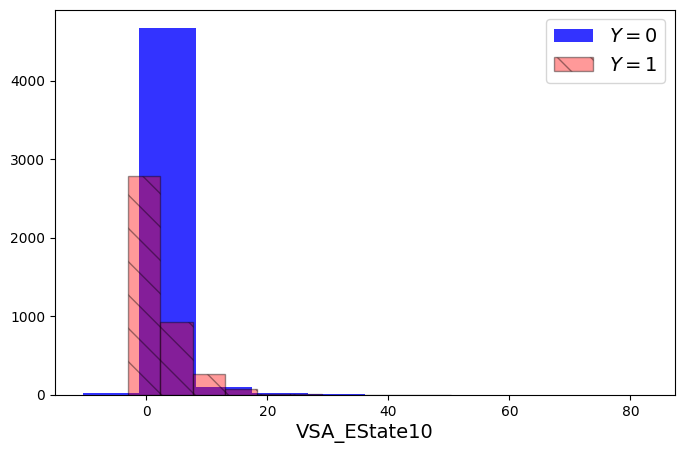

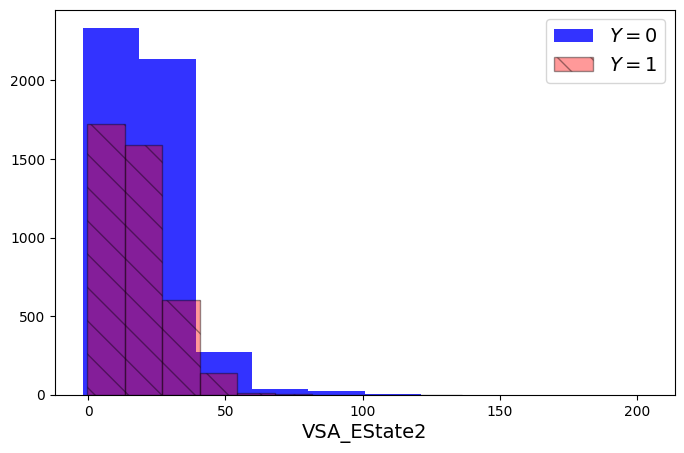

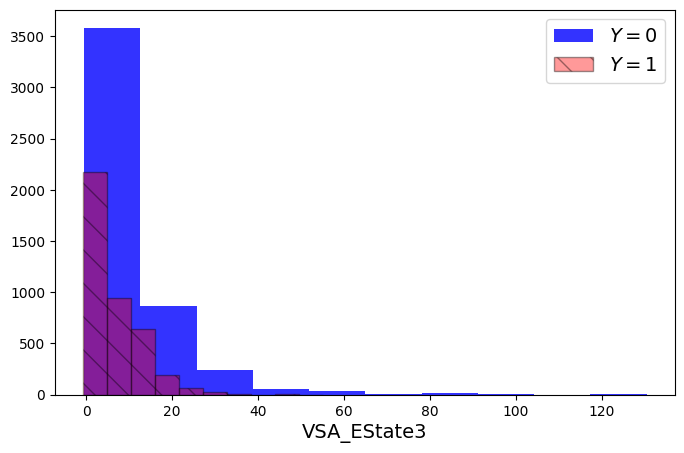

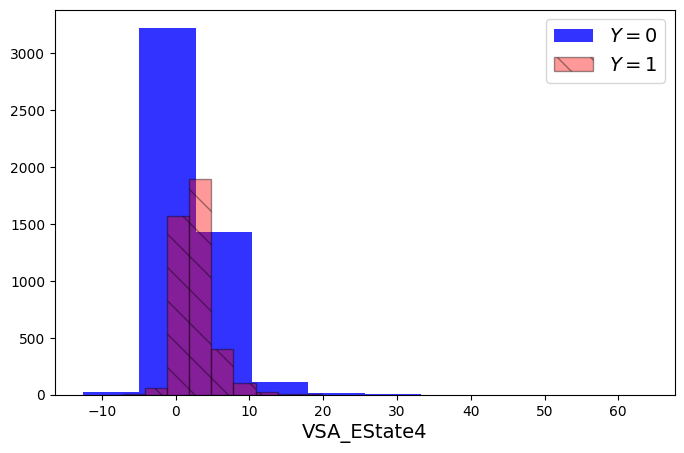

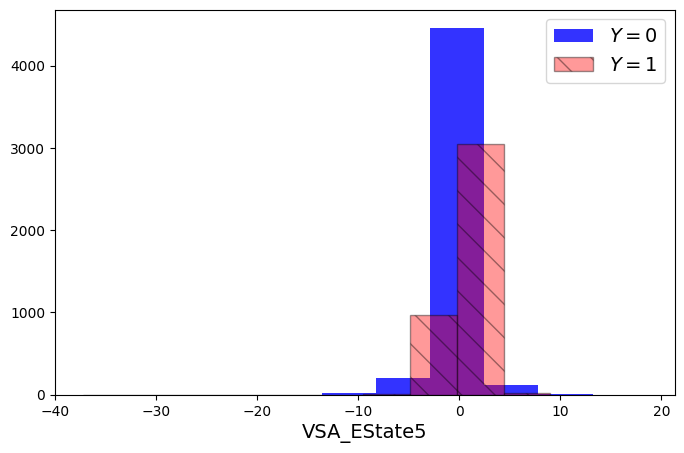

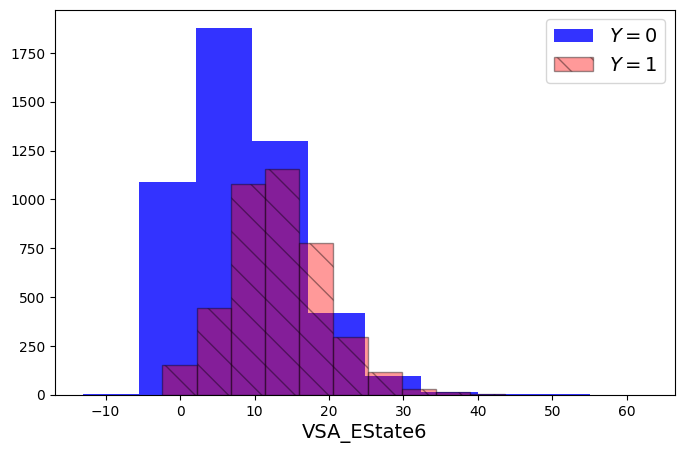

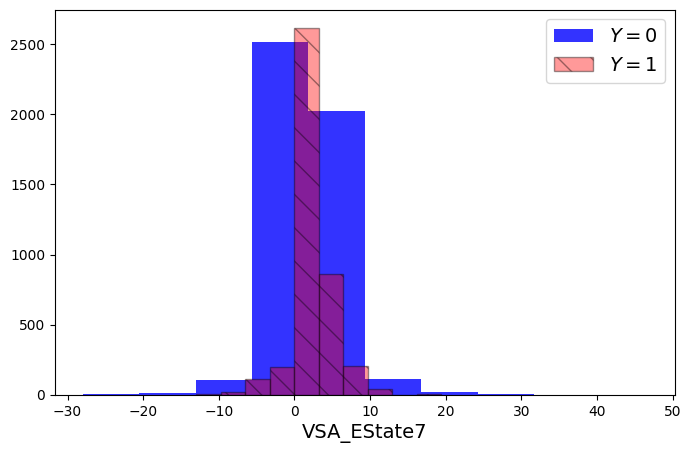

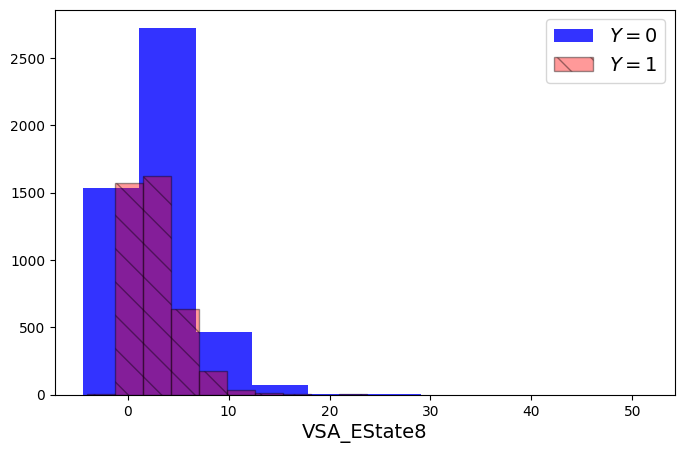

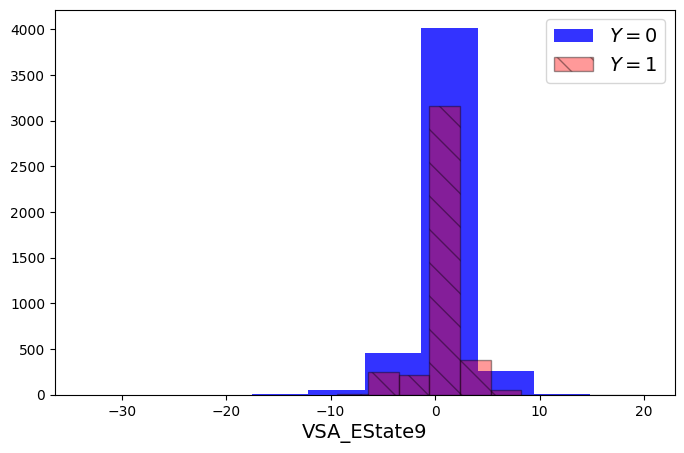

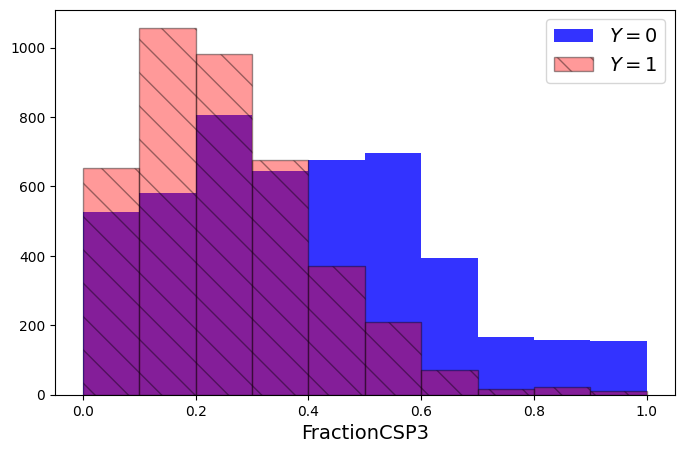

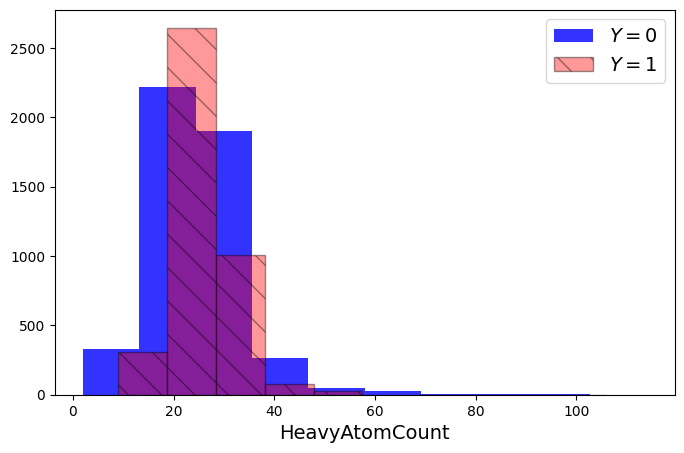

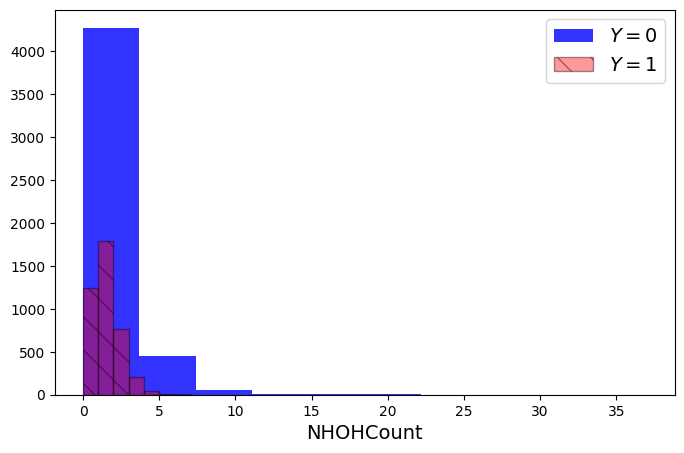

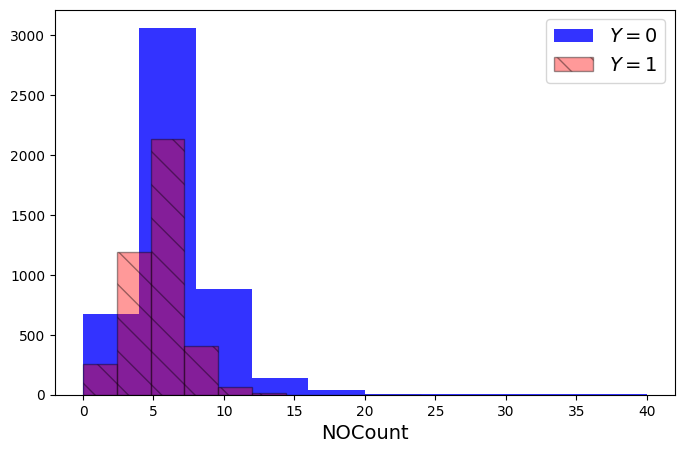

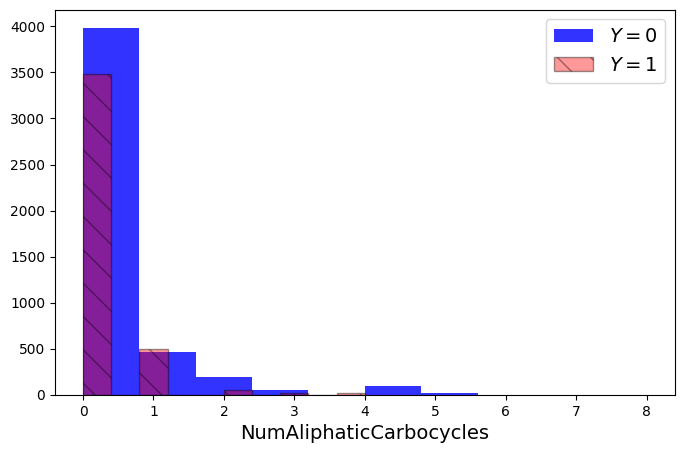

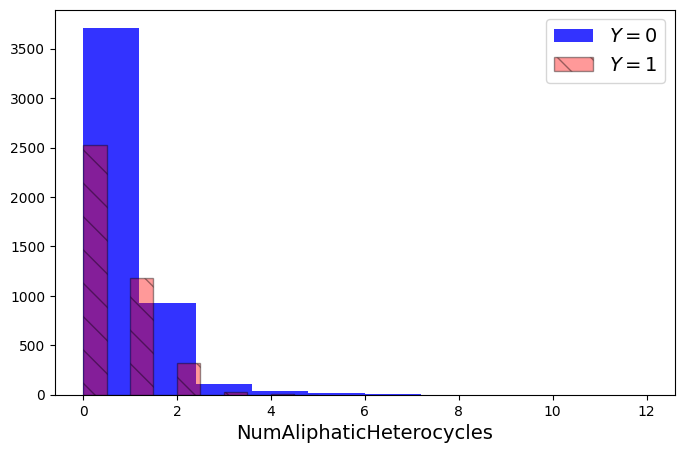

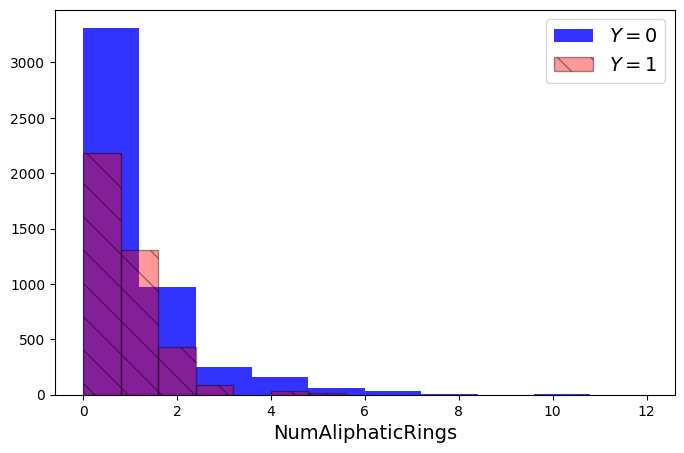

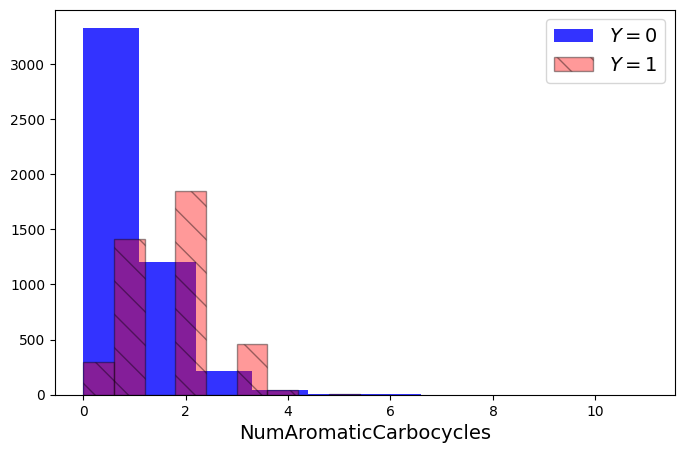

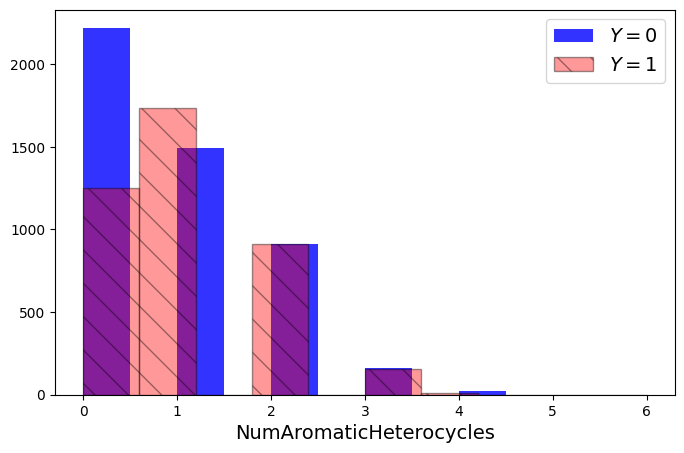

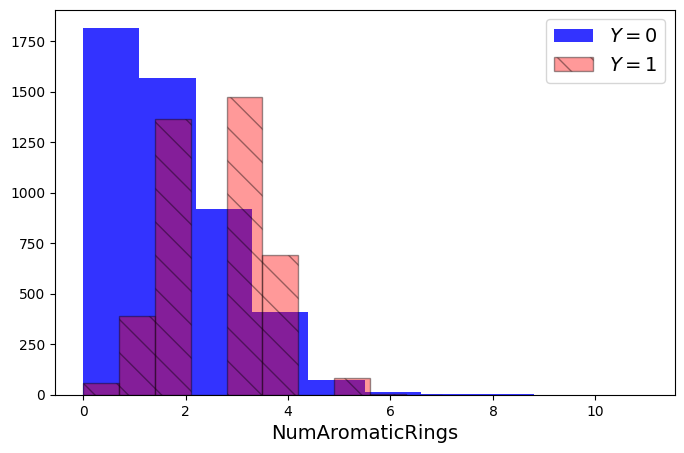

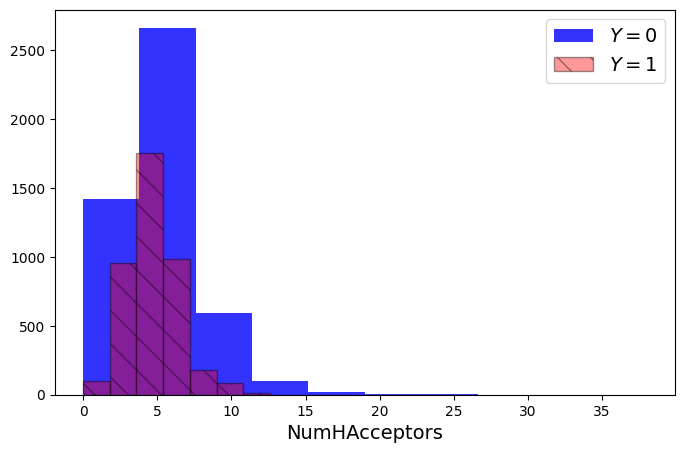

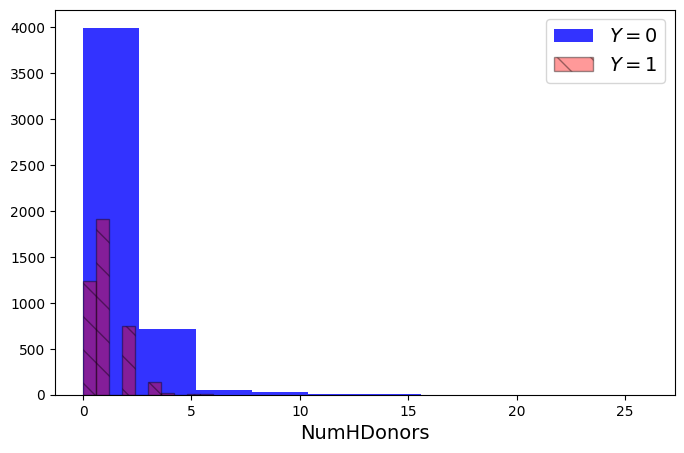

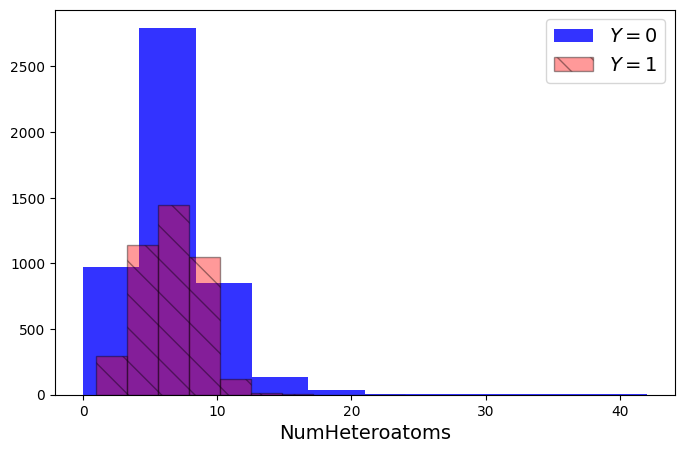

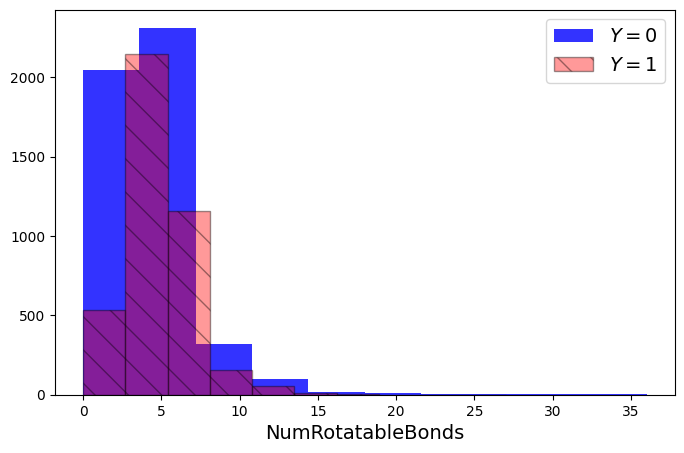

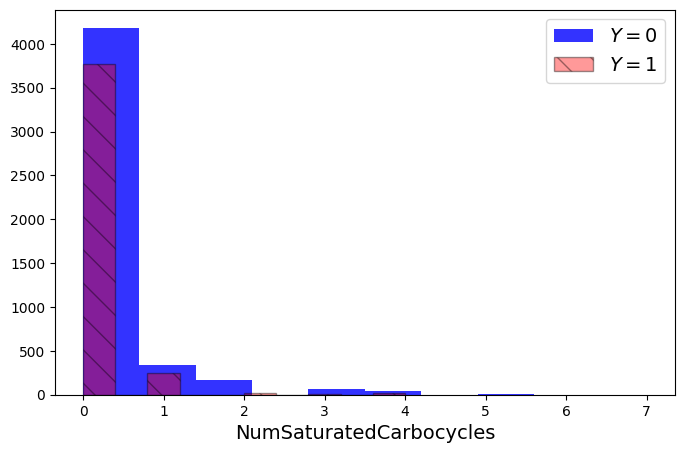

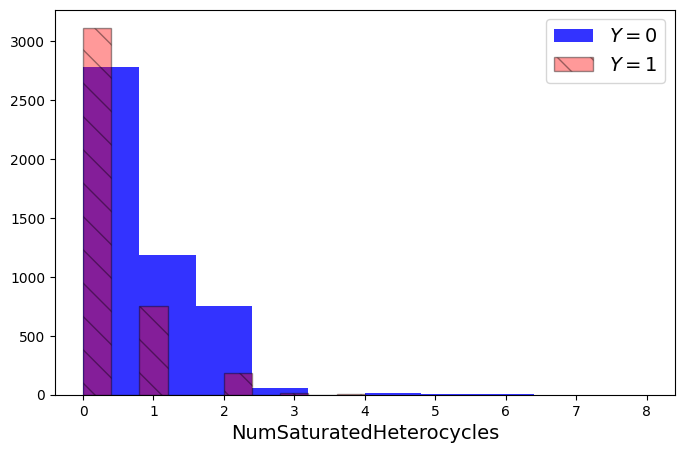

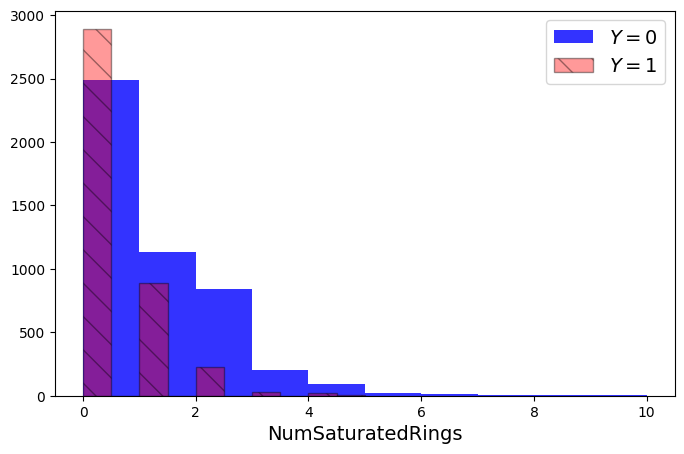

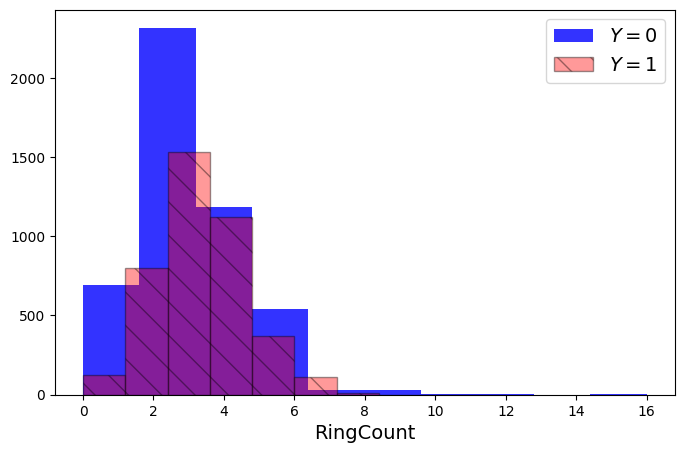

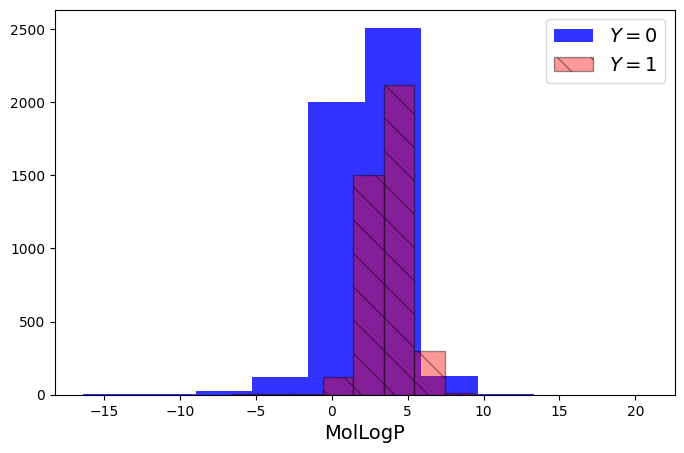

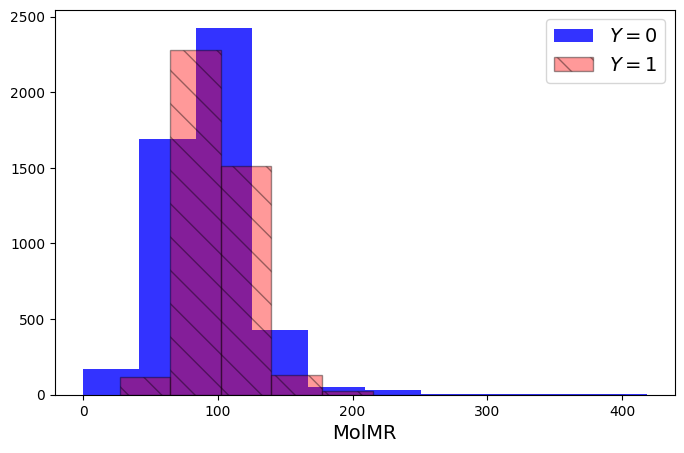

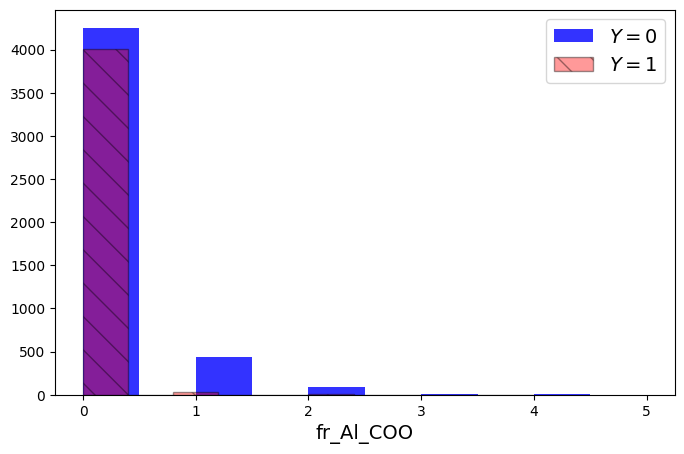

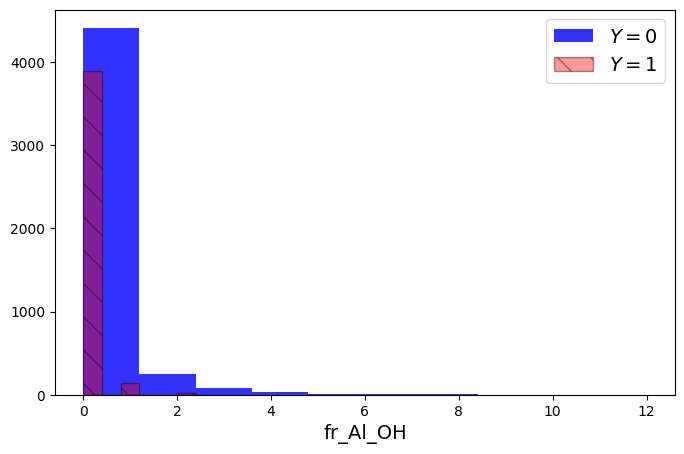

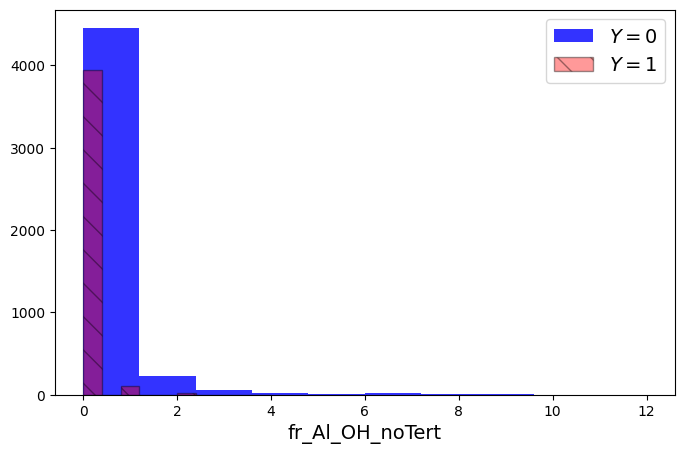

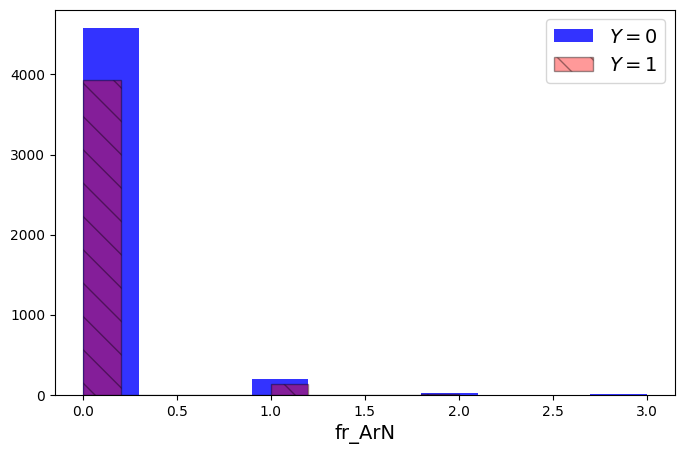

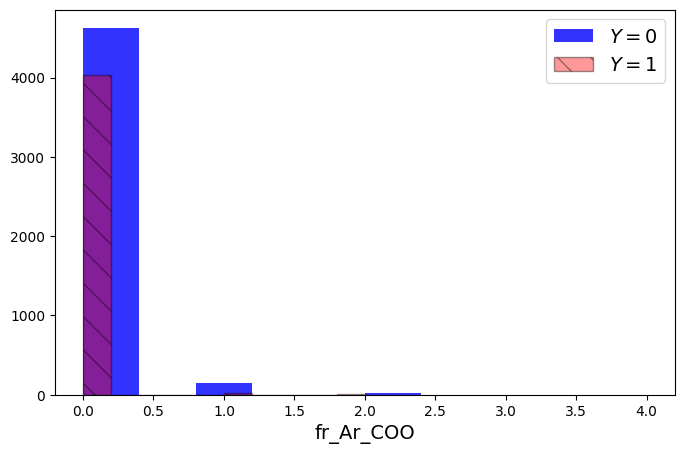

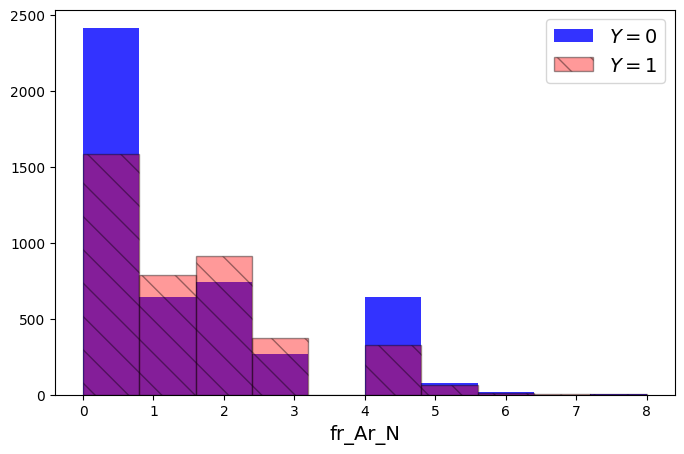

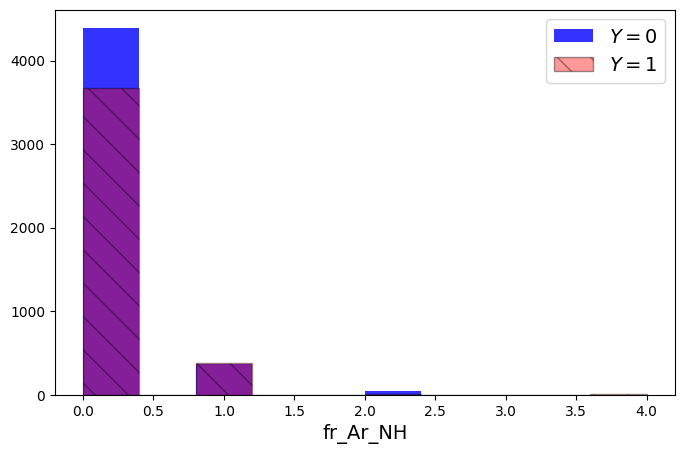

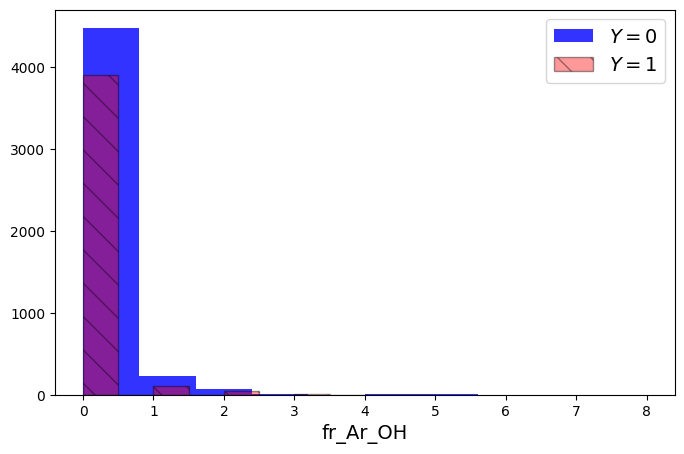

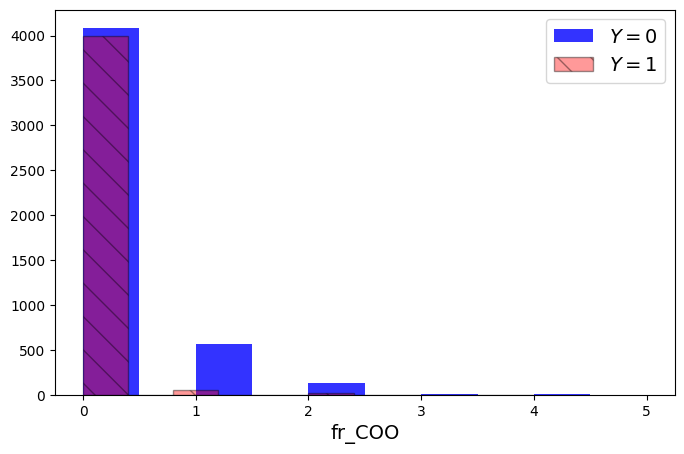

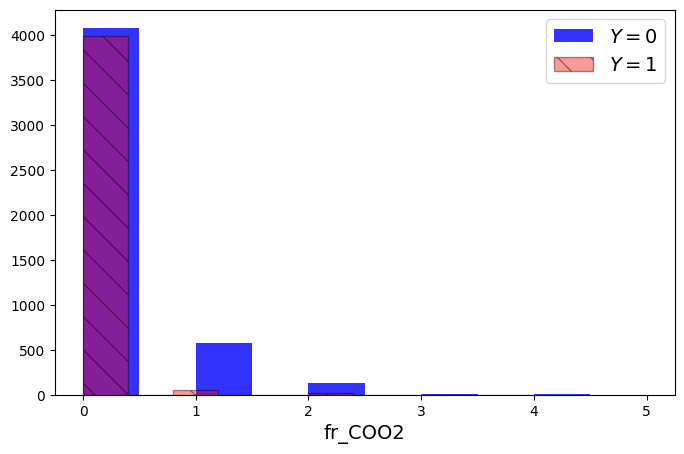

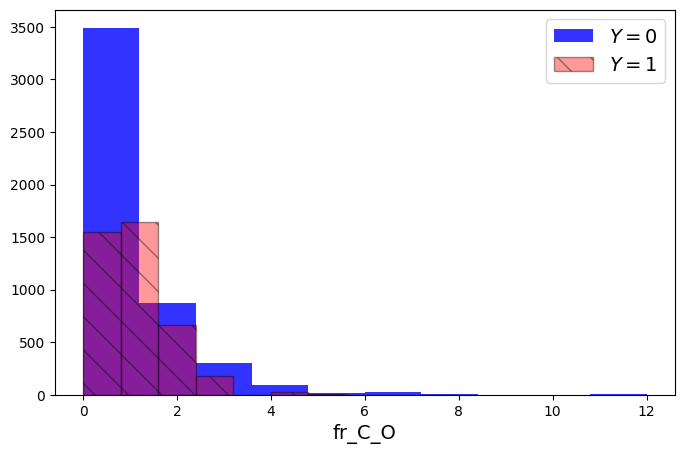

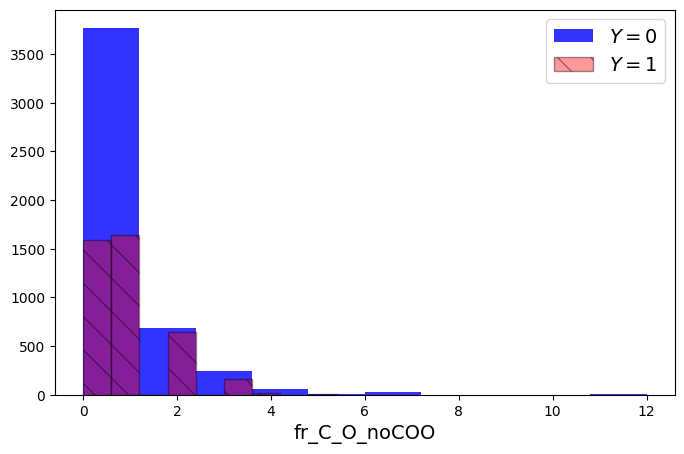

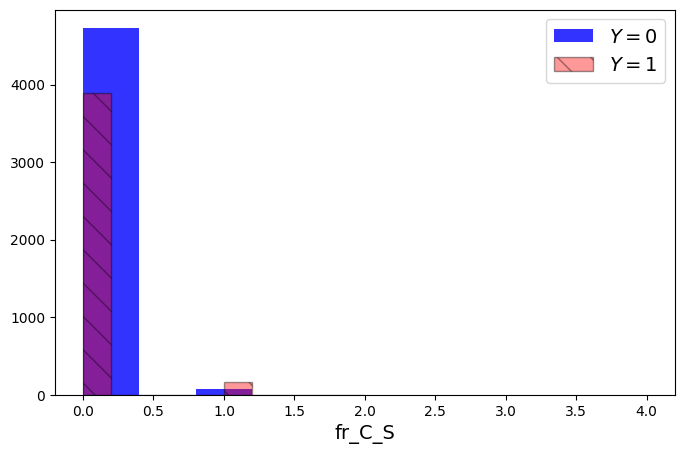

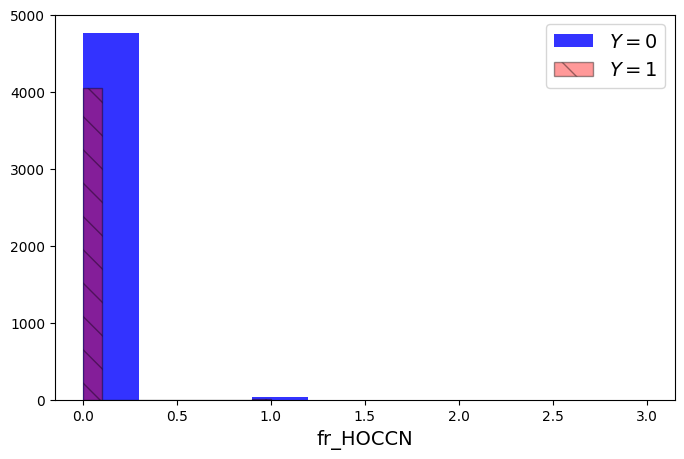

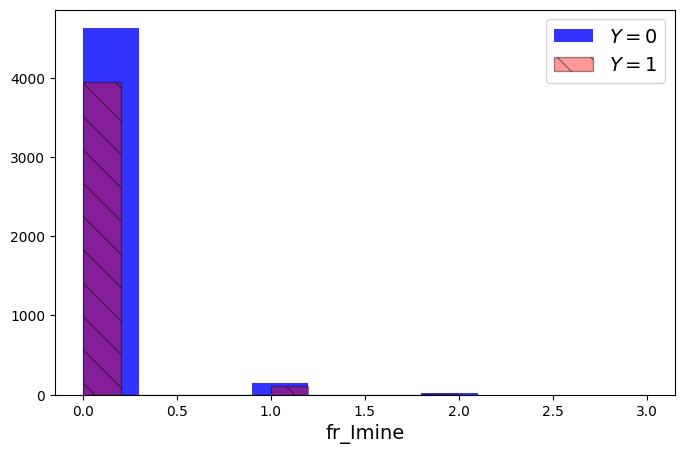

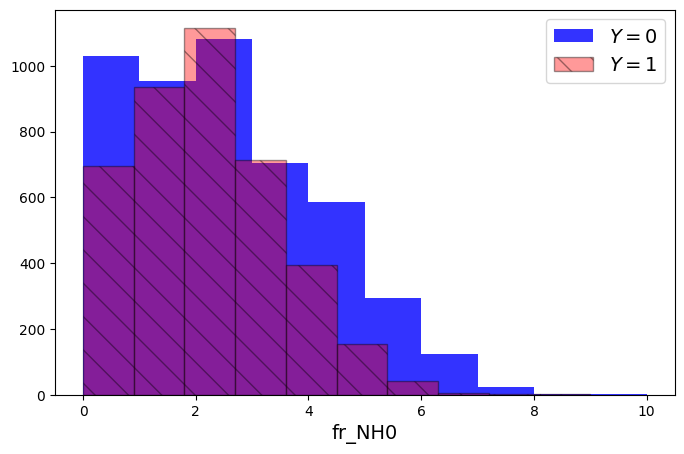

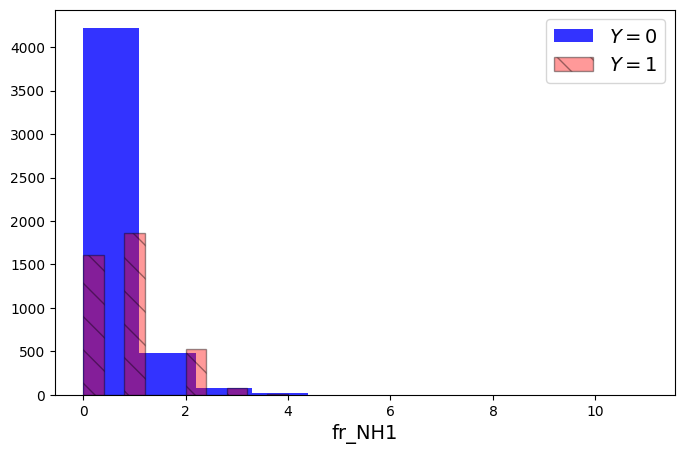

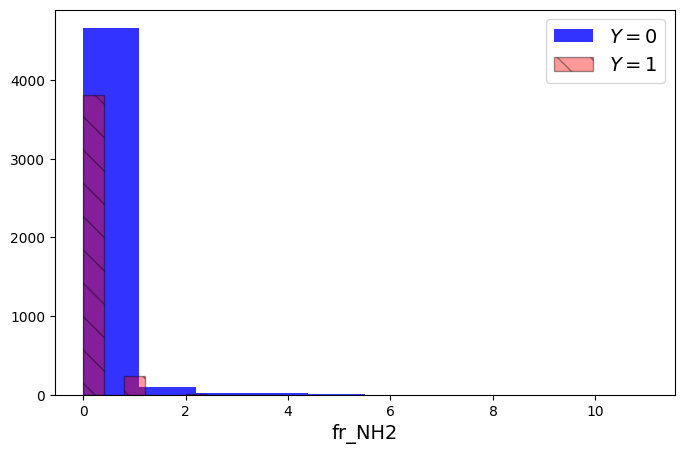

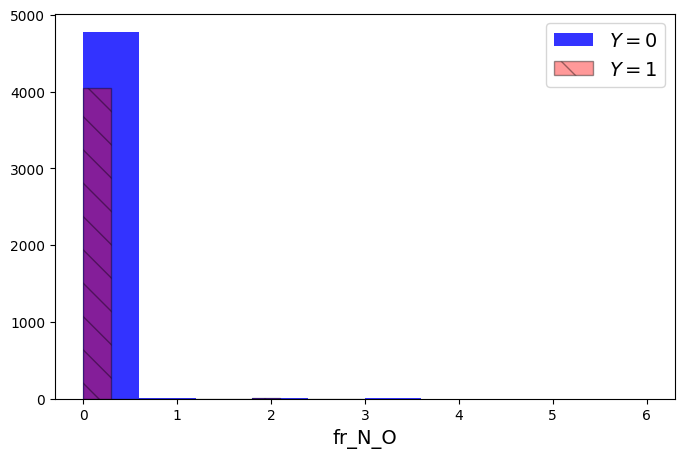

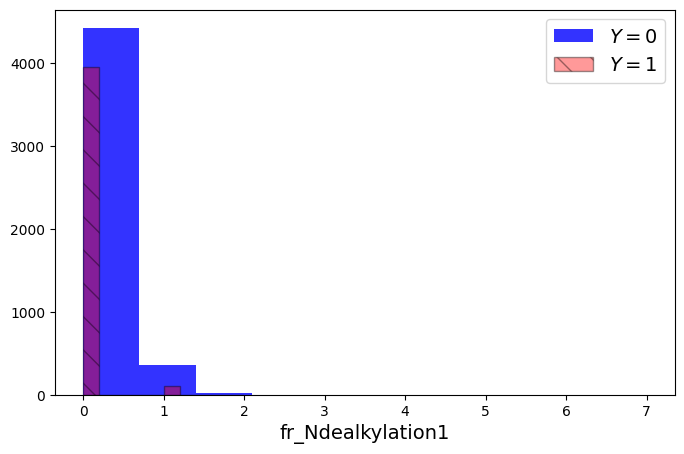

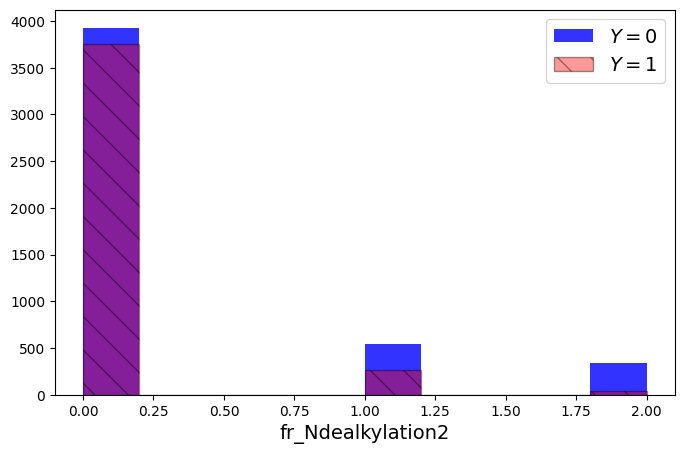

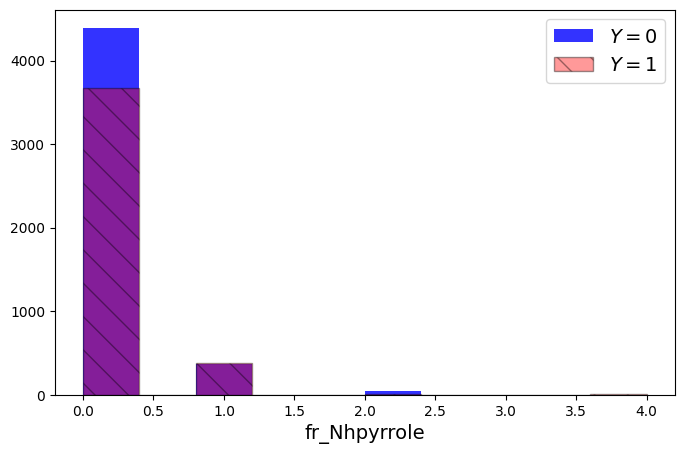

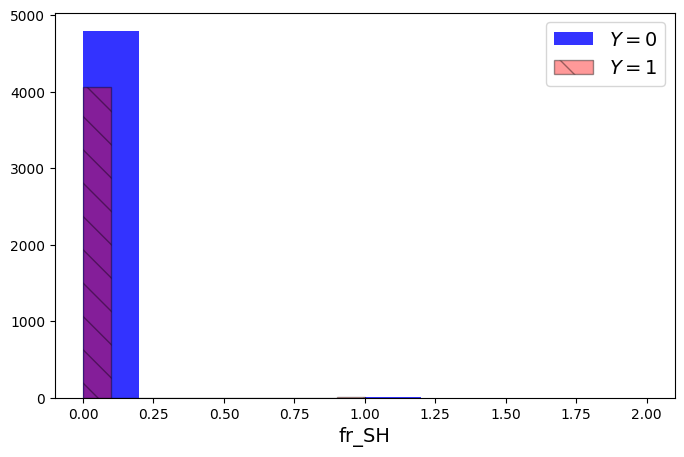

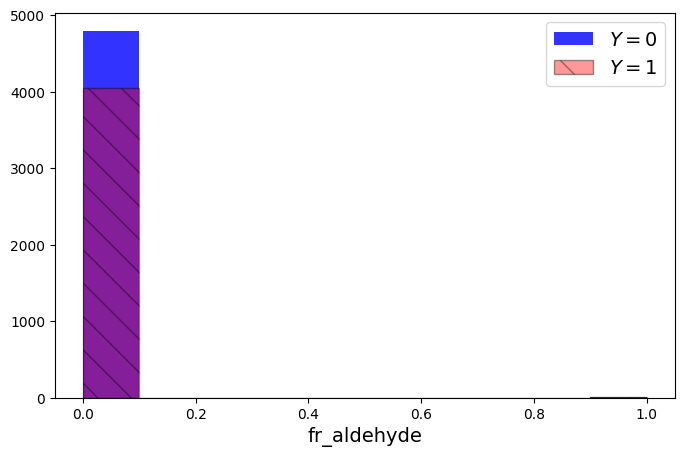

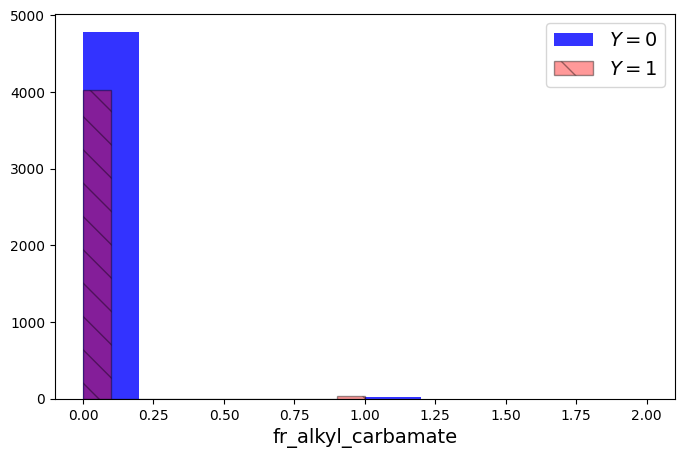

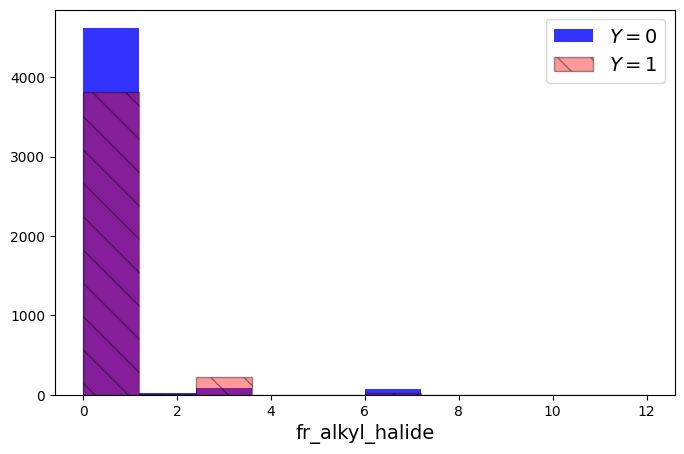

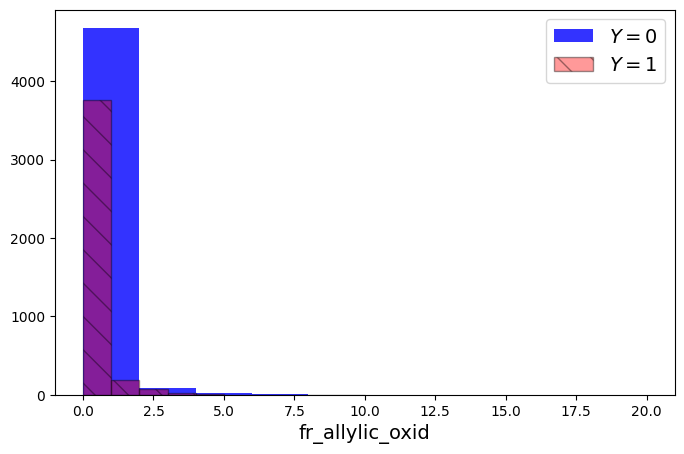

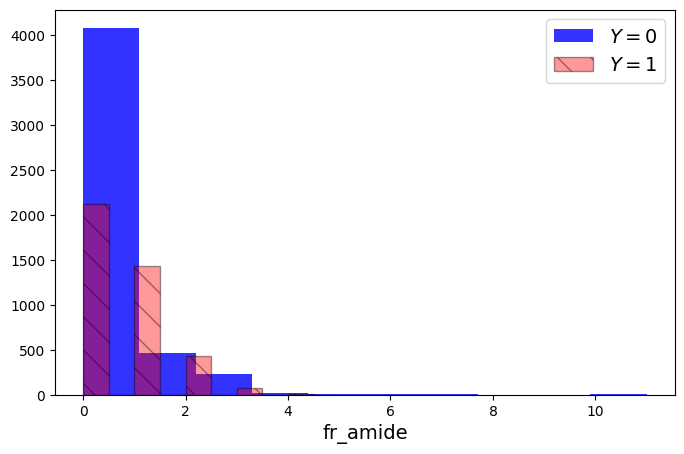

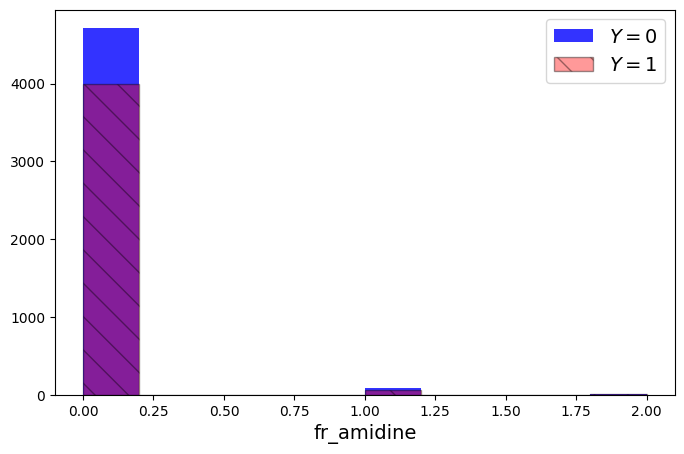

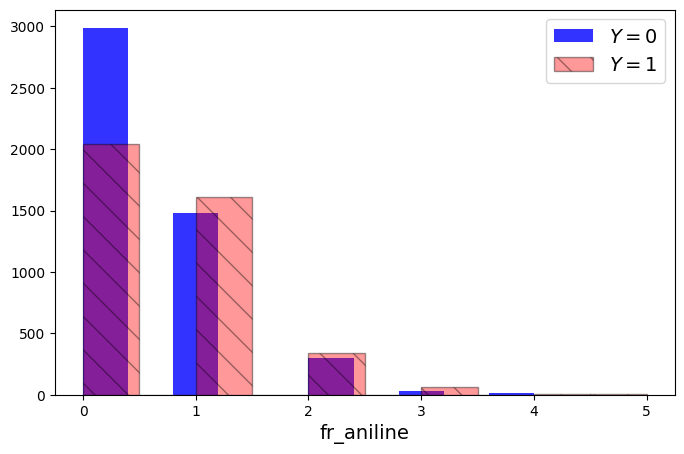

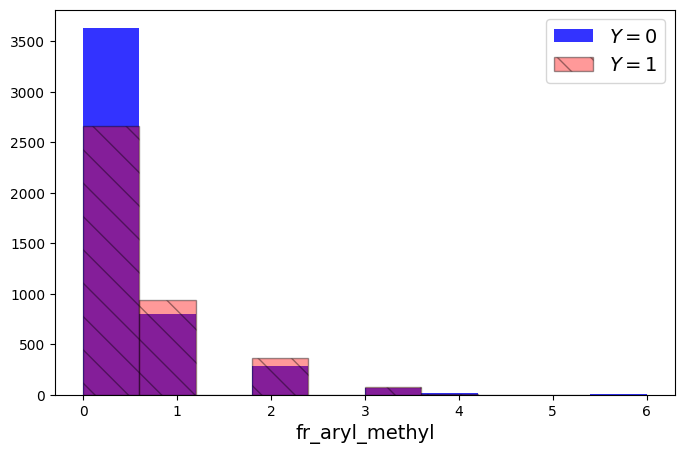

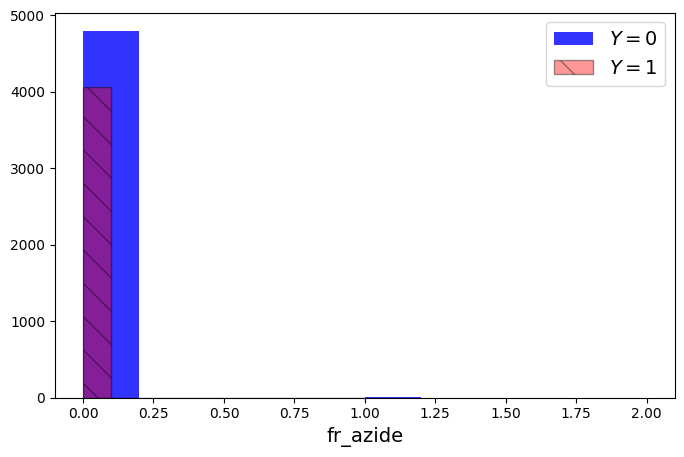

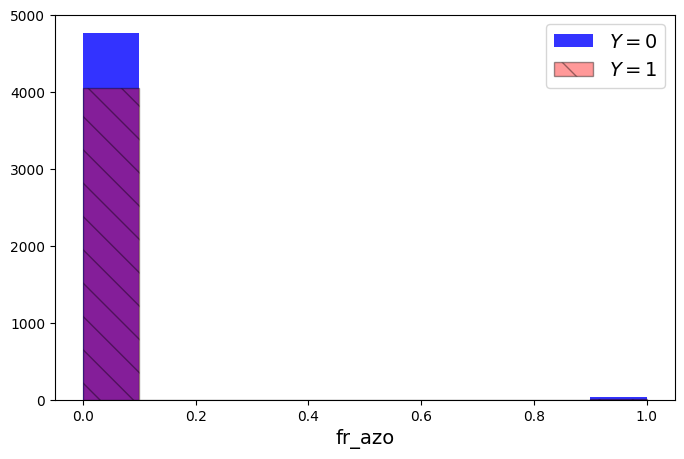

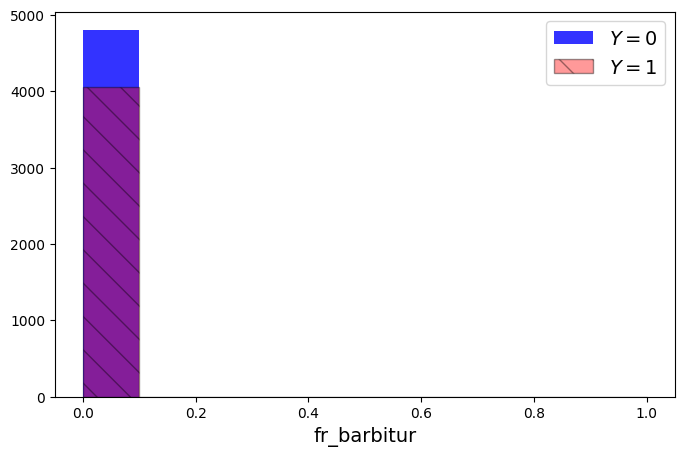

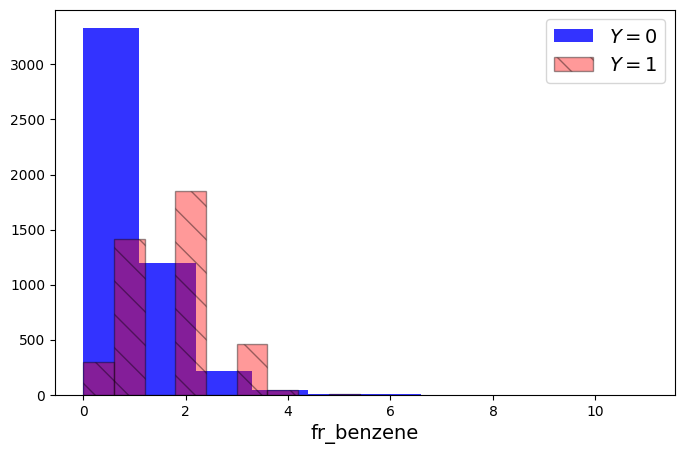

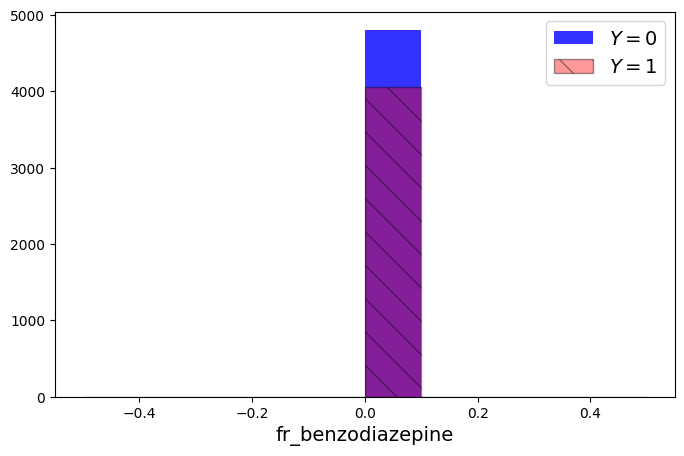

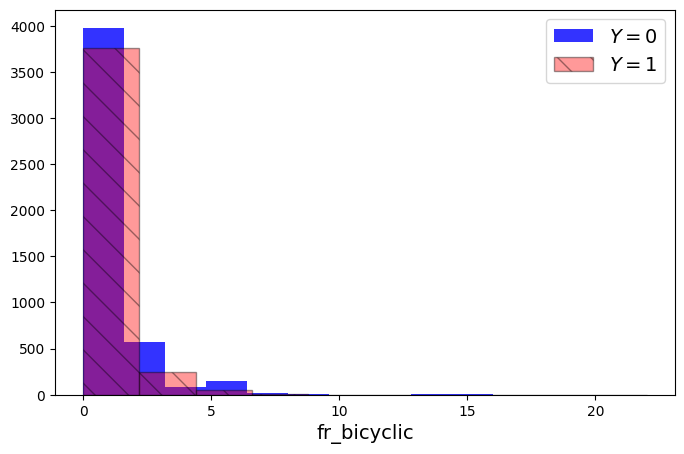

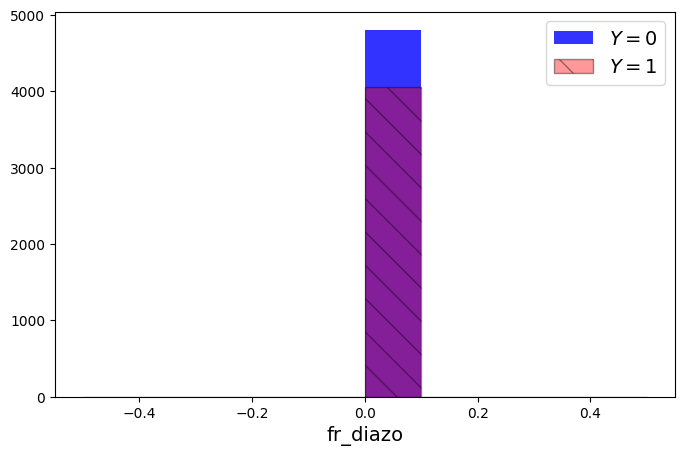

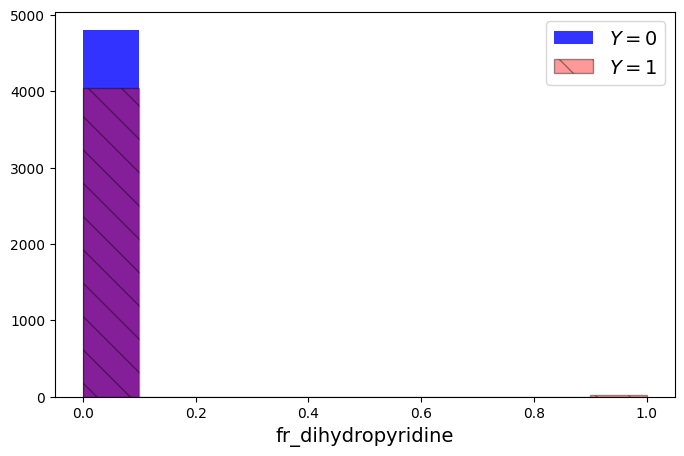

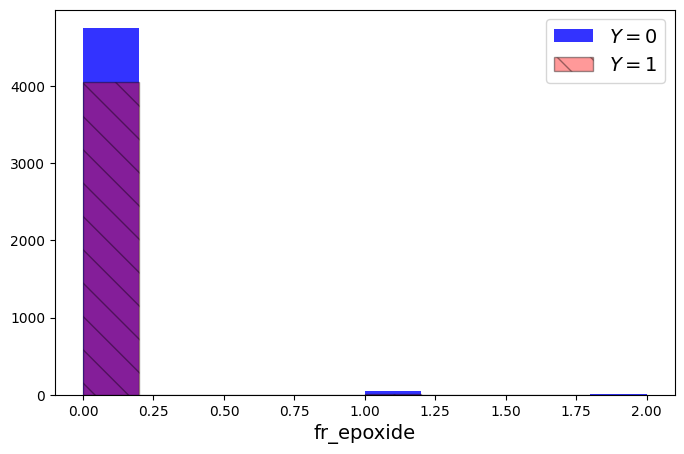

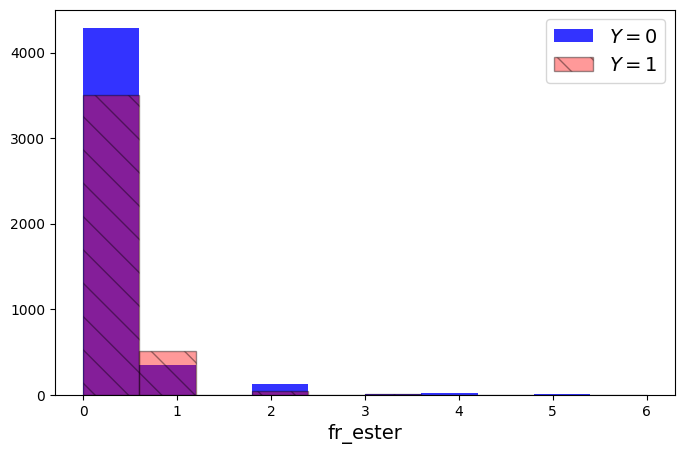

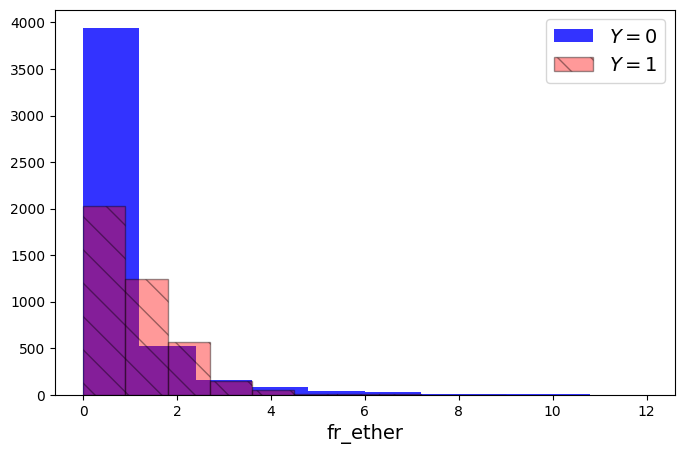

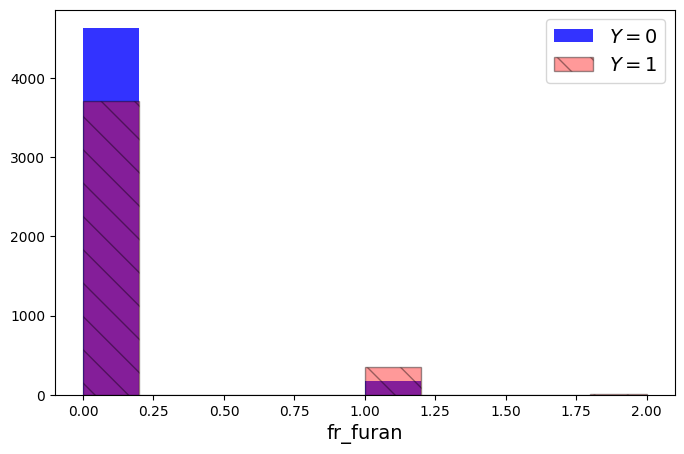

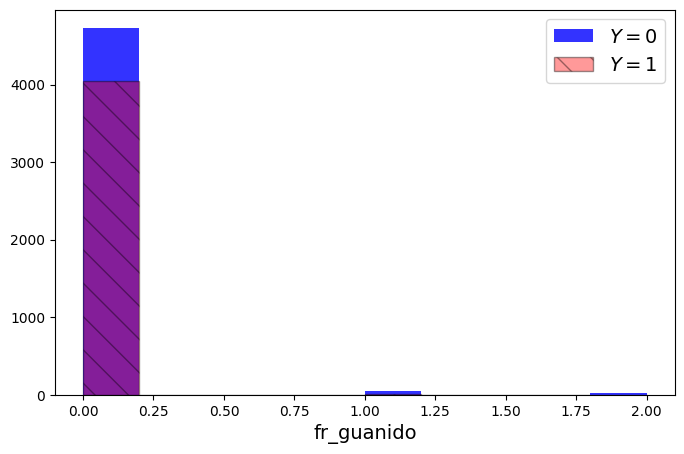

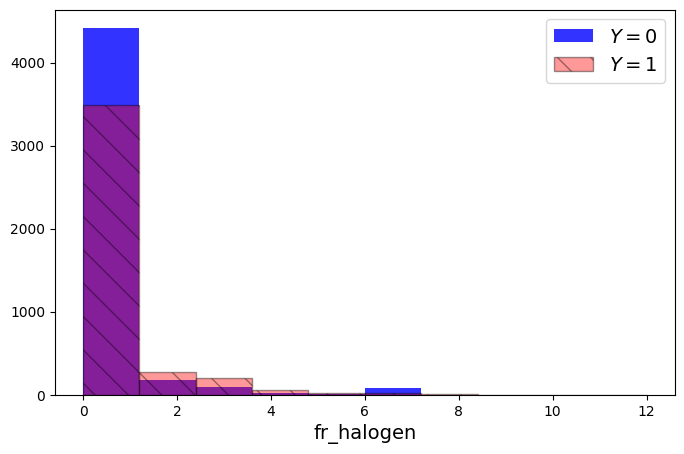

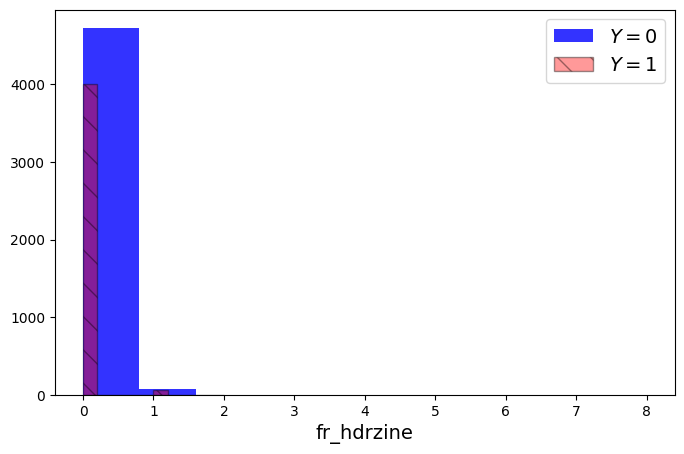

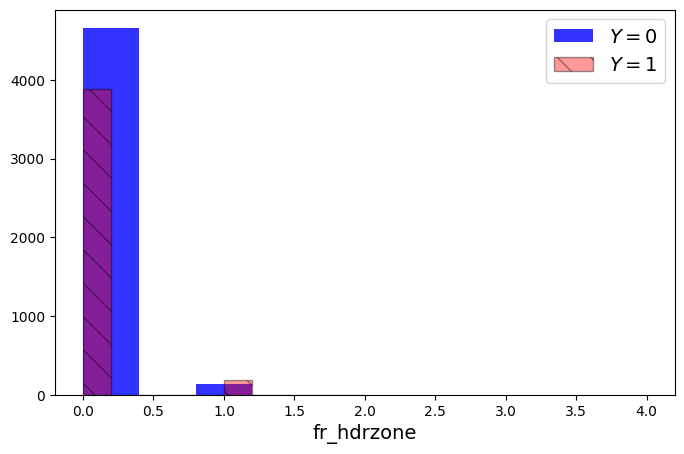

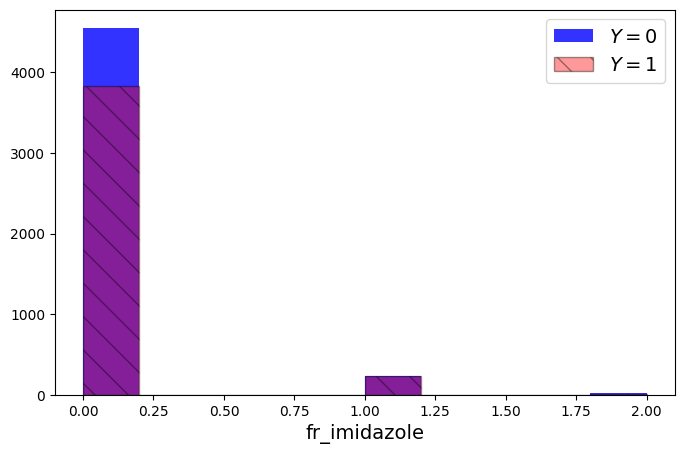

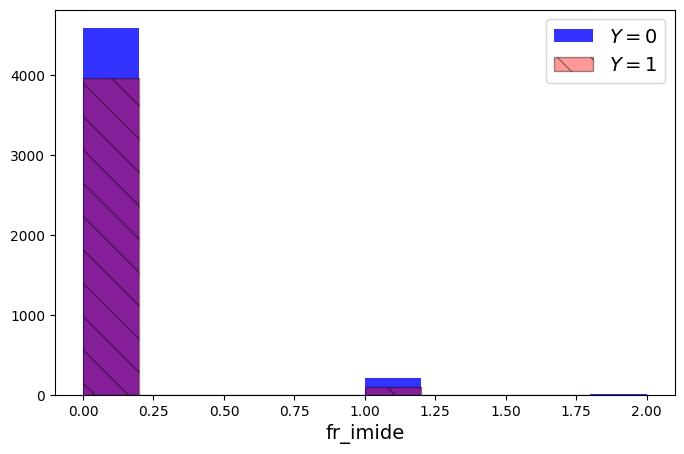

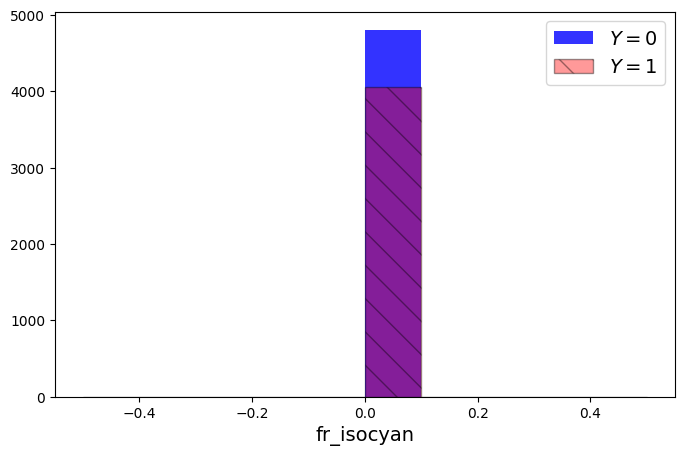

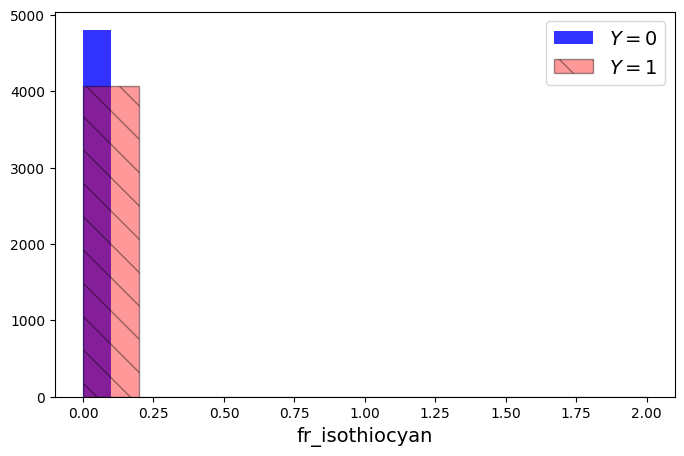

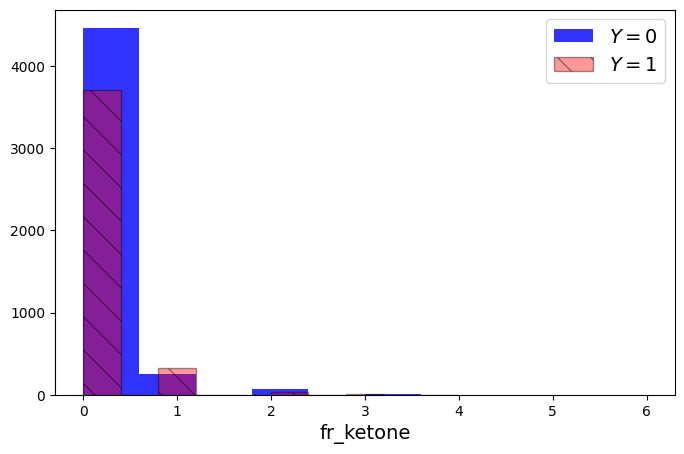

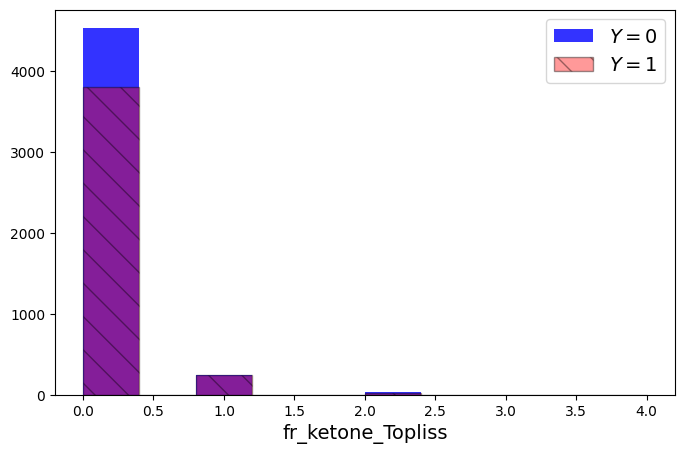

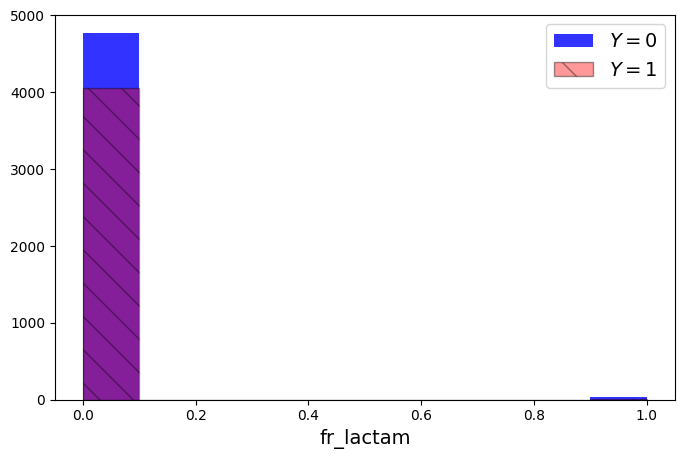

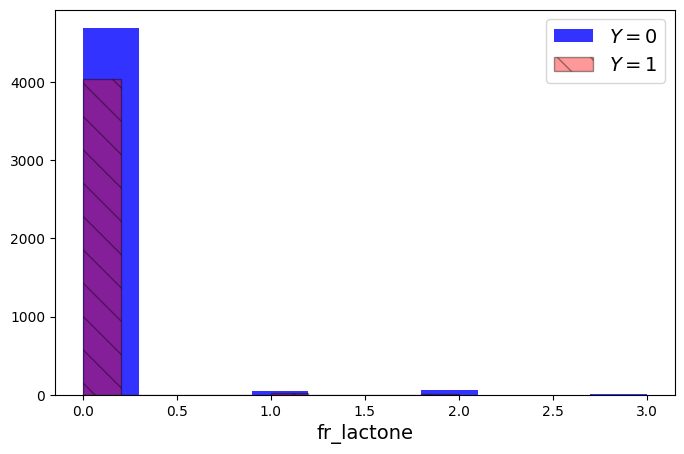

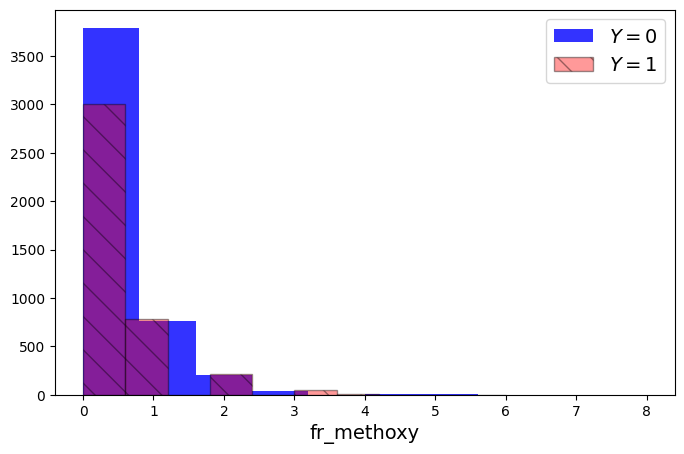

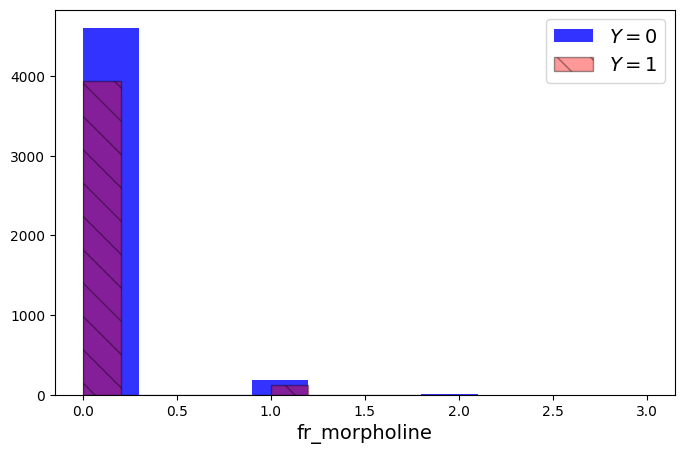

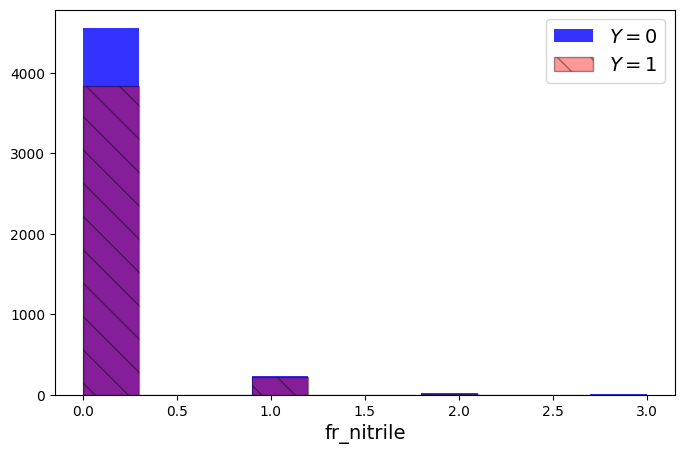

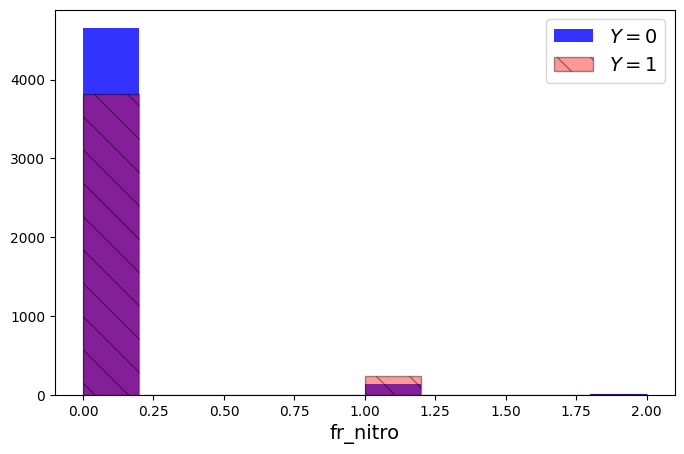

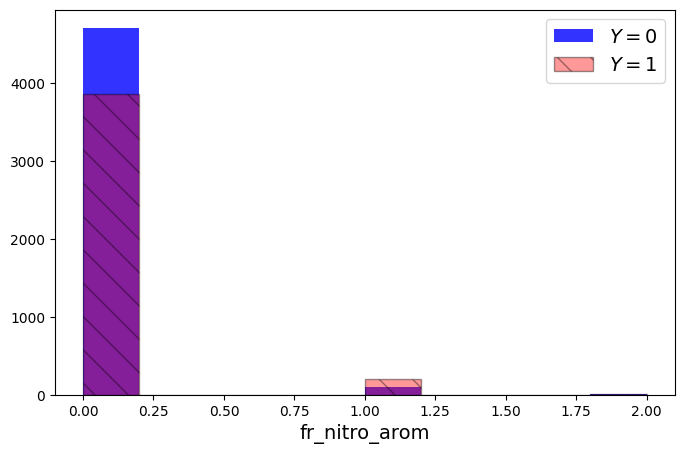

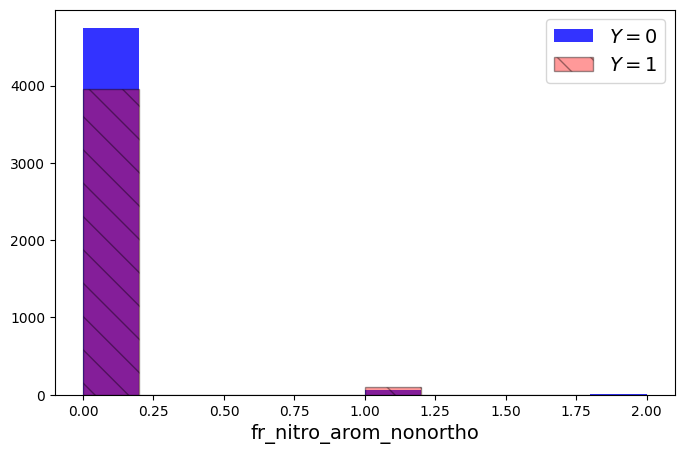

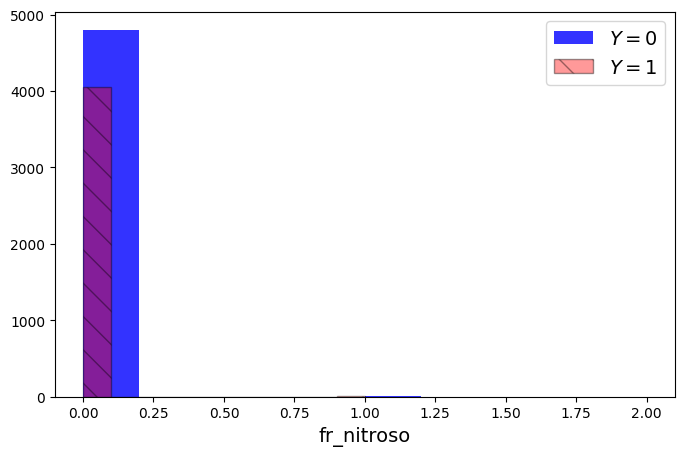

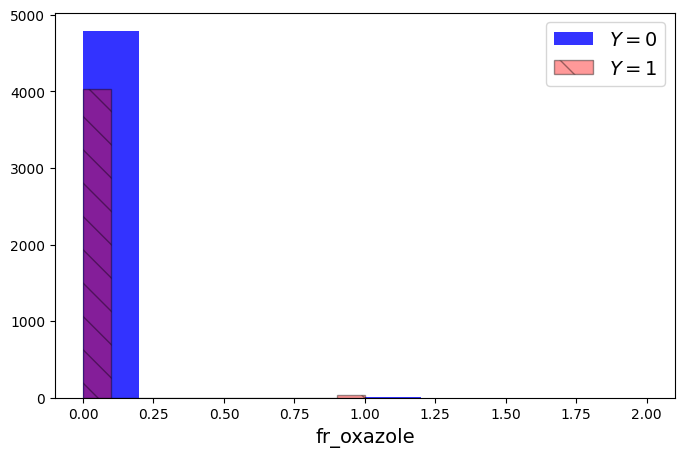

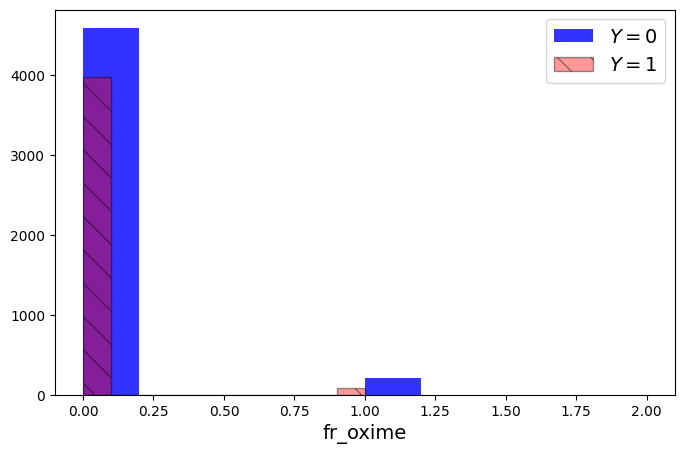

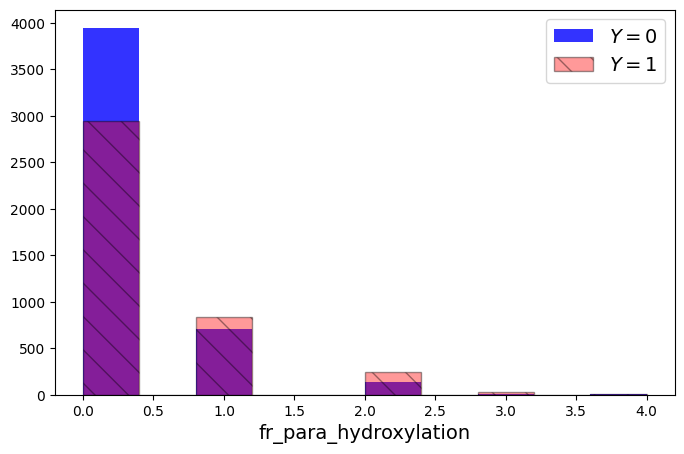

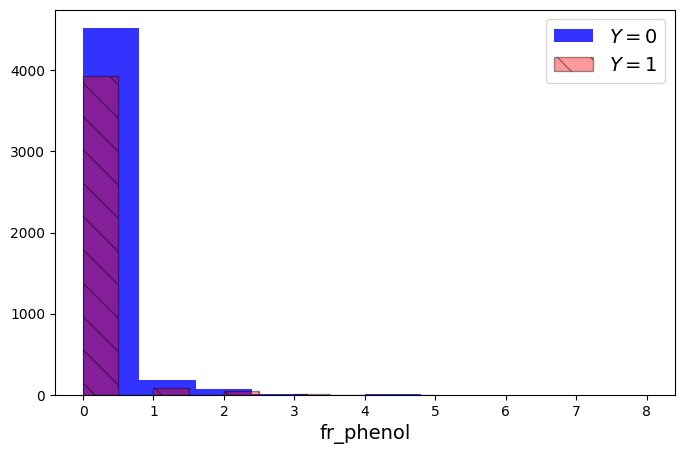

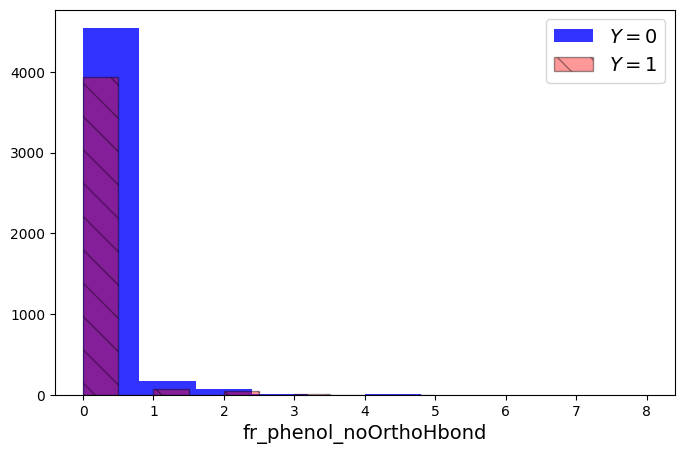

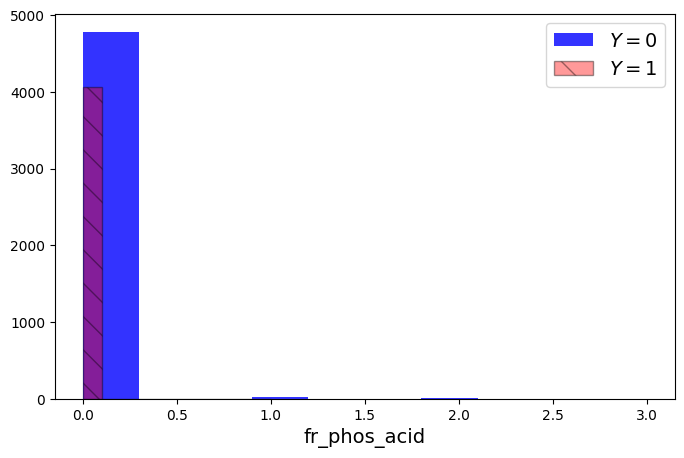

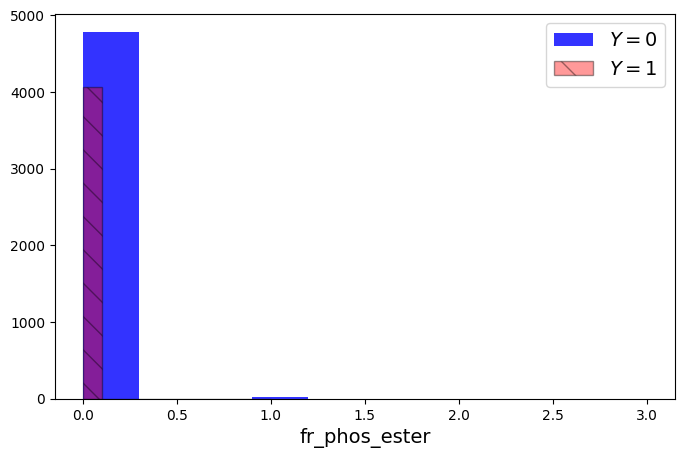

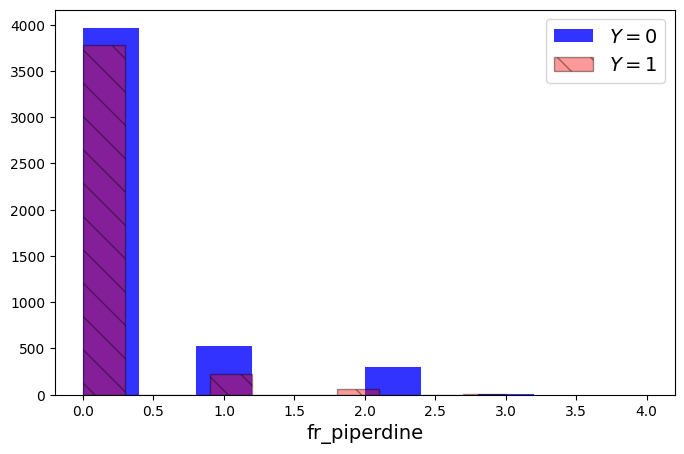

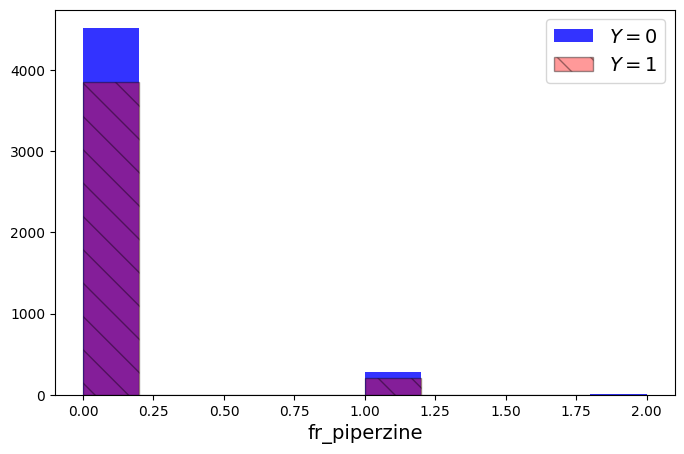

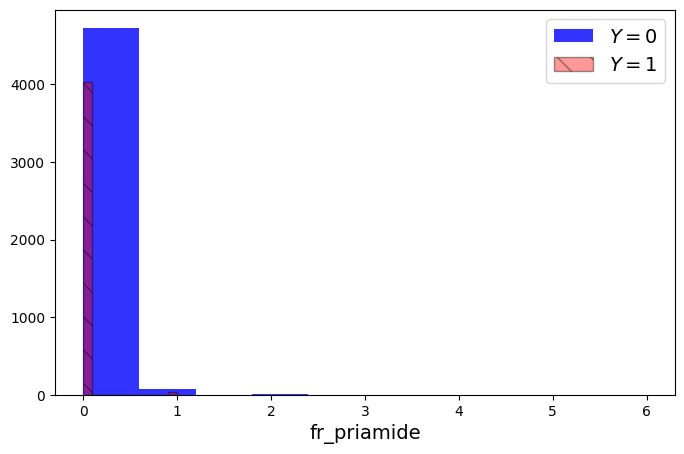

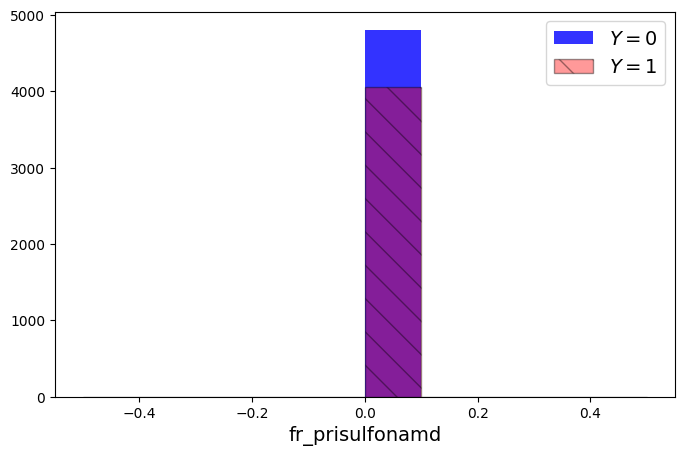

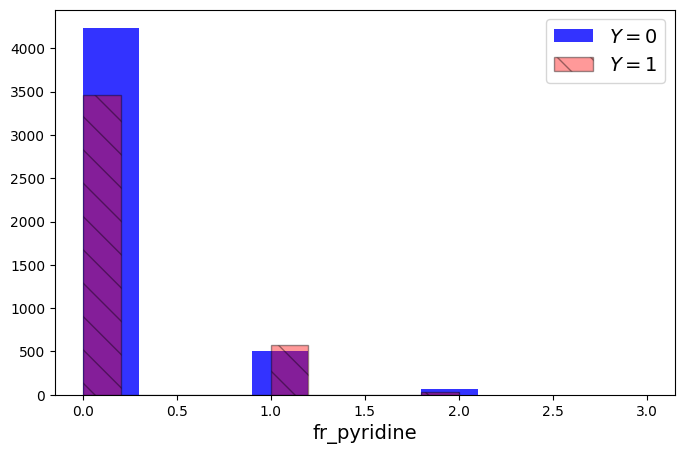

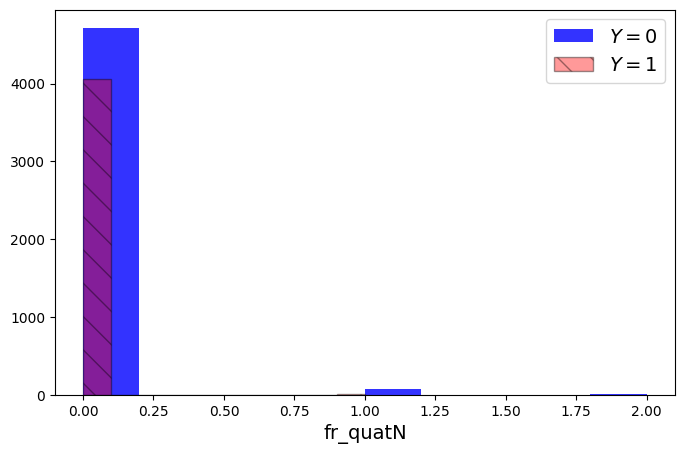

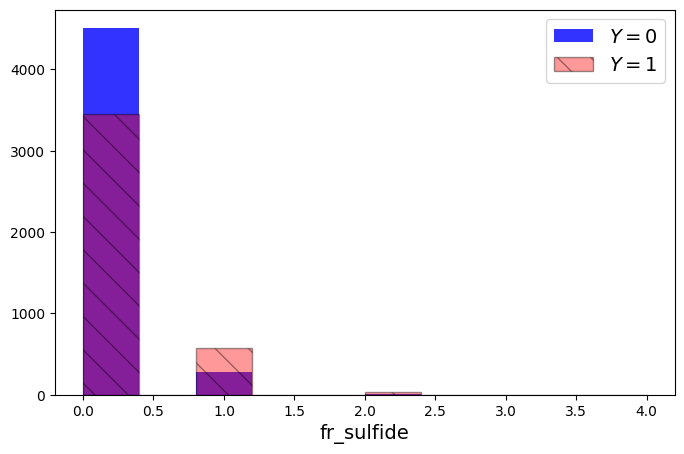

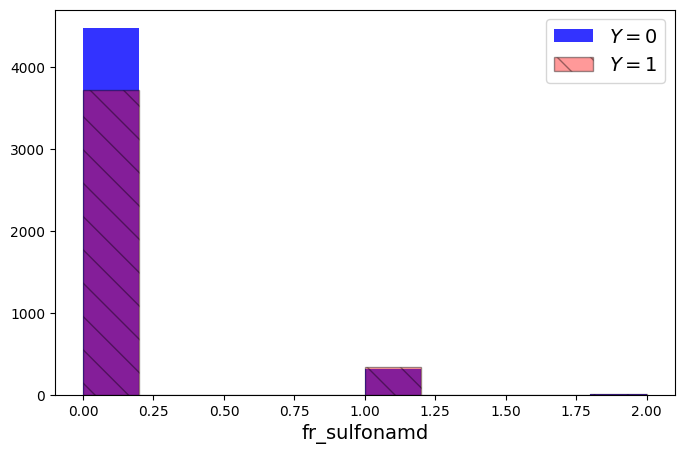

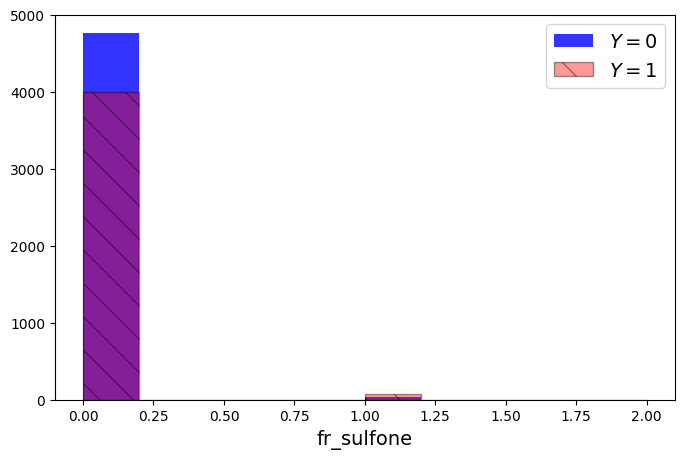

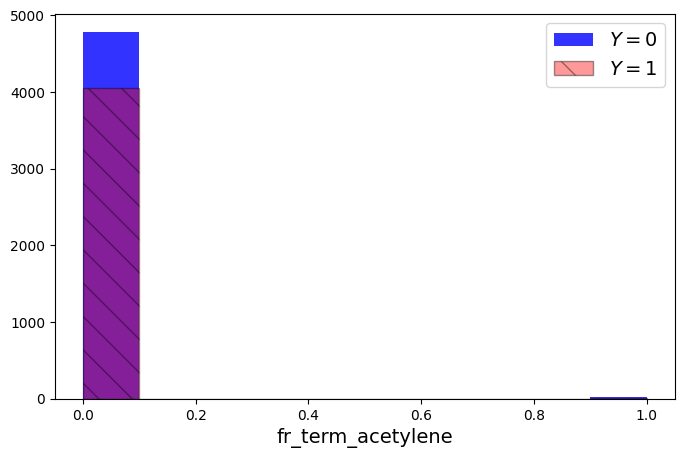

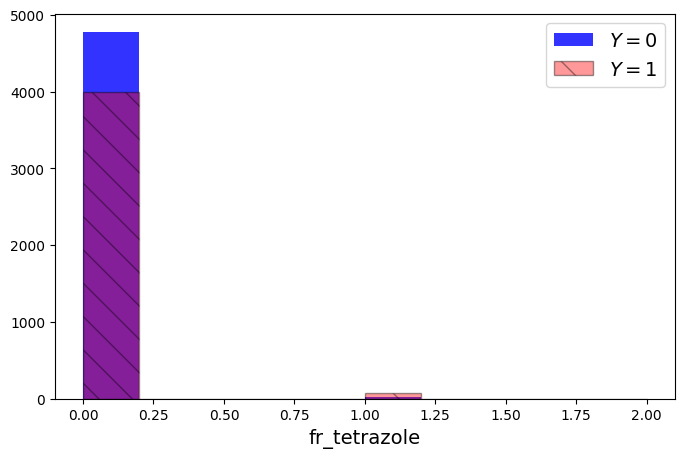

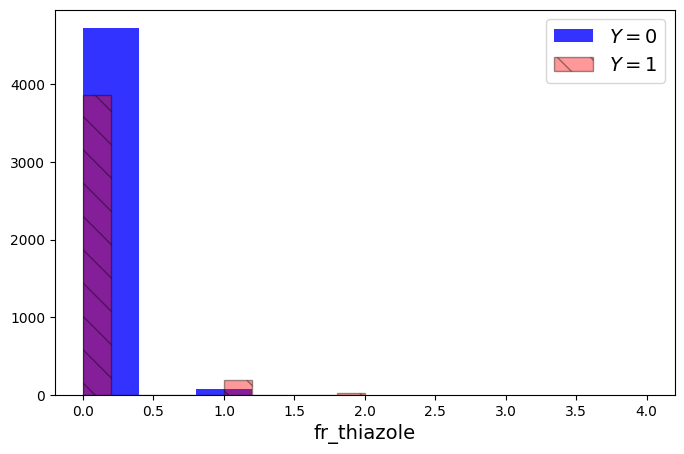

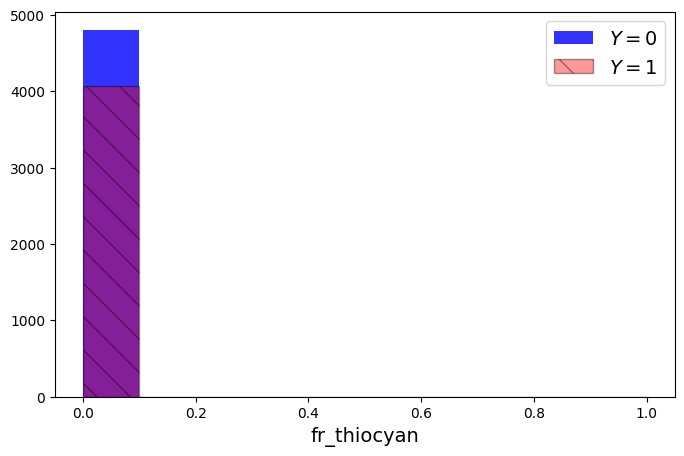

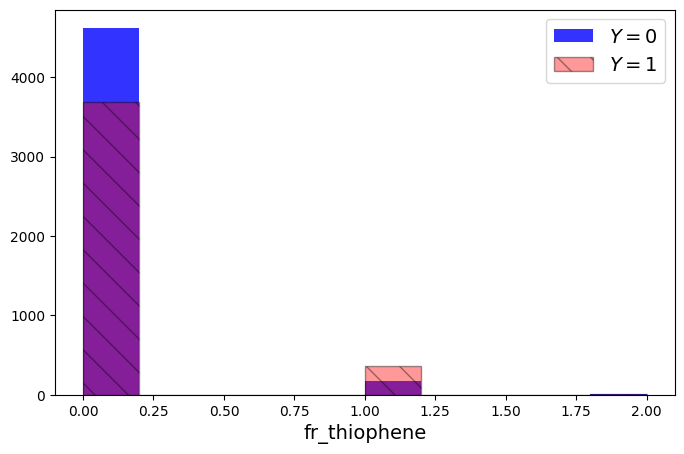

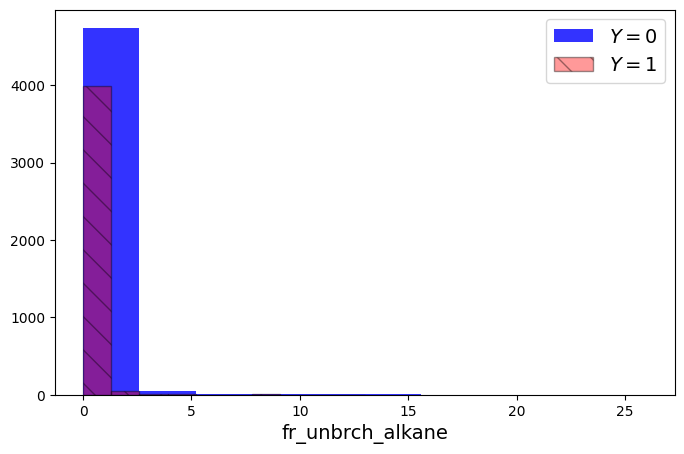

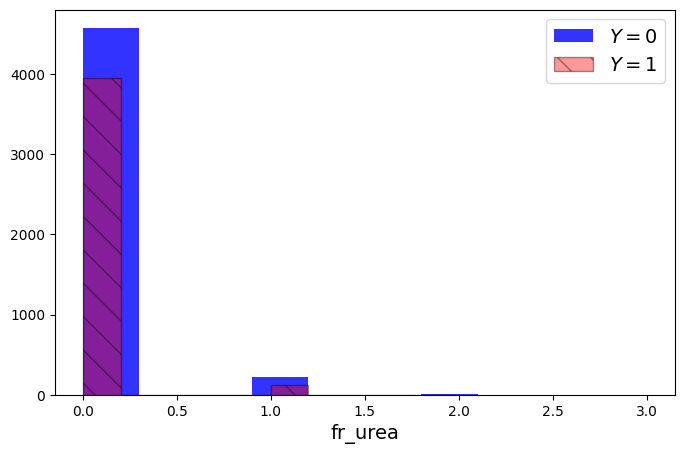

In [ ]:
for col in X_train.columns:
    plt.figure(figsize=(8,5))


    plt.hist(train_data.loc[train_data.Y==0, col].values,
                color='blue',
                alpha=.8,
                label="$Y=0$")

    plt.hist(train_data.loc[train_data.Y==1, col].values,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$Y=1$")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

In [ ]:
# plt.figure(figsize=(9,5))


# plt.hist(train_data.loc[train_data.Y==0].Ipc.values,
#             color='blue',
#             alpha=.8,
#             label="$Y=0$")

# plt.hist(train_data.loc[train_data.Y==1].Ipc.values,
#             color='red',
#             alpha=.4,
#             hatch = '\\',
#             edgecolor='black',
#             label="$Y=1$")

# plt.xlabel("Ipc", fontsize=14)
# plt.legend(fontsize=14)

# plt.show()

From the plots above, we see that the histogram of the descriptor `Ipc` is concentrated only on `Y=0`, while the histograms of the descriptors `Kappa2` and `Kappa3` are concentrated only on `Y=1`.

The hostograms of a few other descriptors, suchh as `SMR_VSA2`, `FractionCSP3`,`NumAromaticHeterocycles`, 
`MolWt`, and `NumValenceElectrons`, also encapsulate some signatures of the two classes. But, it is difficult to conclude anything further from the histograms of the rest of descriptors about the two classes -- at least not based on the ranges of values that these descriptors manifest.

Let's produce a `seaborn`'s `pairplot` using the descriptors identified above. Use `Y` as the argument to hue. We are are trying to identify any pairs of variables that seem to separate the two classes. 

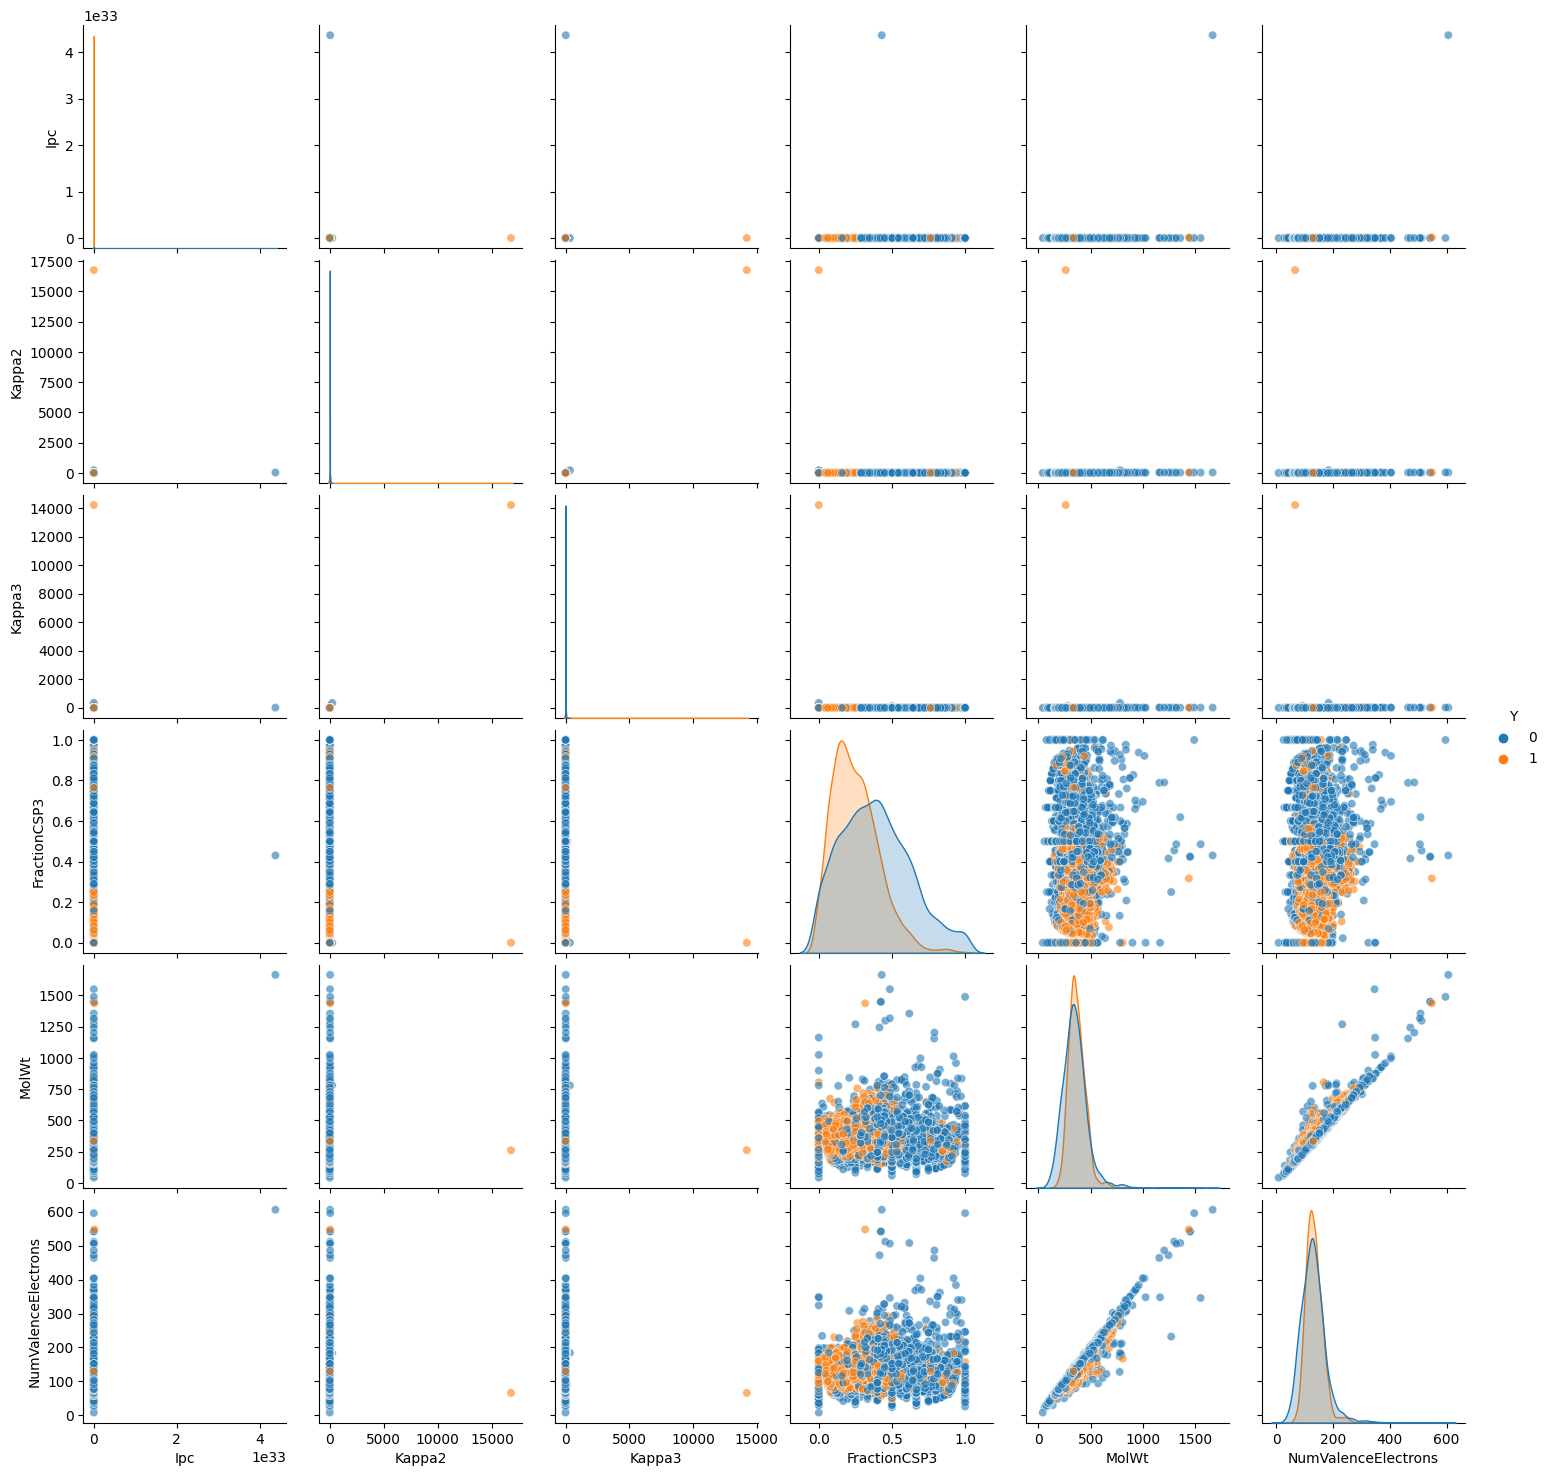

In [ ]:
feature_set = ['Ipc', 'Kappa2', 'Kappa3', 'FractionCSP3',
               'MolWt', 'NumValenceElectrons']
sns.pairplot(data = train_data, x_vars = feature_set, y_vars = feature_set,
             hue = 'Y', plot_kws = {'alpha':.6})

plt.show()

The pair, (`FractionCSP3`, `MolWt`), shows some sort of distinct clusters of two classes but the two clusters do overlap to a certain extent.

The diagonal plots here are the marginal distributions unlike the histograms we plotted above. We see that `Ipc` has significantly large value of marginal distribution. Let's check the maximum and minium values of `Ipc` for different classes.


In [ ]:
train_data[train_data.Y==0].Ipc.min(), train_data[train_data.Y==0].Ipc.max()

(0.0, 4.372979224730317e+33)

In [ ]:
train_data[train_data.Y==1].Ipc.min(), train_data[train_data.Y==1].Ipc.max()

(149.33517022534332, 1.340438657611857e+31)

We see that `Ipc` has significantly large values. This [observation](https://github.com/rdkit/rdkit/issues/1527) is reported to be molecule size dependent.

**Give the above EDA, it is likely that a suitable ML model could provide good model performance.** We will focus on ML modeling now.

## Chemical Space Visualization<a id='Chemical_Space_Visualization'></a>

But, before moving to ML model, we will do one more task. We will see if we can visualize the drugs in a 2D and 3D space. For this, we will try a few Spectral embedding technique from Scikit-learn's manifold [module](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html).

To perform this task, we would use the following two functions. Their input arguments are described below.

`np_extracted_data` = numpy array version of what comes out of extract_descriptors (e.g. `np_train_table_for_embedding` or `np_train_table_for_tsne`)

`y_labels` = the `Y` values corresponding to the the extracted data (the code above computes it; e.g. `train_y_labels`.

`dimension` = the reduced dimesnion (e.g. 3, 4, 5, ...)

# Modeling<a id='Modeling'></a>

## Logistic Regression<a id='Logistic_Regression'></a>

In [ ]:
pd.concat([X_train, X_valid], axis=0).isna().any().sum()

0

<Axes: >

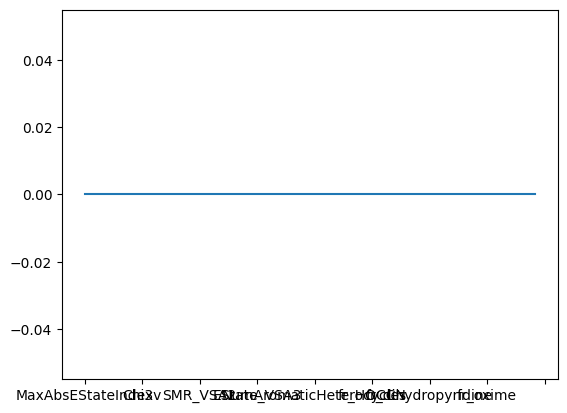

In [ ]:
pd.concat([X_train, X_valid], axis=0).isnull().sum().plot()

In [ ]:
# Define model
clf = LogisticRegression(penalty = None, max_iter = 1000)

# Fit
clf.fit(pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0))

# Predict on test set
y_pred = clf.predict(X_test)

In [ ]:
clf

LogisticRegression(max_iter=1000, penalty=None)

Accuracy: 0.54


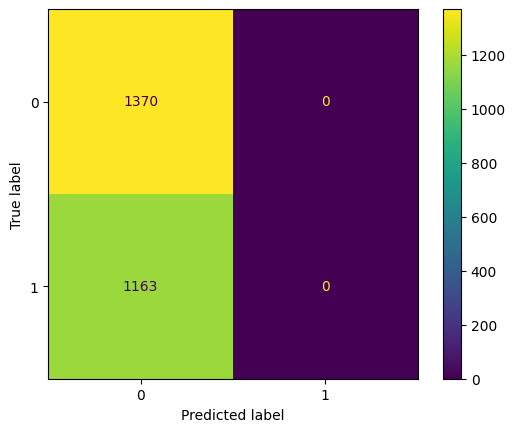

In [ ]:
# Evaluation of performance
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**All the class 1 have been completely missed by the Logistic regression model.** We will now try XGBoost classifier.

## XGBoost Classifier with fine tuning through GridSearchCV <a id='XGBoost_Classifier'></a>

In [ ]:
# Define model
model = XGBClassifier(
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)

# Define grid
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result
    # in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result 
    # in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }

# Define evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

# Define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,
                    cv=cv, scoring='accuracy')

# Execute grid search
grid_result = grid.fit(pd.concat([X_train, X_valid], axis=0),
                       pd.concat([y_train, y_valid], axis=0))

# Report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.814253 using {'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 0}


Accuracy: 0.81


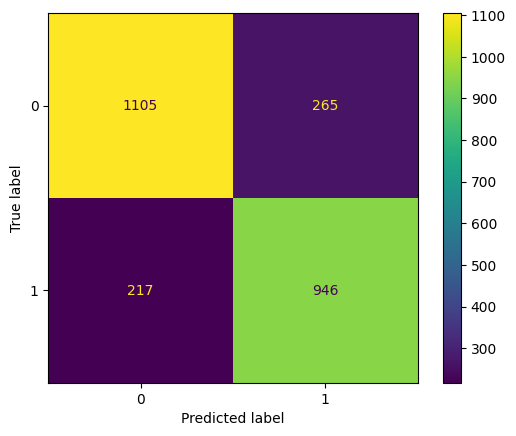

In [ ]:
# Evaluation of the best XGBoost Classifier
# Evaluate the performance of the model on (X_test, y_test)

y_pred = grid_result.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_result.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_result.best_estimator_.classes_)
disp.plot()
plt.show()

**The result here is not that bad. Accuracy is 0.81 for a relatively balanced data set.**

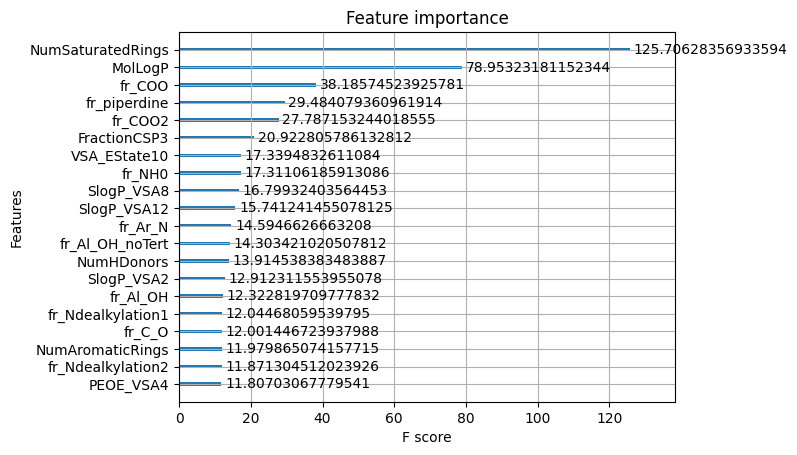

In [ ]:
# Plot feature importance for best XGBoost model
plot_importance(grid_result.best_estimator_,max_num_features=20,
                importance_type='gain') # top 20 most important features
plt.show()

**Remarks**:
1. The top most important feature based on the best XGBoost classifier is `NumSaturateRings` whose `F score` is significantly higher than the second most important feature (`MolLogP`) and the other features.